In [146]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

tf.compat.v1.random.set_random_seed(42)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from math import floor

from utils import concordance_index_censored_scorer,concordance_index_ipcw_scorer,integrated_brier_scorer,cumulative_dynamic_auc_scorer
from utils import log_rank_test,log_rank_test_scorer
from utils import reduce_T_max,reduce_uncensored

from sklearn.model_selection import KFold

import json
import os

from sksurv.nonparametric import kaplan_meier_estimator

from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize,LogNorm
from matplotlib.cm import ScalarMappable

In [103]:
NAME = "spinemet"
NAME_PLOT = "SpineMet"

plt.rcParams.update({'font.size': 20})

pd.set_option('display.max_columns', None)
df = pd.read_csv("Data/spinemet.tsv", sep = "\t")
drop_list = ["patient_id"]
df = df.drop(drop_list,axis=1)

timeline_resolution = 200

T_maxs = [1.0,0.75,0.5,0.25]
red_rates = [1.0,0.75,0.5,0.25]
from itertools import product
sensitivity_grid = np.array(list(product(T_maxs,red_rates))) # [:,0] -> T_maxs, [:,1] -> red_rates

# Preprocessing

In [104]:
# fix normal values, whenever available:
normal_values = {"na":np.mean([136,145]),
                 "k":np.mean([3.5,5.1]),
                 "vvt":np.mean([3.8,5.8]),
                 "hg":np.mean([120,170]),
                 "htk":np.mean([35,50]),
                 "fvs":np.mean([4,10]),
                 "thr":np.mean([150,350]),
                 "creat":np.mean([53,88]),
                 "alp":150,
                 "ldh":160,
                 "albumin":np.mean([34,50]),
                 "serum_protein":np.mean([64,82])}

df = df.fillna(normal_values)

In [105]:
df.head()

sex  age  pain_syn  local_recurrence  motor_deficit  \
0  male   75         1                 0              0   
1  male   75         0                 0              0   
2  male   76         0                 1              0   
3  male   56         1                 0              1   
4  male   67         1                 0              0   

   wound_healing_disorder  vegetative_deficit  atlantoaxial_instability  \
0                       0                   0                         1   
1                       0                   0                         0   
2                       0                   0                         0   
3                       0                   0                         0   
4                       0                   0                         0   

   screw_dysfunction  axial_instability  swallowing_difficulty  \
0                  0                  0                      0   
1                  0                  0                      0   
2                  0                  0                      0   
3                  0                  0                      0   
4                  0                  0                      0   

   accidental_diagnosis  prior_rheuma_threatment  spinal_ataxia  \
0                     0                        0              0   
1                     0                        0              0   
2                     0                        0              0   
3                     0                        0              0   
4                     0                        0              0   

   patological_arm_fracture  local_pain  radicular_pain  mobility_restricted  \
0                         0           1               0                    0   
1                         0           0               0                    0   
2                         0           0               0                    0   
3                         0           1               1                    1   
4                         0           1               1                    1   

   walking_inability  paresis  motor_deficit_left  motor_deficit_right  \
0                  0        0                   0                    0   
1                  0        0                   0                    0   
2                  0        1                   1                    0   
3                  0        1                   1                    1   
4                  0        0                   0                    0   

   motor_deficit_upper  motor_deficit_lower  paraparesis  hemiparesis  \
0                    0                    0            0            0   
1                    0                    0            0            0   
2                    1                    0            0            0   
3                    0                    1            1            0   
4                    0                    0            0            0   

   tetraparesis  plegia  paraplegia  tetraplegia  paresis_scale  \
0             0       0           0            0              5   
1             0       0           0            0              5   
2             0       0           0            0              3   
3             0       0           0            0              3   
4             0       0           0            0              5   

   latent_paresis  sensory_deficit  hypesthaesia  paresthaesia  dysesthaesia  \
0               0                0             0             0             0   
1               0                0             0             0             0   
2               0                0             0             0             0   
3               0                1             1             0             0   
4               0                0             0             0             0   

   hyperesthaesia  incontinentia  retentio  frankel_grade  preop_karnofsky  \
0               0              0         0              5              

In [106]:
df_original = df.copy()

In [107]:
from preprocessing import Preprocessor
cat_feats = ["sex","primer_tumor","histological_classification","surgery_season","invasiveness"]
                 
num_feats = ["age","paresis_scale","frankel_grade","preop_karnofsky","ecog",
             "num_of_interspinal_metastases","num_of_operated_segments",
             "avg_len_of_operated_segments","num_of_surgeries",
             "num_of_extraspinal_bonemetastases","removability","hospital_days",
             "asa","charlson_comorbidity_index","na","k","vvt","hg","htk",
             "fvs","thr","creat","alp","ldh","albumin","serum_protein"]
             
pp = Preprocessor(cat_feat_strat="mode",num_feat_strat="knn",scaling_strategy="minmax",remaining="ignore")
df = pp.fit_transform(df, cat_feats=cat_feats, num_feats=num_feats)

In [108]:
from sklearn.preprocessing import MinMaxScaler
time_scaler = MinMaxScaler()
df["survival_in_days"]= time_scaler.fit_transform(df["survival_in_days"].to_numpy().reshape(-1, 1))

In [109]:
df.head()

age  pain_syn  local_recurrence  motor_deficit  \
0  0.879518         1                 0              0   
1  0.879518         0                 0              0   
2  0.891566         0                 1              0   
3  0.650602         1                 0              1   
4  0.783133         1                 0              0   

   wound_healing_disorder  vegetative_deficit  atlantoaxial_instability  \
0                       0                   0                         1   
1                       0                   0                         0   
2                       0                   0                         0   
3                       0                   0                         0   
4                       0                   0                         0   

   screw_dysfunction  axial_instability  swallowing_difficulty  \
0                  0                  0                      0   
1                  0                  0                      0   
2                  0                  0                      0   
3                  0                  0                      0   
4                  0                  0                      0   

   accidental_diagnosis  prior_rheuma_threatment  spinal_ataxia  \
0                     0                        0              0   
1                     0                        0              0   
2                     0                        0              0   
3                     0                        0              0   
4                     0                        0              0   

   patological_arm_fracture  local_pain  radicular_pain  mobility_restricted  \
0                         0           1               0                    0   
1                         0           0               0                    0   
2                         0           0               0                    0   
3                         0           1               1                    1   
4                         0           1               1                    1   

   walking_inability  paresis  motor_deficit_left  motor_deficit_right  \
0                  0        0                   0                    0   
1                  0        0                   0                    0   
2                  0        1                   1                    0   
3                  0        1                   1                    1   
4                  0        0                   0                    0   

   motor_deficit_upper  motor_deficit_lower  paraparesis  hemiparesis  \
0                    0                    0            0            0   
1                    0                    0            0            0   
2                    1                    0            0            0   
3                    0                    1            1            0   
4                    0                    0            0            0   

   tetraparesis  plegia  paraplegia  tetraplegia  paresis_scale  \
0             0       0           0            0            1.0   
1             0       0           0            0            1.0   
2             0       0           0            0            0.6   
3             0       0           0            0            0.6   
4             0       0           0            0            1.0   

   latent_paresis  sensory_deficit  hypesthaesia  paresthaesia  dysesthaesia  \
0               0                0             0             0             0   
1               0                0             0             0             0   
2               0                0             0             0             0   
3               0                1             1             0             0   
4               0                0             0             0             0   

   hyperesthaesia  incontinentia  retentio  frankel_grade  preop_karnofsky  \
0               0              0         0           1.00         0.714286   
1  

In [110]:
# Divide the dataset
X = df.drop(["survival_in_days","censored"],axis = 1)
x_size = len(X.columns)
X = np.float32(X.to_numpy())
t = np.float32(df.survival_in_days.to_numpy())
delta = df["censored"].to_numpy().astype(np.float32)
y = np.stack([t,delta],axis = 1)

In [111]:
# Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

# Filter the test set for t > max(t_train), as these can cause problems for the scores (...)
t_max = min([max(y_train[:,0]),max(y_test[:,0])])
t_min = max([min(y_train[:,0]),min(y_test[:,0])])
mask = (t_min <= y_test[:,0]) & (y_test[:,0] <= t_max)
X_test = X_test[mask]
y_test = y_test[mask]

# Create a timeline for evaluation
t_max = min([t_max,max(y_test[:,0])])
t_min = max([t_min,min(y_test[:,0])])
timeline = np.linspace(t_min,t_max,timeline_resolution,endpoint=False).astype(np.float32)

# Exploration

In [112]:
# Dataset statistics

properties = {"Dataset": NAME_PLOT,
              "Num. of Patients": len(df_original),
              "Num. of Features": len(df_original.columns)-2,
              "Num. of Numeric Features": len(num_feats),
              "Num. of Categorical Features": len(df_original.columns)-2-len(num_feats),
              "Mean Survival": round(np.mean(df_original.survival_in_days),2),
              "Min. Survival": round(min(df_original.survival_in_days),2),
              "Max. Survival": round(max(df_original.survival_in_days),2),
              "Num. of Censored": len(df_original[df_original["censored"] == 0]),
              "Censored %": round(len(df_original[df_original["censored"] == 0])/len(df_original)*100,2),
              "Censored Mean Survival": round(np.mean(df_original.survival_in_days[df_original["censored"] == 0]),2),
              "Censored Min. Survival": round(min(df_original.survival_in_days[df_original["censored"] == 0]),2),
              "Censored Max. Survival": round(max(df_original.survival_in_days[df_original["censored"] == 0]),2),
              "Num. of Uncensored": len(df_original[df_original["censored"] == 1]),
              "Uncensored %": round(len(df_original[df_original["censored"] == 1])/len(df_original)*100,2),
              "Uncensored Mean Survival": round(np.mean(df_original.survival_in_days[df_original["censored"] == 1]),2),
              "Uncensored Min. Survival": round(min(df_original.survival_in_days[df_original["censored"] == 1]),2),
              "Uncensored Max. Survival": round(max(df_original.survival_in_days[df_original["censored"] == 1]),2)}

_ = [print(key,':',value) for key, value in properties.items()]

Dataset : SpineMet
Num. of Patients : 521
Num. of Features : 91
Num. of Numeric Features : 26
Num. of Categorical Features : 65
Mean Survival : 633.2
Min. Survival : 10
Max. Survival : 4224
Num. of Censored : 97
Censored % : 18.62
Censored Mean Survival : 1808.37
Censored Min. Survival : 639
Censored Max. Survival : 4224
Num. of Uncensored : 424
Uncensored % : 81.38
Uncensored Mean Survival : 364.35
Uncensored Min. Survival : 10
Uncensored Max. Survival : 3111


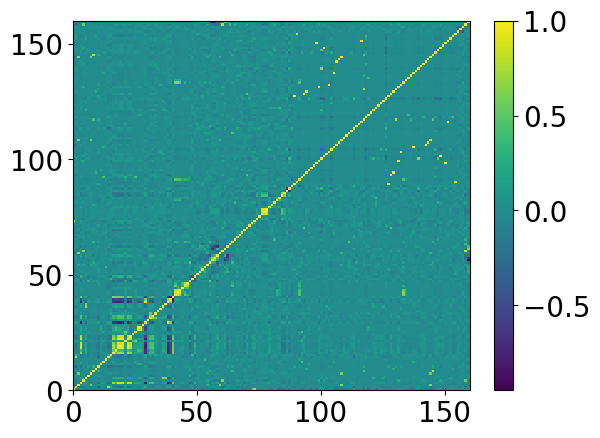

In [113]:
plt.pcolor(df.corr())
plt.colorbar()
plt.show()

In [114]:
from lifelines.fitters.coxph_fitter import CoxPHFitter
cox_test_df = pd.DataFrame(np.append(np.vstack([y_train,y_test]),np.hstack([np.zeros(len(y_train)).T,np.ones(len(y_test))]).reshape(-1,1),axis=1))

cph = CoxPHFitter()
cph.fit(df = cox_test_df,
        duration_col = 0,
        event_col = 1)

print(cph.summary)

#cph.check_assumptions(cox_test_df,
#                      show_plots=True,
#                      p_value_threshold=0.7)

print(cph.log_likelihood_ratio_test())

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
2          0.022885   1.023149  0.105837       -0.184552        0.230321   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
2                     0.831477             1.259005     0.0  0.216228   

                 p  -log2(p)  
covariate                     
2          0.82881  0.270887  
<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 1
        test_name = log-likelihood ratio test

---
 test_statistic    p  -log2(p)
           0.05 0.83      0.27


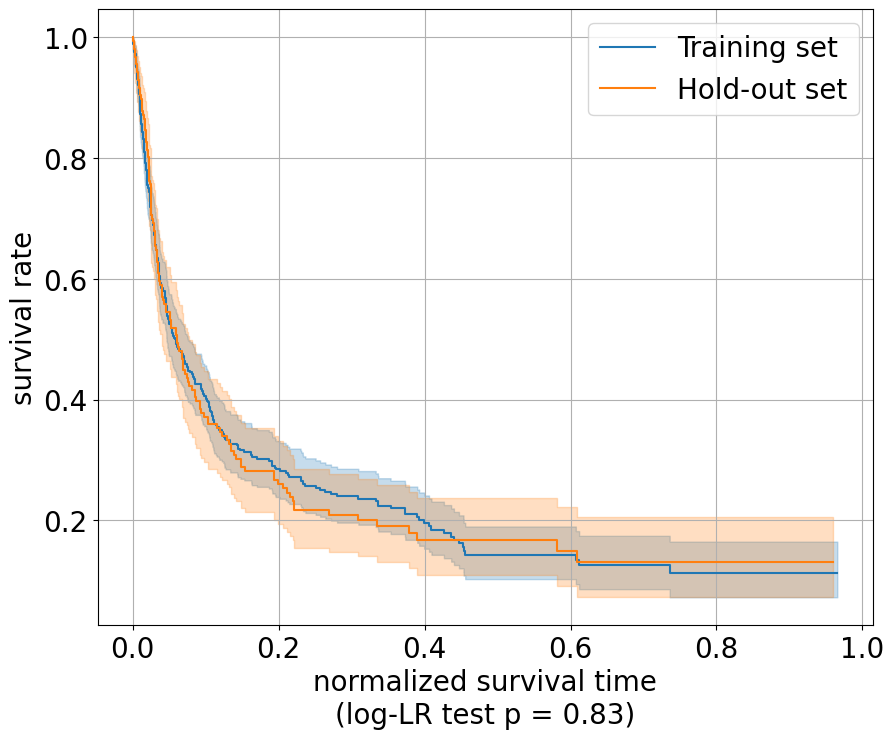

In [115]:
from lifelines.fitters.kaplan_meier_fitter import KaplanMeierFitter

plt.figure(figsize=(10,8))

kmf1 = KaplanMeierFitter(label="Training set")
kmf1.fit(y_train[:,0], y_train[:,1])
kmf1.plot()

kmf2 = KaplanMeierFitter(label="Hold-out set")
kmf2.fit(y_test[:,0], y_test[:,1])
kmf2.plot()

#plt.title("KM estimator of the training and hold-out sets")
plt.xlabel(f"normalized survival time\n(log-LR test p = {round(cph.log_likelihood_ratio_test().p_value,2)})")
plt.ylabel("survival rate")
plt.grid()
plt.show()

## Testing the 5Fold Cross Validation Data

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
2          0.206877   1.229832  0.143863       -0.075088        0.488843   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
2                     0.927661             1.630429     0.0  1.438019   

                  p  -log2(p)  
covariate                      
2          0.150429   2.73285  
<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 1
        test_name = log-likelihood ratio test

---
 test_statistic    p  -log2(p)
           1.98 0.16      2.65


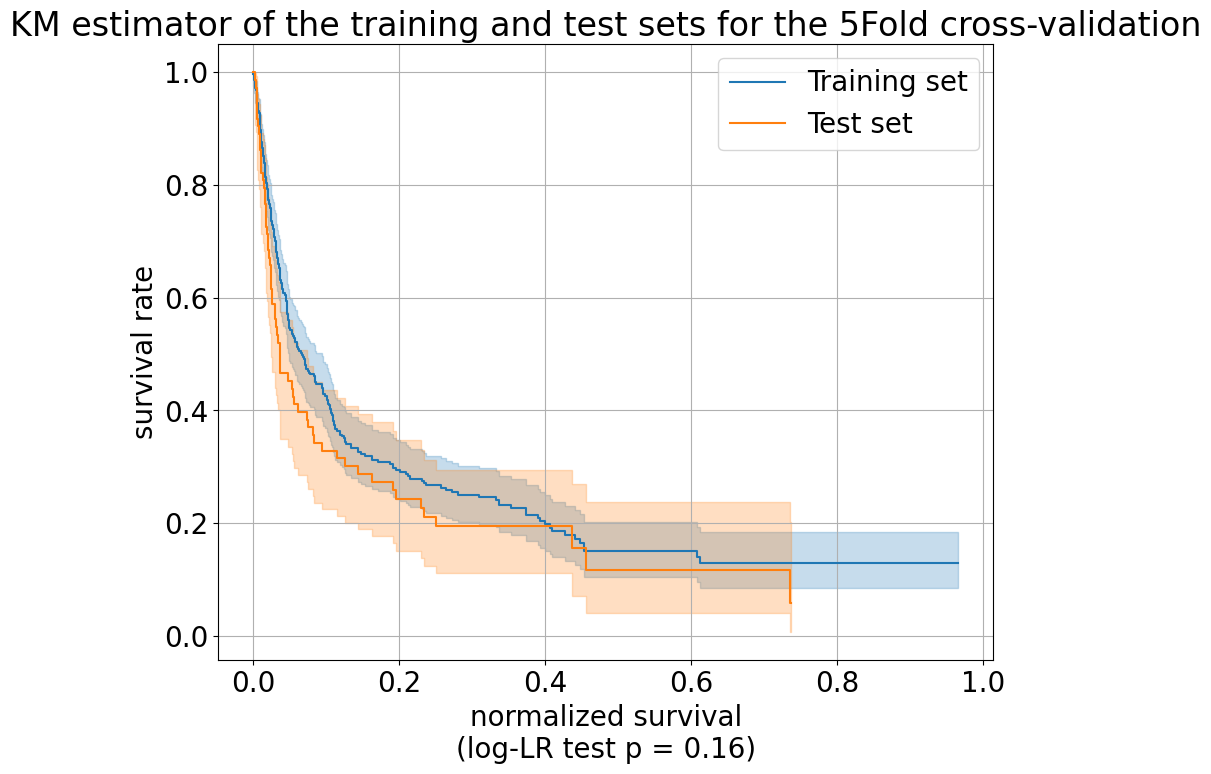

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
2         -0.096079   0.908392  0.145581       -0.381414        0.189255   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to        z  \
covariate                                                              
2                     0.682895             1.208349     0.0 -0.65997   

                  p  -log2(p)  
covariate                      
2          0.509273  0.973489  
<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 1
        test_name = log-likelihood ratio test

---
 test_statistic    p  -log2(p)
           0.44 0.51      0.98


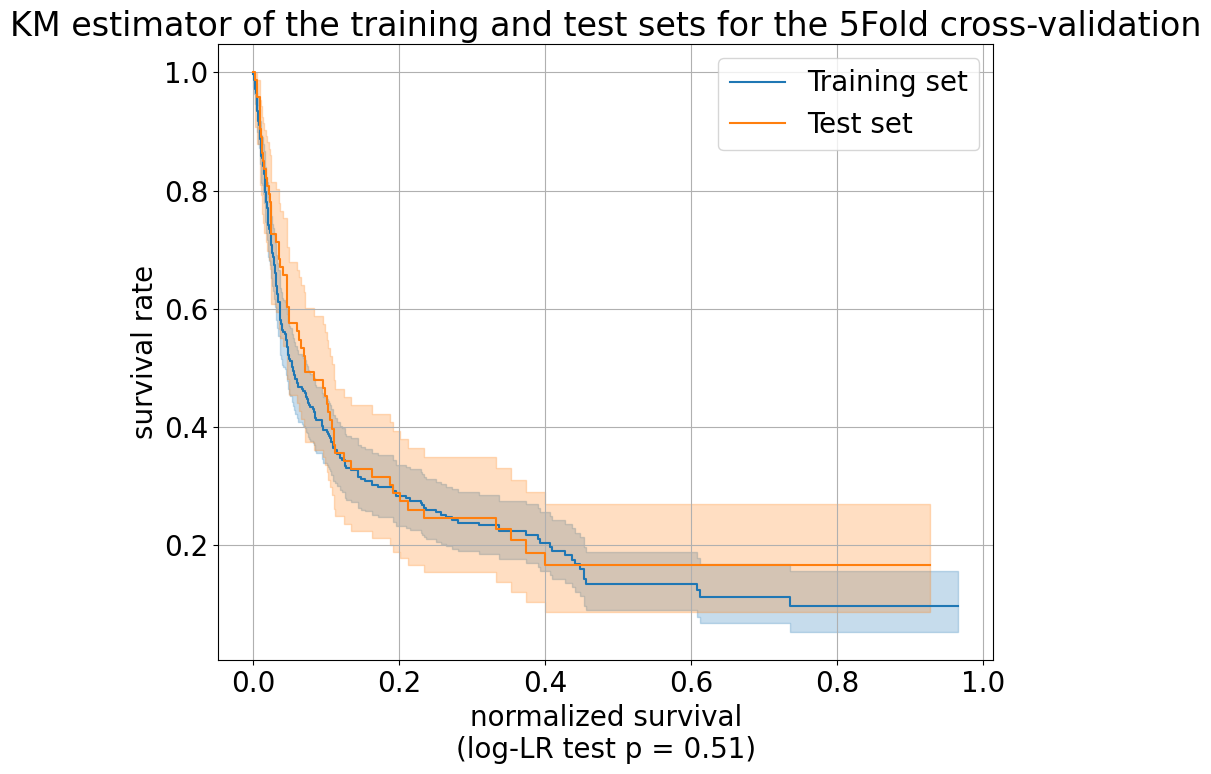

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
2         -0.158287   0.853604  0.146605       -0.445628        0.129054   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
2                     0.640422             1.137751     0.0 -1.079683   

                  p  -log2(p)  
covariate                      
2          0.280283  1.835043  
<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 1
        test_name = log-likelihood ratio test

---
 test_statistic    p  -log2(p)
           1.20 0.27      1.87


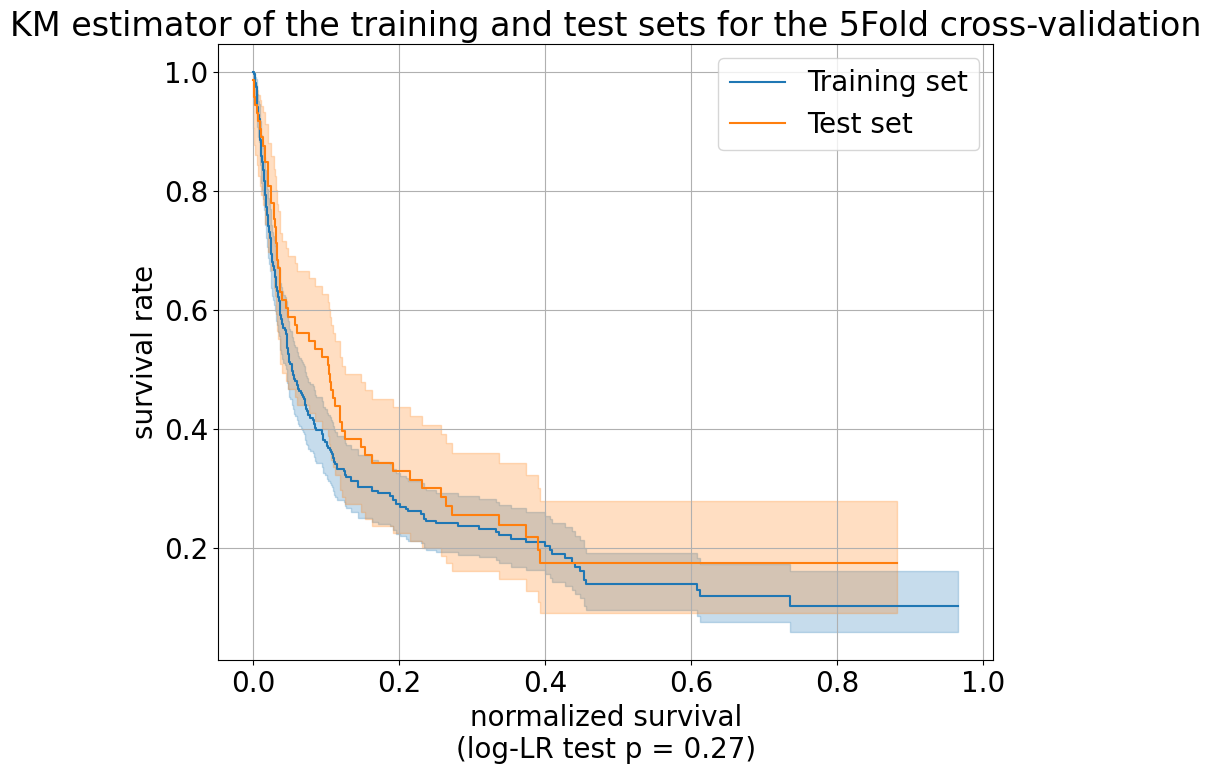

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
2         -0.003308   0.996698  0.146599       -0.290636        0.284021   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z      p  \
covariate                                                                      
2                     0.747788             1.328461     0.0 -0.022562  0.982   

           -log2(p)  
covariate            
2          0.026205  
<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 1
        test_name = log-likelihood ratio test

---
 test_statistic    p  -log2(p)
           0.00 0.98      0.03


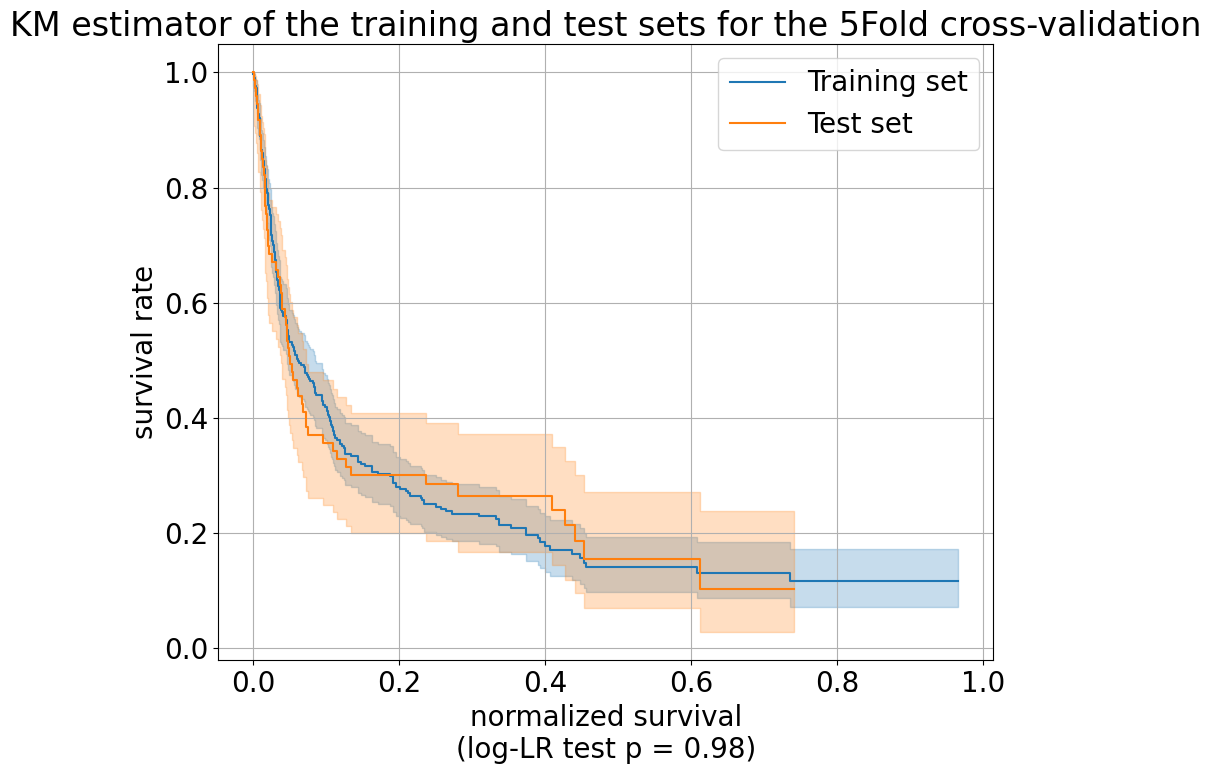

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
2          0.067102   1.069405  0.144656       -0.216419        0.350623   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
2                     0.805398             1.419952     0.0  0.463873   

                  p  -log2(p)  
covariate                      
2          0.642739  0.637696  
<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 1
        test_name = log-likelihood ratio test

---
 test_statistic    p  -log2(p)
           0.21 0.64      0.63


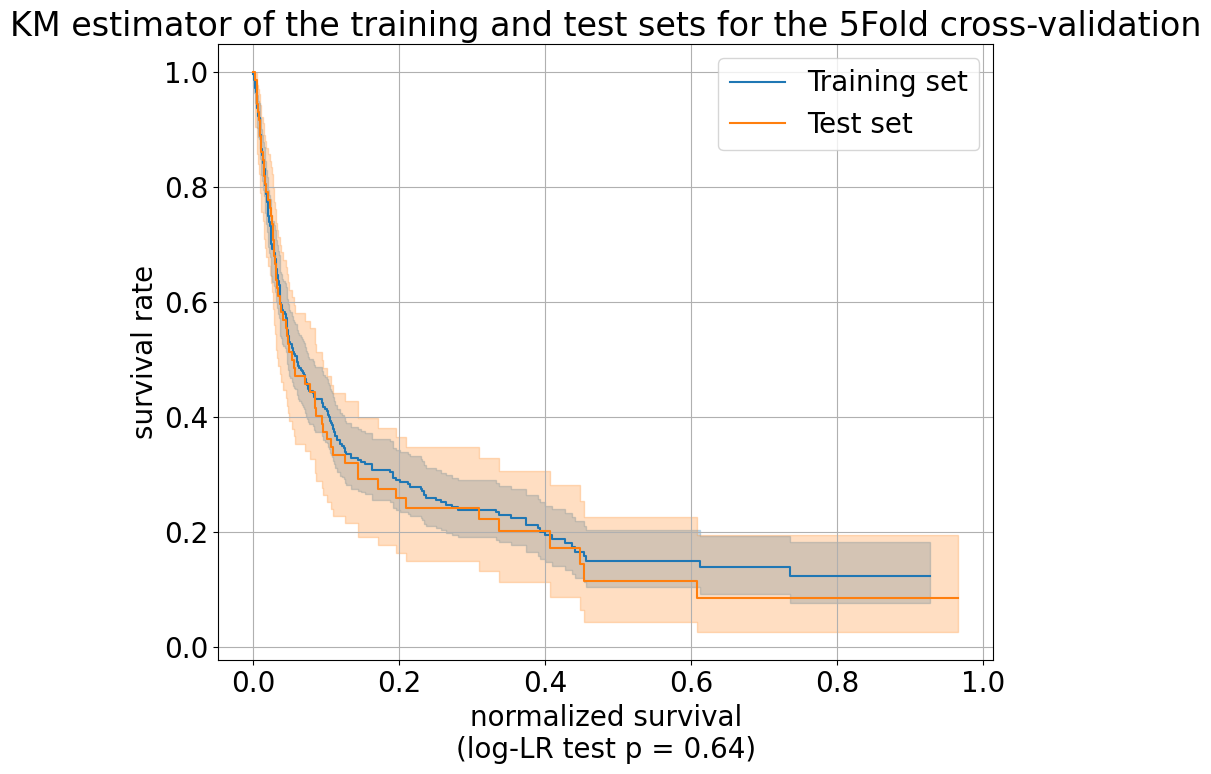

In [116]:
kf = KFold(n_splits=5,random_state=42,shuffle=True)
for train_index, test_index in kf.split(y_train):
    y_train_train, y_train_test = y_train[train_index], y_train[test_index]
    
    #COX analysis
    
    cox_test_df = pd.DataFrame(np.append(np.vstack([y_train_train,y_train_test]),np.hstack([np.zeros(len(y_train_train)).T,np.ones(len(y_train_test))]).reshape(-1,1),axis=1))

    cph = CoxPHFitter()
    cph.fit(df = cox_test_df,
            duration_col = 0,
            event_col = 1)

    print(cph.summary)

    #cph.check_assumptions(cox_test_df,show_plots=True,p_value_threshold=0.7)
    #plt.show()

    print(cph.log_likelihood_ratio_test())
    p_val = round(cph.log_likelihood_ratio_test().p_value,2)
    
    # KM Plot
    plt.figure(figsize=(10,8))
    kmf1 = KaplanMeierFitter(label="Training set")
    kmf1.fit(y_train_train[:,0], y_train_train[:,1])
    kmf1.plot()
    kmf2 = KaplanMeierFitter(label="Test set")
    kmf2.fit(y_train_test[:,0], y_train_test[:,1])
    kmf2.plot()
    plt.title("KM estimator of the training and test sets for the 5Fold cross-validation")
    plt.xlabel(f"normalized survival\n(log-LR test p = {p_val})")
    plt.ylabel("survival rate")
    plt.grid()
    plt.show()
    


# Censoring Sensitivity Analysis

In [16]:
# Dictionary where all the results can be saved
results_table = {"Model":[],
                 "Optimized_LogRank":[],
                 "T_max":[],
                 "Uncensored_Reduction":[],
                 "5Fold":{"HarrelC":{"mean":[],
                                     "std":[]},
                          "UnoC":{"mean":[],
                                  "std":[]},
                          "iBrier":{"mean":[],
                                    "std":[]},
                          "AUROC":{"mean":[],
                                   "std":[]},
                          "LogRank":{"mean":[],
                                     "std":[]}},
                 "Hold-out":{"HarrelC":[],
                             "UnoC":[],
                             "iBrier":[],
                             "AUROC":[],
                             "LogRank":[]},
                 "Timeline":[],
                 "Overall_Survival_Function":[]}

with open(f"Logs/{NAME}_results.json", "w") as write_file:
        json.dump(results_table, write_file)

## MDN Model

### Shared Parameters

In [11]:
from model import MDN
from utils import NLLLoss, CensoredNLLLoss, AlternativeNLLLoss
from csa import MDNCensoringSensitivityAnalysis

# Fixed
num_epochs = 200
batch_size = 128
input_shape = x_size
learning_rate = 1e-3

<frozen importlib._bootstrap>:228: RuntimeWarning: sklearn.tree._splitter.Splitter size changed, may indicate binary incompatibility. Expected 360 from C header, got 1160 from PyObject


### Use LogRank in Optimizer

In [ ]:
# Hyperparameters [Optimized]
n_hidden = 256
mixture_components = 5
use_sparse_layer = True
use_sparse_loss = False #Default
lmbd = 1e-4 #Default
use_batchnorm = False
use_dropout = True
dropout = 0.16282610152693927
mlp_size_1 = 3
mlp_size_2 = 1
mlp_size_3 = 0
kernel = "Normal"
loss_name = CensoredNLLLoss

# Properties
Model = MDN
model_name = "MDN"
Optimized_LogRank = True

MDNCSA = MDNCensoringSensitivityAnalysis(Model = Model,
                                         model_name = model_name,
                                         dataset_name = NAME,
                                         X = X,
                                         y = y,
                                         Optimized_LogRank = Optimized_LogRank)

MDNCSA.analyze(n_hidden = n_hidden,
               mixture_components = mixture_components,
               use_sparse_layer = use_sparse_layer,
               use_sparse_loss = use_sparse_loss,
               lmbd = lmbd,
               use_batchnorm = use_batchnorm,
               use_dropout = use_dropout,
               dropout = dropout,
               mlp_size_1 = mlp_size_1,
               mlp_size_2 = mlp_size_2,
               mlp_size_3 = mlp_size_3,
               kernel = kernel,
               loss_name = loss_name,
               num_epochs = num_epochs,
               batch_size = batch_size,
               input_shape = input_shape,
               learning_rate = learning_rate,
               timeline_resolution = timeline_resolution,
               sensitivity_grid = sensitivity_grid)

### Don't Use LogRank in Optimizer

In [ ]:
# Hyperparameters [Optimized]
n_hidden = 2048
mixture_components = 2
use_sparse_layer = False
use_sparse_loss = False
lmbd = 1e-4
use_batchnorm = False
use_dropout = True
dropout = 0.28300419815290545
mlp_size_1 = 3
mlp_size_2 = 3
mlp_size_3 = 1
kernel = "LogLogistic"
loss_name = CensoredNLLLoss

# Properties
Model = MDN
model_name = "MDN"
Optimized_LogRank = False

MDNCSA = MDNCensoringSensitivityAnalysis(Model = Model,
                                         model_name = model_name,
                                         dataset_name = NAME,
                                         X = X,
                                         y = y,
                                         Optimized_LogRank = Optimized_LogRank)

MDNCSA.analyze(n_hidden = n_hidden,
               mixture_components = mixture_components,
               use_sparse_layer = use_sparse_layer,
               use_sparse_loss = use_sparse_loss,
               lmbd = lmbd,
               use_batchnorm = use_batchnorm,
               use_dropout = use_dropout,
               dropout = dropout,
               mlp_size_1 = mlp_size_1,
               mlp_size_2 = mlp_size_2,
               mlp_size_3 = mlp_size_3,
               kernel = kernel,
               loss_name = loss_name,
               num_epochs = num_epochs,
               batch_size = batch_size,
               input_shape = input_shape,
               learning_rate = learning_rate,
               timeline_resolution = timeline_resolution,
               sensitivity_grid = sensitivity_grid)

### Compare LogRank vs. No LogRank

In [17]:
with open(f"Logs/{NAME}_results.json", "r") as read_file:
    results_table = json.load(read_file)

In [18]:
for i in range(len(results_table["Model"])):
    if (results_table["Model"][i] == "MDN") & (results_table["Optimized_LogRank"][i] == True) & (results_table["T_max"][i] == 1.0) & (results_table["Uncensored_Reduction"][i] == 1.0):
        tl_lr = np.array(results_table["Timeline"][i])
        osf_lr = np.array(results_table["Overall_Survival_Function"][i])

for i in range(len(results_table["Model"])):
    if (results_table["Model"][i] == "MDN") & (results_table["Optimized_LogRank"][i] == False) & (results_table["T_max"][i] == 1.0) & (results_table["Uncensored_Reduction"][i] == 1.0):
        tl_nlr = np.array(results_table["Timeline"][i])
        osf_nlr = np.array(results_table["Overall_Survival_Function"][i])

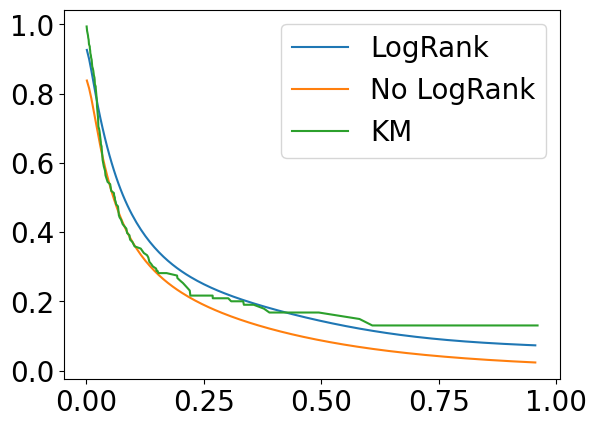

In [19]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
# Filter the test set for t > max(t_train), as these can cause problems for the scores (...)
t_max = min([max(y_train[:,0]),max(y_test[:,0])])
t_min = max([min(y_train[:,0]),min(y_test[:,0])])
mask = (t_min <= y_test[:,0]) & (y_test[:,0] <= t_max)
X_test = X_test[mask]
y_test = y_test[mask]

km_timeline, km_prob_survival = kaplan_meier_estimator(y_test[:,1].astype(bool),y_test[:,0])
plt.plot(tl_lr, osf_lr, label = "LogRank")
plt.plot(tl_nlr, osf_nlr, label = "No LogRank")
plt.plot(km_timeline,km_prob_survival, label = "KM")
plt.legend()
plt.show()

## Other Models

In [32]:
T_maxs = [1.0,0.75,0.5,0.25]
red_rates = [1.0,0.75,0.5,0.25]
sensitivity_grid = np.array(list(product(T_maxs,red_rates))) # [:,0] -> T_maxs, [:,1] -> red_rates

In [33]:
from csa import MLCensoringSensitivityAnalysis

### CPH

In [34]:
from sksurv.linear_model import CoxPHSurvivalAnalysis

#### Use LogRank in Optimizer

In [ ]:
# Hyperparams
alpha = 3.770957059564586
ties = "breslow"
n_iter = 2000

# Properties
Model = CoxPHSurvivalAnalysis
model_name = "CoxPH"
Optimized_LogRank = True

MLCSA = MLCensoringSensitivityAnalysis(Model = Model,
                                       model_name = model_name,
                                       X = X,
                                       y = y,
                                       Optimized_LogRank = Optimized_LogRank,
                                       alpha = alpha,
                                       ties = ties,
                                       n_iter = n_iter)

MLCSA.analyze(NAME = NAME,
              sensitivity_grid=sensitivity_grid)

#### Don't Use LogRank in Optimizer

In [ ]:
# Hyperparams
alpha = 3.773822021927384
ties = "breslow"
n_iter = 2000

# Properties
Model = CoxPHSurvivalAnalysis
model_name = "CoxPH"
Optimized_LogRank = False

MLCSA = MLCensoringSensitivityAnalysis(Model = Model,
                                       model_name = model_name,
                                       X = X,
                                       y = y,
                                       Optimized_LogRank = Optimized_LogRank,
                                       alpha = alpha,
                                       ties = ties,
                                       n_iter = n_iter)

MLCSA.analyze(NAME = NAME,
              sensitivity_grid=sensitivity_grid)

### Tree

In [37]:
from sksurv.tree import SurvivalTree

#### Use LogRank in Optimizer

In [ ]:
# Hyperparams
splitter = "best"
min_samples_split = 0.1450919885972804
min_samples_leaf = 0.009625987665255971
min_weight_fraction_leaf = 0.008849383628667822
max_features = 0.42417252129869437
random_state = 42

# Properties
Model = SurvivalTree
model_name = "SurvivalTree"
Optimized_LogRank = True

MLCSA = MLCensoringSensitivityAnalysis(Model = Model,
                                       model_name = model_name,
                                       X = X,
                                       y = y,
                                       Optimized_LogRank = Optimized_LogRank,
                                       splitter = splitter,
                                       min_samples_split = min_samples_split,
                                       min_samples_leaf = min_samples_leaf,
                                       min_weight_fraction_leaf = min_weight_fraction_leaf,
                                       max_features = max_features,
                                       random_state = random_state)

MLCSA.analyze(NAME = NAME,
              sensitivity_grid=sensitivity_grid)

#### Don't Use LogRank in Optimizer

In [ ]:
# Hyperparams
splitter = "best"
min_samples_split = 0.181488236332204
min_samples_leaf = 0.0015599524210311543
min_weight_fraction_leaf = 0.010651339121299435
max_features = 0.8065393331335484
random_state = 42

# Properties
Model = SurvivalTree
model_name = "SurvivalTree"
Optimized_LogRank = False

MLCSA = MLCensoringSensitivityAnalysis(Model = Model,
                                       model_name = model_name,
                                       X = X,
                                       y = y,
                                       Optimized_LogRank = Optimized_LogRank,
                                       splitter = splitter,
                                       min_samples_split = min_samples_split,
                                       min_samples_leaf = min_samples_leaf,
                                       min_weight_fraction_leaf = min_weight_fraction_leaf,
                                       max_features = max_features,
                                       random_state = random_state)

MLCSA.analyze(NAME = NAME,
              sensitivity_grid=sensitivity_grid)

### Forest

In [40]:
from sksurv.ensemble import RandomSurvivalForest

#### Use LogRank in Optimizer

In [ ]:
# Hyperparams
n_estimators = 279
min_samples_split = 0.025006137990311515
min_samples_leaf = 0.015172773137428505
min_weight_fraction_leaf = 0.0000023681978745946275
max_features = 0.24619583293237662
bootstrap = False
max_samples = 0.20801858860979464
oob_score = False
n_jobs = 10
random_state = 42

# Properties
Model = RandomSurvivalForest
model_name = "RandomSurvivalForest"
Optimized_LogRank = True

MLCSA = MLCensoringSensitivityAnalysis(Model = Model,
                                       model_name = model_name,
                                       X = X,
                                       y = y,
                                       Optimized_LogRank = Optimized_LogRank,
                                       n_estimators = n_estimators,
                                       min_samples_split = min_samples_split,
                                       min_samples_leaf = min_samples_leaf,
                                       min_weight_fraction_leaf = min_weight_fraction_leaf,
                                       max_features = max_features,
                                       bootstrap = bootstrap,
                                       max_samples = max_samples,
                                       oob_score = oob_score,
                                       n_jobs = n_jobs,
                                       random_state = random_state)

MLCSA.analyze(NAME = NAME,
              sensitivity_grid=sensitivity_grid)

#### Don't Use LogRank in Optimizer

In [ ]:
# Hyperparams
n_estimators = 751
min_samples_split = 0.0030070831372971387
min_samples_leaf = 0.0010468931871152973
min_weight_fraction_leaf = 0.0012233898828817584
max_features = 0.10263938614699752
bootstrap = False
max_samples = 0.331724336530432
oob_score = False
n_jobs = 10
random_state = 42

# Properties
Model = RandomSurvivalForest
model_name = "RandomSurvivalForest"
Optimized_LogRank = False

MLCSA = MLCensoringSensitivityAnalysis(Model = Model,
                                       model_name = model_name,
                                       X = X,
                                       y = y,
                                       Optimized_LogRank = Optimized_LogRank,
                                       n_estimators = n_estimators,
                                       min_samples_split = min_samples_split,
                                       min_samples_leaf = min_samples_leaf,
                                       min_weight_fraction_leaf = min_weight_fraction_leaf,
                                       max_features = max_features,
                                       bootstrap = bootstrap,
                                       max_samples = max_samples,
                                       oob_score = oob_score,
                                       n_jobs = n_jobs,
                                       random_state = random_state)

MLCSA.analyze(NAME = NAME,
              sensitivity_grid=sensitivity_grid)

### Boosting

In [43]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

#### Use LogRank in Optimizer

In [ ]:
# Hyperparams
loss="coxph"
learning_rate=0.001317427140431025
n_estimators=920
criterion="friedman_mse"
min_samples_split=2
min_samples_leaf=6
min_weight_fraction_leaf=0.010225982206401125
min_impurity_decrease=0.9526146434683818
max_features=0.2526227469550755
subsample=0.3453967050783214
dropout_rate=0.20825772436808648
ccp_alpha=0.002156682704769007
random_state = 42

# Properties
Model = GradientBoostingSurvivalAnalysis
model_name = "GradientBoosting"
Optimized_LogRank = True

MLCSA = MLCensoringSensitivityAnalysis(Model = Model,
                                       model_name = model_name,
                                       X = X,
                                       y = y,
                                       Optimized_LogRank = Optimized_LogRank,
                                       loss=loss,
                                       learning_rate=learning_rate,
                                       n_estimators=n_estimators,
                                       criterion=criterion,
                                       min_samples_split=min_samples_split,
                                       min_samples_leaf=min_samples_leaf,
                                       min_weight_fraction_leaf=min_weight_fraction_leaf,
                                       min_impurity_decrease=min_impurity_decrease,
                                       max_features=max_features,
                                       subsample=subsample,
                                       dropout_rate=dropout_rate,
                                       ccp_alpha=ccp_alpha,
                                       random_state=random_state)

MLCSA.analyze(NAME = NAME,
              sensitivity_grid=sensitivity_grid)

#### Don't Use LogRank in Optimizer

In [ ]:
# Hyperparams
loss="coxph"
learning_rate=0.07956477642784399
n_estimators=206
criterion="friedman_mse"
min_samples_split=9
min_samples_leaf=6
min_weight_fraction_leaf=0.0011495967608824292
min_impurity_decrease=0.6824661478957649
max_features=0.18202461798952774
subsample=0.6524917216713446
dropout_rate=0.025625229303524805
ccp_alpha=0.0016418287499199553
random_state = 42

# Properties
Model = GradientBoostingSurvivalAnalysis
model_name = "GradientBoosting"
Optimized_LogRank = False

MLCSA = MLCensoringSensitivityAnalysis(Model = Model,
                                       model_name = model_name,
                                       X = X,
                                       y = y,
                                       Optimized_LogRank = Optimized_LogRank,
                                       loss=loss,
                                       learning_rate=learning_rate,
                                       n_estimators=n_estimators,
                                       criterion=criterion,
                                       min_samples_split=min_samples_split,
                                       min_samples_leaf=min_samples_leaf,
                                       min_weight_fraction_leaf=min_weight_fraction_leaf,
                                       min_impurity_decrease=min_impurity_decrease,
                                       max_features=max_features,
                                       subsample=subsample,
                                       dropout_rate=dropout_rate,
                                       ccp_alpha=ccp_alpha,
                                       random_state=random_state)

MLCSA.analyze(NAME = NAME,
              sensitivity_grid=sensitivity_grid)

# Results

In [117]:
with open(f"Logs/{NAME}_results.json", "r") as read_file:
    results_table = json.load(read_file)

## 5-Fold

In [118]:
# 5FOLD

models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
opts = [True,False]
trials = list(product(models,opts))

main_results_5fold  = {"Model":[],
                       "c-index $\\uparrow$":[],
                       "iBrier $\\downarrow$":[],
                       "AUROC $\\uparrow$":[],
                       "LogRank $\\uparrow$":[]}

for trial in trials:
    for i in range(len(results_table["Model"])):
        if (results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1]) & (results_table["T_max"][i] == 1.0) & (results_table["Uncensored_Reduction"][i] == 1.0):
            main_results_5fold["Model"].append(f"{trial[0]} " + ["$^{^{LogRank}}$" if trial[1] == True else ""][0])
            main_results_5fold["c-index $\\uparrow$"].append( str(round(results_table["5Fold"]["UnoC"]["mean"][i],4)).ljust(6,"0") +"$\pm$" + str(round(1.96*results_table["5Fold"]["UnoC"]["std"][i]/np.sqrt(5),4)).ljust(6,"0") )
            main_results_5fold["iBrier $\\downarrow$"].append( str(round(results_table["5Fold"]["iBrier"]["mean"][i],4)).ljust(6,"0") +"$\pm$" + str(round(1.96*results_table["5Fold"]["iBrier"]["std"][i]/np.sqrt(5),4)).ljust(6,"0") )
            main_results_5fold["AUROC $\\uparrow$"].append( str(round(results_table["5Fold"]["AUROC"]["mean"][i],4)).ljust(6,"0") +" $\pm$" + str(round(1.96*results_table["5Fold"]["AUROC"]["std"][i]/np.sqrt(5),4)).ljust(6,"0") )
            main_results_5fold["LogRank $\\uparrow$"].append( str(round(results_table["5Fold"]["LogRank"]["mean"][i],4)).ljust(6,"0") +" $\pm$" + str(round(1.96*results_table["5Fold"]["LogRank"]["std"][i]/np.sqrt(5),4)).ljust(6,"0") )
            
main_results_5fold = pd.DataFrame.from_dict(main_results_5fold)

In [119]:
main_results_5fold

Model c-index $\uparrow$  \
0                 CoxPH $^{^{LogRank}}$  0.6718$\pm$0.0278   
1                                CoxPH   0.6718$\pm$0.0278   
2          SurvivalTree $^{^{LogRank}}$  0.6681$\pm$0.0302   
3                         SurvivalTree   0.6612$\pm$0.0366   
4  RandomSurvivalForest $^{^{LogRank}}$  0.6823$\pm$0.0280   
5                 RandomSurvivalForest   0.6908$\pm$0.0306   
6      GradientBoosting $^{^{LogRank}}$  0.6699$\pm$0.0251   
7                     GradientBoosting   0.6750$\pm$0.0267   
8                   MDN $^{^{LogRank}}$  0.6758$\pm$0.0303   
9                                  MDN   0.6504$\pm$0.0489   

  iBrier $\downarrow$    AUROC $\uparrow$  LogRank $\uparrow$  
0   0.1461$\pm$0.0321  0.7271 $\pm$0.0465  0.6022 $\pm$0.1338  
1   0.1461$\pm$0.0321  0.7271 $\pm$0.0465  0.6022 $\pm$0.1338  
2   0.1522$\pm$0.0224  0.7096 $\pm$0.0402  0.6360 $\pm$0.2454  
3   0.1574$\pm$0.0377  0.6949 $\pm$0.0498  0.4133 $\pm$0.1963  
4   0.1422$\pm$0.0254  0.7361 $\pm$0.0543  0.6179 $\pm$0.2107  
5   0.1432$\pm$0.0272  0.7515 $\pm$0.0453  0.5659 $\pm$0.1810  
6   0.1692$\pm$0.0182  0.7359 $\pm$0.0439  0.4684 $\pm$0.1416  
7   0.1493$\pm$0.0262  0.7391 $\pm$0.0507  0.5648 $\pm$0.2057  
8   0.1477$\pm$0.0330  0.8165 $\pm$0.0375  0.4052 $\pm$0.2352  
9   0.1459$\pm$0.0349  0.7725 $\pm$0.0717  0.3701 $\pm$0.1141

In [120]:
print(main_results_5fold.style.hide(axis="index").to_latex(hrules=True))

\begin{tabular}{lllll}
\toprule
Model & c-index $\uparrow$ & iBrier $\downarrow$ & AUROC $\uparrow$ & LogRank $\uparrow$ \\
\midrule
CoxPH $^{^{LogRank}}$ & 0.6718$\pm$0.0278 & 0.1461$\pm$0.0321 & 0.7271 $\pm$0.0465 & 0.6022 $\pm$0.1338 \\
CoxPH  & 0.6718$\pm$0.0278 & 0.1461$\pm$0.0321 & 0.7271 $\pm$0.0465 & 0.6022 $\pm$0.1338 \\
SurvivalTree $^{^{LogRank}}$ & 0.6681$\pm$0.0302 & 0.1522$\pm$0.0224 & 0.7096 $\pm$0.0402 & 0.6360 $\pm$0.2454 \\
SurvivalTree  & 0.6612$\pm$0.0366 & 0.1574$\pm$0.0377 & 0.6949 $\pm$0.0498 & 0.4133 $\pm$0.1963 \\
RandomSurvivalForest $^{^{LogRank}}$ & 0.6823$\pm$0.0280 & 0.1422$\pm$0.0254 & 0.7361 $\pm$0.0543 & 0.6179 $\pm$0.2107 \\
RandomSurvivalForest  & 0.6908$\pm$0.0306 & 0.1432$\pm$0.0272 & 0.7515 $\pm$0.0453 & 0.5659 $\pm$0.1810 \\
GradientBoosting $^{^{LogRank}}$ & 0.6699$\pm$0.0251 & 0.1692$\pm$0.0182 & 0.7359 $\pm$0.0439 & 0.4684 $\pm$0.1416 \\
GradientBoosting  & 0.6750$\pm$0.0267 & 0.1493$\pm$0.0262 & 0.7391 $\pm$0.0507 & 0.5648 $\pm$0.2057 \\
MDN $

## Hold-out

In [121]:
# HOLD-OUT

models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
opts = [True,False]
trials = list(product(models,opts))

main_results_hold_out  = {"Model":[],
                          "c-index $\\uparrow$":[],
                          "iBrier $\\downarrow$":[],
                          "AUROC $\\uparrow$":[],
                          "LogRank $\\uparrow$":[]}

for trial in trials:
    for i in range(len(results_table["Model"])):
        if (results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1]) & (results_table["T_max"][i] == 1.0) & (results_table["Uncensored_Reduction"][i] == 1.0):
            main_results_hold_out["Model"].append(f"{trial[0]} " + ["$^{^{LogRank}}$" if trial[1] == True else ""][0])
            main_results_hold_out["c-index $\\uparrow$"].append( str(round(results_table["Hold-out"]["UnoC"][i],4)).ljust(6,"0") )
            main_results_hold_out["iBrier $\\downarrow$"].append( str(round(results_table["Hold-out"]["iBrier"][i],4)).ljust(6,"0") )
            main_results_hold_out["AUROC $\\uparrow$"].append( str(round(results_table["Hold-out"]["AUROC"][i],4)).ljust(6,"0") )
            main_results_hold_out["LogRank $\\uparrow$"].append( str(round(results_table["Hold-out"]["LogRank"][i],4)).ljust(6,"0") )
            
main_results_hold_out = pd.DataFrame.from_dict(main_results_hold_out)

In [122]:
main_results_hold_out

Model c-index $\uparrow$  \
0                 CoxPH $^{^{LogRank}}$             0.7021   
1                                CoxPH              0.7021   
2          SurvivalTree $^{^{LogRank}}$             0.6523   
3                         SurvivalTree              0.6444   
4  RandomSurvivalForest $^{^{LogRank}}$             0.6948   
5                 RandomSurvivalForest              0.7002   
6      GradientBoosting $^{^{LogRank}}$             0.7026   
7                     GradientBoosting              0.6965   
8                   MDN $^{^{LogRank}}$             0.7061   
9                                  MDN              0.7182   

  iBrier $\downarrow$ AUROC $\uparrow$ LogRank $\uparrow$  
0              0.1341           0.7599             0.1379  
1              0.1341           0.7599             0.1379  
2              0.1767           0.7008             0.1602  
3              0.1553           0.6785             0.0267  
4              0.1293           0.7456             0.3303  
5              0.1213           0.7644             0.5404  
6              0.1554           0.7623             0.4678  
7              0.1376           0.7564             0.3229  
8              0.1314           0.6548             0.0555  
9              0.1290           0.6655             0.0250

In [123]:
print(main_results_hold_out.style.hide(axis="index").to_latex(hrules=True))

\begin{tabular}{lllll}
\toprule
Model & c-index $\uparrow$ & iBrier $\downarrow$ & AUROC $\uparrow$ & LogRank $\uparrow$ \\
\midrule
CoxPH $^{^{LogRank}}$ & 0.7021 & 0.1341 & 0.7599 & 0.1379 \\
CoxPH  & 0.7021 & 0.1341 & 0.7599 & 0.1379 \\
SurvivalTree $^{^{LogRank}}$ & 0.6523 & 0.1767 & 0.7008 & 0.1602 \\
SurvivalTree  & 0.6444 & 0.1553 & 0.6785 & 0.0267 \\
RandomSurvivalForest $^{^{LogRank}}$ & 0.6948 & 0.1293 & 0.7456 & 0.3303 \\
RandomSurvivalForest  & 0.7002 & 0.1213 & 0.7644 & 0.5404 \\
GradientBoosting $^{^{LogRank}}$ & 0.7026 & 0.1554 & 0.7623 & 0.4678 \\
GradientBoosting  & 0.6965 & 0.1376 & 0.7564 & 0.3229 \\
MDN $^{^{LogRank}}$ & 0.7061 & 0.1314 & 0.6548 & 0.0555 \\
MDN  & 0.7182 & 0.1290 & 0.6655 & 0.0250 \\
\bottomrule
\end{tabular}



## Main result - Plots

In [124]:
models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
colors = ["green","purple","orange","red","blue"]
opts = [True,False]
typs = ["5Fold","Hold-out"]
scores = ["UnoC","iBrier","AUROC","LogRank"]
trials = list(product(models,opts,typs,scores))

main_results_plot  = {"Model":[],
                      "Color":[],
                      "Type":[],
                      "Score":[],
                      "mean":[],
                      "std":[]}

for trial in trials:
    main_results_plot["Model"].append(f"{trial[0]} " + ["$^{^{LogRank}}$" if trial[1] == True else ""][0])
    main_results_plot["Color"].append([item[1] for item in zip(models,colors) if item[0] == trial[0]][0])
    main_results_plot["Type"].append(trial[2])
    if trial[3] == "iBrier":
        main_results_plot["Score"].append("$\\leftarrow$ " + trial[3])
    else:
        main_results_plot["Score"].append(trial[3] + " $\\rightarrow$")
    for i in range(len(results_table["Model"])):
        if (results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1]) & (results_table["T_max"][i] == 1.0) & (results_table["Uncensored_Reduction"][i] == 1.0):
            if trial[2] == "5Fold":
                main_results_plot["mean"].append(results_table[trial[2]][trial[3]]["mean"][i])
                main_results_plot["std"].append(1.96*results_table[trial[2]][trial[3]]["std"][i]/np.sqrt(5))
            else:
                main_results_plot["mean"].append(results_table[trial[2]][trial[3]][i])
                main_results_plot["std"].append(0)
            
main_results_plot = pd.DataFrame.from_dict(main_results_plot)

### 5Fold

C:\Users\kutato17\AppData\Local\Temp\4\ipykernel_10764\764695248.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")
C:\Users\kutato17\AppData\Local\Temp\4\ipykernel_10764\764695248.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")
C:\Users\kutato17\AppData\Local\Temp\4\ipykernel_10764\764695248.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")
C:\Users\kutato17\AppData\Local\Temp\4\ipykernel_10764\764695248.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")


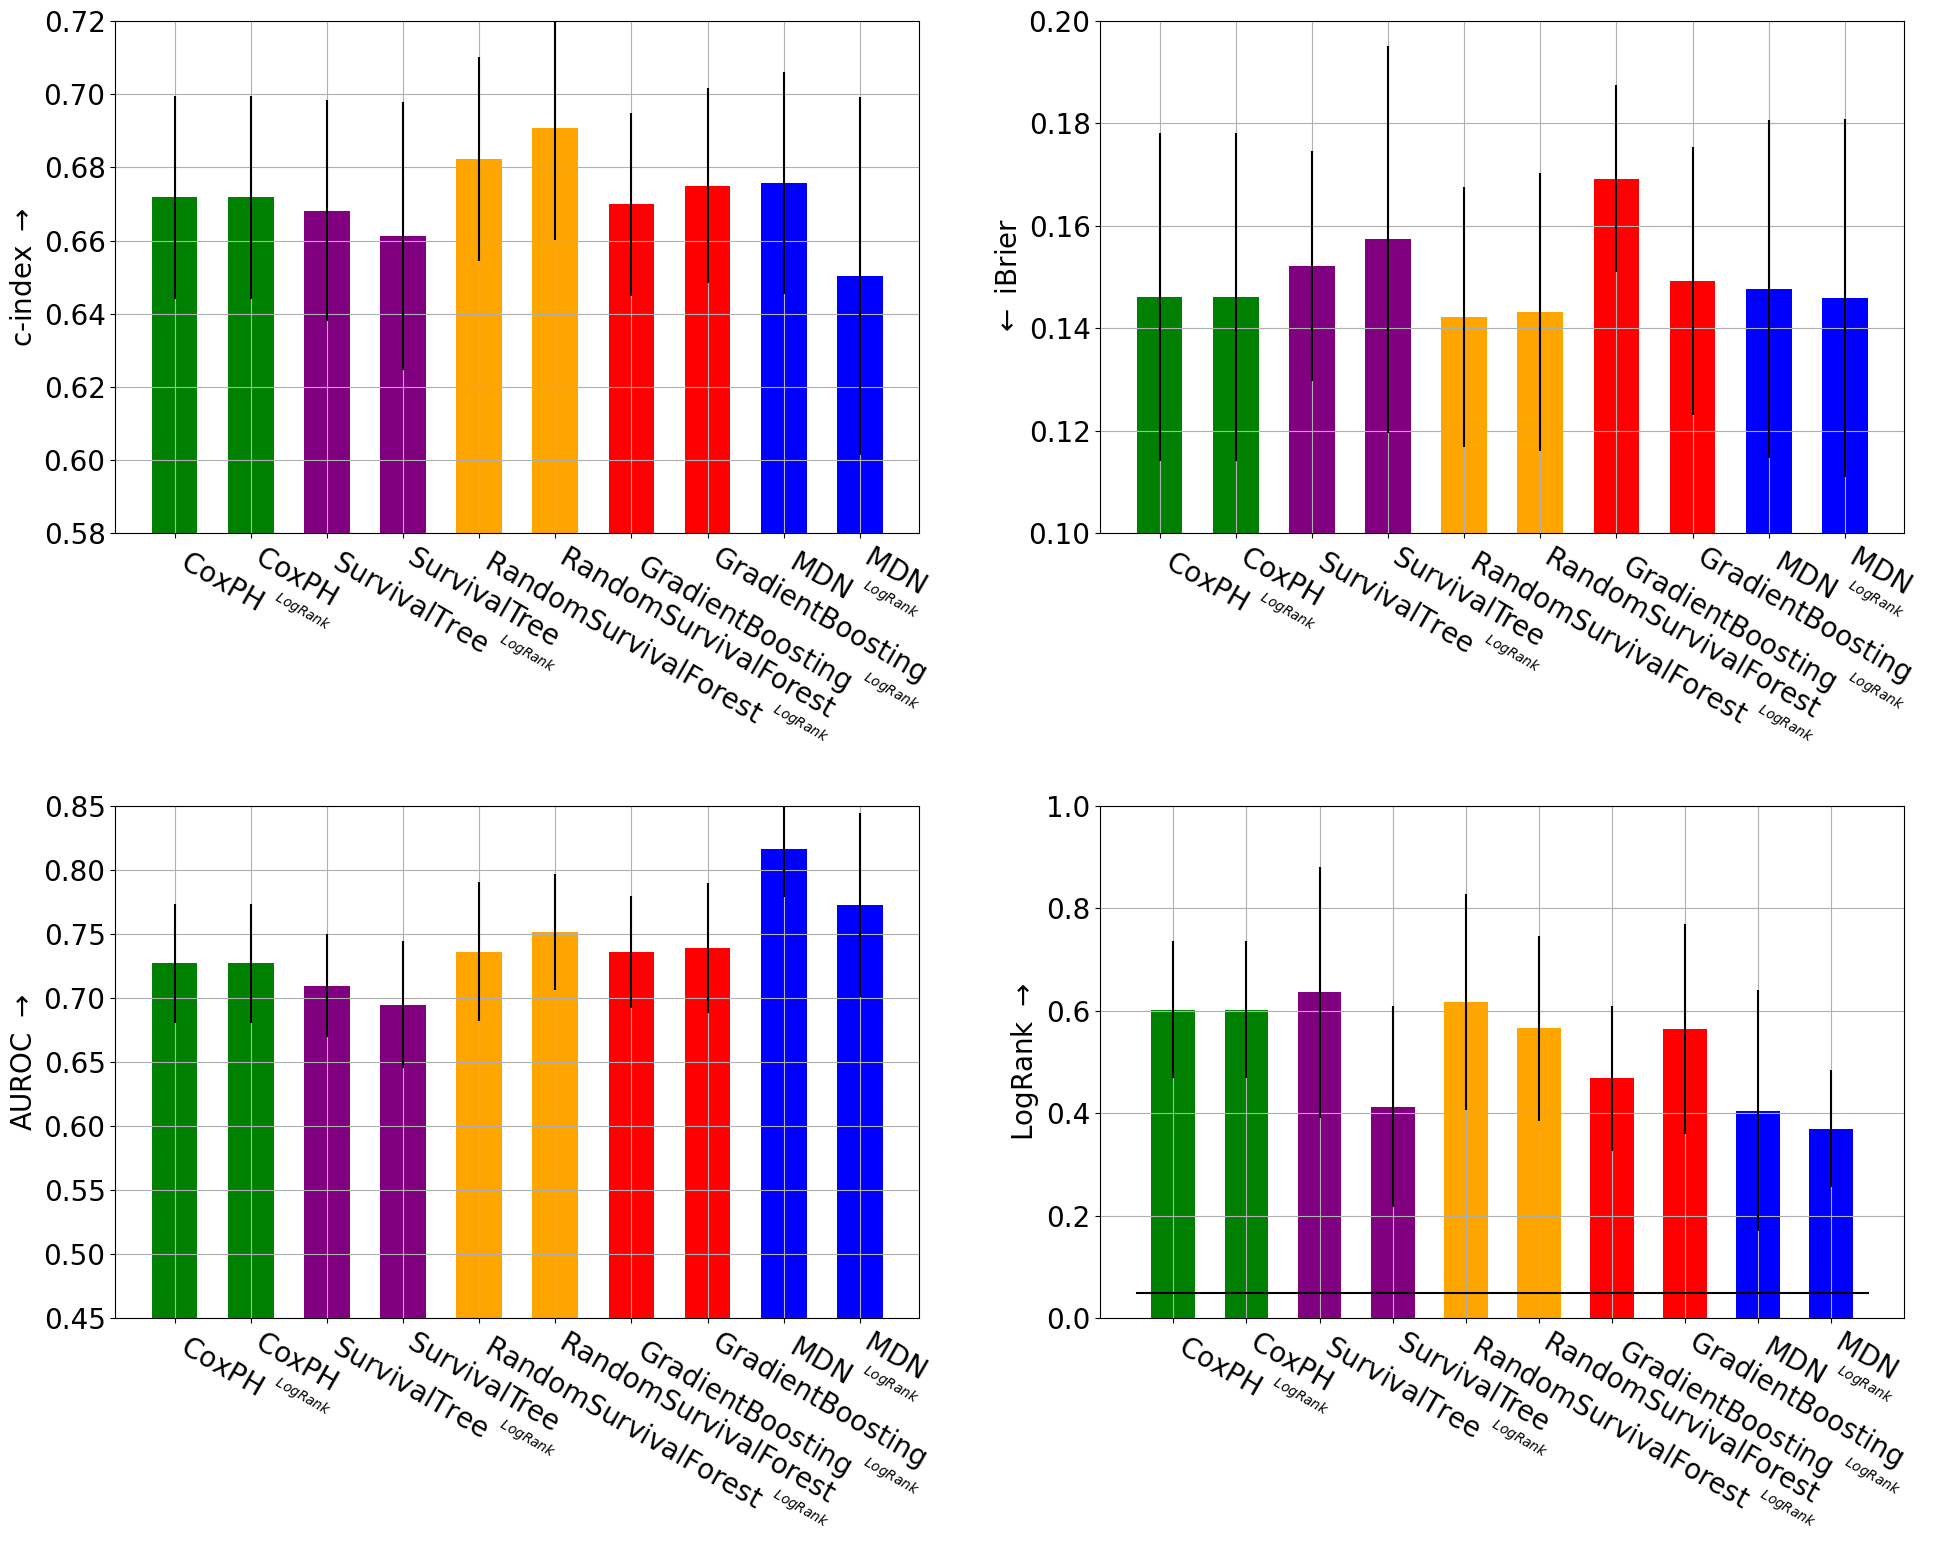

In [125]:
typ = "5Fold"

fig, axs = plt.subplots(2,2,figsize=(20,16))
scores = ["UnoC $\\rightarrow$","$\\leftarrow$ iBrier","AUROC $\\rightarrow$","LogRank $\\rightarrow$"]
locs = [[0,0],[0,1],[1,0],[1,1]]
ylims = [[0.58,0.72],[0.1,0.2],[0.45,0.85],[0,1]]

for scr,loc,ylim in zip(scores,locs,ylims):
    for _,row in main_results_plot[(main_results_plot.Type == typ) & (main_results_plot.Score == scr)].iterrows():
        b = axs[loc[0]][loc[1]].bar(row.Model, height = row["mean"],width = 0.6, yerr = row["std"], color = row.Color)  
    if scr == "LogRank $\\rightarrow$":
        #axs[loc[0]][loc[1]].set_yscale("log")
        axs[loc[0]][loc[1]].plot(np.linspace(-0.5,9.5,100),0.05*np.ones(100),marker = "", color = "black", label = "LogRank success > 0.05")
    #axs[loc[0]][loc[1]].tick_params(axis='x', labelrotation=-45, length = 40)
    axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")
    if scr == "UnoC $\\rightarrow$":
        axs[loc[0]][loc[1]].set_ylabel("c-index $\\rightarrow$")
    else:
        axs[loc[0]][loc[1]].set_ylabel(scr)
    axs[loc[0]][loc[1]].set_ylim((ylim[0],ylim[1]))
    axs[loc[0]][loc[1]].grid("x")

#_ = fig.suptitle(f"{NAME_PLOT} advantage of LogRank optimization {typ} scores")
fig.tight_layout()

### Hold-out

C:\Users\kutato17\AppData\Local\Temp\4\ipykernel_10764\1701139873.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")
C:\Users\kutato17\AppData\Local\Temp\4\ipykernel_10764\1701139873.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")
C:\Users\kutato17\AppData\Local\Temp\4\ipykernel_10764\1701139873.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")
C:\Users\kutato17\AppData\Local\Temp\4\ipykernel_10764\1701139873.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")


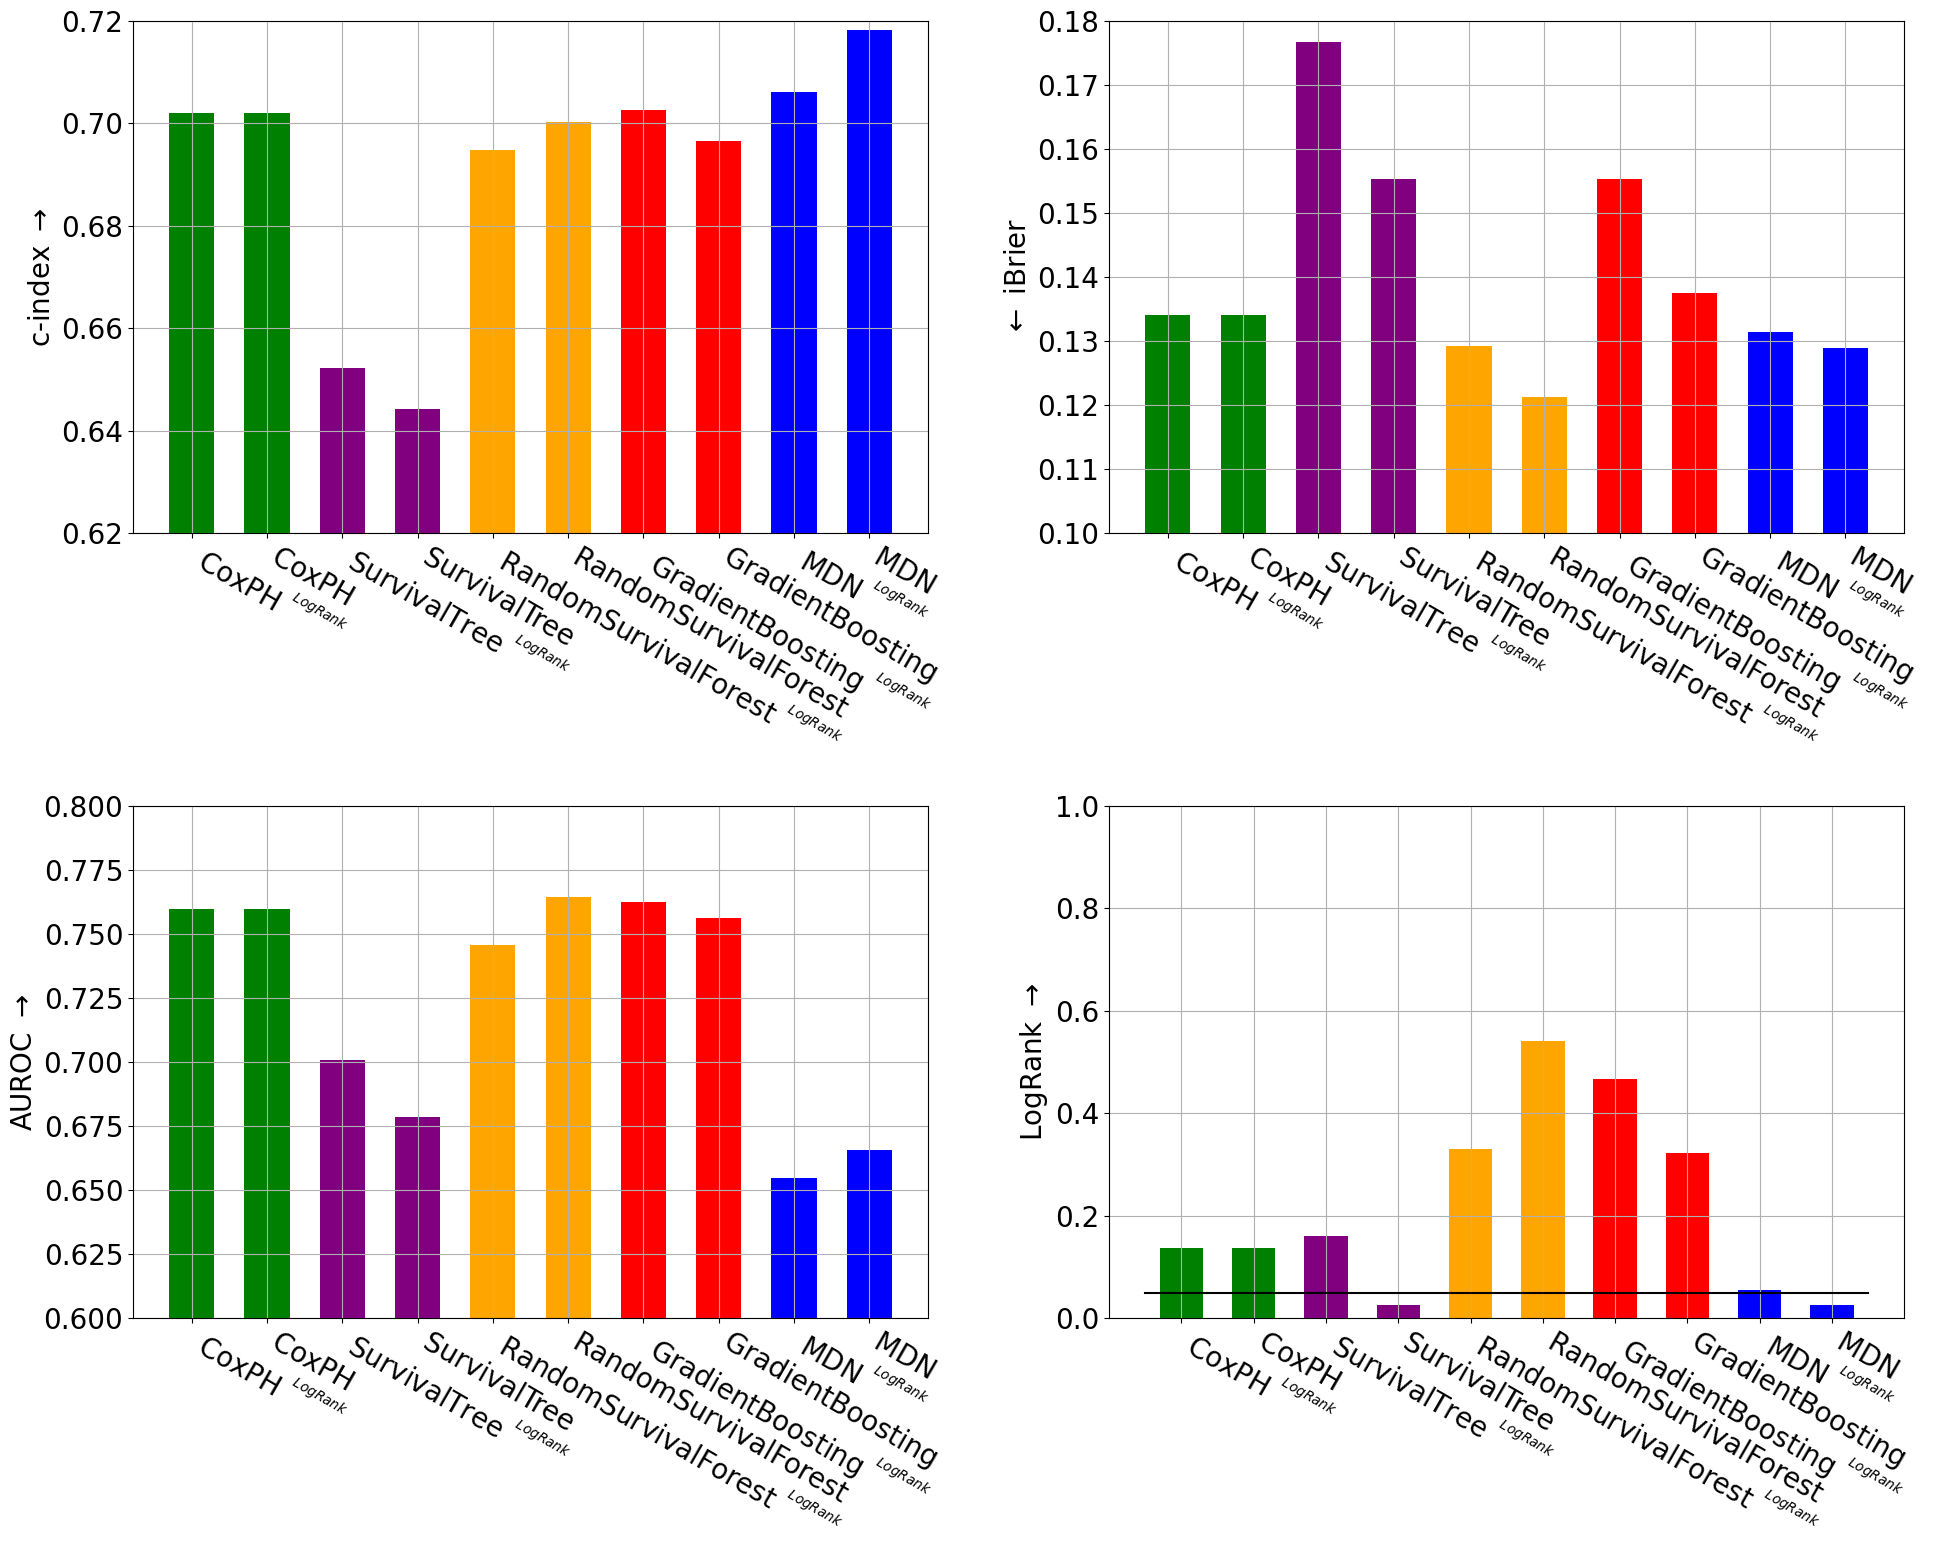

In [126]:
typ = "Hold-out"

fig, axs = plt.subplots(2,2,figsize=(20,16))
scores = ["UnoC $\\rightarrow$","$\\leftarrow$ iBrier","AUROC $\\rightarrow$","LogRank $\\rightarrow$"]
locs = [[0,0],[0,1],[1,0],[1,1]]
ylims = [[0.62,0.72],[0.1,0.18],[0.6,0.8],[0,1]]

for scr,loc,ylim in zip(scores,locs,ylims):
    for _,row in main_results_plot[(main_results_plot.Type == typ) & (main_results_plot.Score == scr)].iterrows():
        b = axs[loc[0]][loc[1]].bar(row.Model, height = row["mean"],width = 0.6, yerr = row["std"], color = row.Color)  
    if scr == "LogRank $\\rightarrow$":
        #axs[loc[0]][loc[1]].set_yscale("log")
        axs[loc[0]][loc[1]].plot(np.linspace(-0.5,9.5,100),0.05*np.ones(100),marker = "", color = "black", label = "LogRank success > 0.05")
    #axs[loc[0]][loc[1]].tick_params(axis='x', labelrotation=-45)
    axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")
    if scr == "UnoC $\\rightarrow$":
        axs[loc[0]][loc[1]].set_ylabel("c-index $\\rightarrow$")
    else:
        axs[loc[0]][loc[1]].set_ylabel(scr)
    axs[loc[0]][loc[1]].set_ylim((ylim[0],ylim[1]))
    axs[loc[0]][loc[1]].grid("x")

#_ = fig.suptitle(f"{NAME_PLOT} advantage of LogRank optimization {typ} scores")
fig.tight_layout()#rect=[0, 0.03, 1, 0.99])

## Compare Survival functions

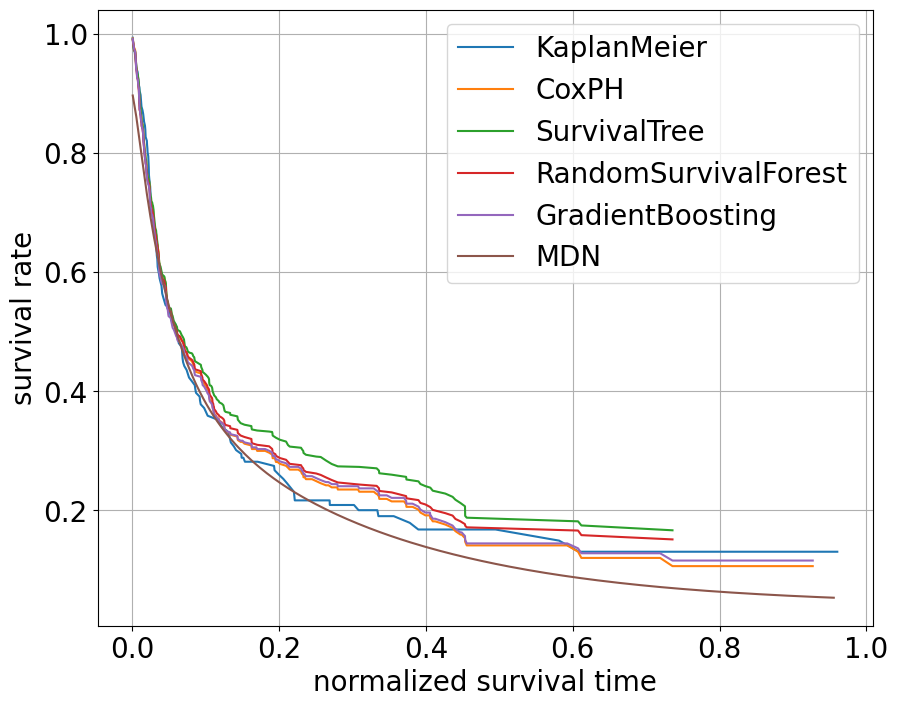

In [127]:
models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
opts = [True]
trials = list(product(models,opts))

compare_survival  = {"Model":[],
                     "Timeline":[],
                     "Survival_Function":[]}

for trial in trials:
    for i in range(len(results_table["Model"])):
        if (results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1]) & (results_table["T_max"][i] == 1.0) & (results_table["Uncensored_Reduction"][i] == 1.0):
            compare_survival["Model"].append(f"{trial[0]}")
            compare_survival["Timeline"].append(results_table["Timeline"][i])
            compare_survival["Survival_Function"].append(results_table["Overall_Survival_Function"][i])
            

plt.figure(figsize=(10,8))
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
# Filter the test set for t > max(t_train), as these can cause problems for the scores (...)
t_max = min([max(y_train[:,0]),max(y_test[:,0])])
t_min = max([min(y_train[:,0]),min(y_test[:,0])])
mask = (t_min <= y_test[:,0]) & (y_test[:,0] <= t_max)
X_test = X_test[mask]
y_test = y_test[mask]
km_timeline, km_prob_survival = kaplan_meier_estimator(y_test[:,1].astype(bool),y_test[:,0])
plt.plot(km_timeline,km_prob_survival, label = "KaplanMeier")

for i in range(len(compare_survival["Model"])):
    plt.plot(compare_survival["Timeline"][i], compare_survival["Survival_Function"][i], label = compare_survival["Model"][i])
plt.legend()
plt.grid()
#plt.title(f"Survival rate estimate for the population of the {NAME_PLOT} hold-out set")
plt.xlabel("normalized survival time")
plt.ylabel("survival rate")
#plt.xscale("log")
#plt.yscale("log")
plt.show()

## Sensitivity analysis
### Stratify by Score & Quantile

In [128]:
models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
colors = ["green","purple","orange","red","blue"]
opts = [True]
T_maxs = [0.25,0.5,0.75,1.0]
typs = ["5Fold","Hold-out"]
scores = ["UnoC","iBrier","AUROC","LogRank"]
trials = list(product(models,opts,T_maxs,typs,scores))

sensitivity_analysis_  = {"Model":[],
                         "Color":[],
                         "Legend":[],
                         "Type":[],
                         "Score":[],
                         "T_max":[],
                         "Ts":[],
                         "means":[],
                         "stds":[]}

for trial in trials:
    sensitivity_analysis_["Model"].append(trial[0])
    sensitivity_analysis_["Color"].append([item[1] for item in zip(models,colors) if item[0] == trial[0]][0])
    sensitivity_analysis_["Legend"].append(trial[0])
    sensitivity_analysis_["Type"].append(trial[3])
    if trial[4] == "iBrier":
        sensitivity_analysis_["Score"].append("$\\leftarrow$ " + trial[4])
    else:
        sensitivity_analysis_["Score"].append(trial[4] + " $\\rightarrow$")
    sensitivity_analysis_["T_max"].append(trial[2])

    ts = []
    means = []
    stds = []
    for i in range(len(results_table["Model"])):
        if (results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1]) & (results_table["T_max"][i] == trial[2]):
            ts.append([(results_table["Uncensored_Reduction"][i]-0.05) if results_table["Model"][i] == "CoxPH" else
                       (results_table["Uncensored_Reduction"][i]-0.025) if results_table["Model"][i] == "SurvivalTree" else
                       (results_table["Uncensored_Reduction"][i]) if results_table["Model"][i] == "RandomSurvivalForest" else
                       (results_table["Uncensored_Reduction"][i]+0.025) if results_table["Model"][i] == "GradientBoosting" else
                       (results_table["Uncensored_Reduction"][i]+0.05) if results_table["Model"][i] == "MDN" else
                       results_table["Uncensored_Reduction"][i]
                      ][0])

            if trial[3] == "5Fold":
                means.append(results_table[trial[3]][trial[4]]["mean"][i])
                stds.append(1.96*results_table[trial[3]][trial[4]]["std"][i]/np.sqrt(5))
            else:
                means.append(results_table[trial[3]][trial[4]][i])
                stds.append(0)

    sensitivity_analysis_["Ts"].append(ts)
    sensitivity_analysis_["means"].append(means)
    sensitivity_analysis_["stds"].append(stds)

sensitivity_analysis_ = pd.DataFrame.from_dict(sensitivity_analysis_)

### Heatmap

In [145]:
models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
colors = ["Green","Purple","Orange","Red","Blue"]
markers = ["o","v","s","D","*"]
opts = [True]
typs = ["5Fold","Hold-out"]
scores = ["UnoC","iBrier","AUROC","LogRank"]
trials = list(product(models,opts,typs,scores))

sensitivity_analysis_heatmap  = {"Model":[],
                         "Color":[],
                         "Marker":[],
                         "Type":[],
                         "Score":[],
                         "xs":[],
                         "ys":[],
                         "means":[],
                         "stds":[]}

for trial in trials:
    sensitivity_analysis_heatmap["Model"].append(trial[0])
    sensitivity_analysis_heatmap["Color"].append([item[1] for item in zip(models,colors) if item[0] == trial[0]][0])
    sensitivity_analysis_heatmap["Marker"].append([item[1] for item in zip(models,markers) if item[0] == trial[0]][0])
    sensitivity_analysis_heatmap["Type"].append(trial[2])
    if trial[3] == "iBrier":
        sensitivity_analysis_heatmap["Score"].append("$\\leftarrow$ " + trial[3])
    else:
        sensitivity_analysis_heatmap["Score"].append(trial[3] + " $\\rightarrow$")
    #colors = []
    xs = []
    ys = []
    means = []
    stds = []
    for i in range(len(results_table["Model"])):
        if ((results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1])):
            xs.append(results_table["Uncensored_Reduction"][i])
            ys.append(results_table["T_max"][i])
            if trial[2] == "5Fold":
                means.append(results_table[trial[2]][trial[3]]["mean"][i])
                stds.append(1.96*results_table[trial[2]][trial[3]]["std"][i]/np.sqrt(5))
            else:
                means.append(results_table[trial[2]][trial[3]][i])
                stds.append(0)

    sensitivity_analysis_heatmap["xs"].append(xs)
    sensitivity_analysis_heatmap["ys"].append(ys)
    sensitivity_analysis_heatmap["means"].append(means)
    sensitivity_analysis_heatmap["stds"].append(stds)

sensitivity_analysis_heatmap = pd.DataFrame.from_dict(sensitivity_analysis_heatmap)

### Plots
#### 5Fold

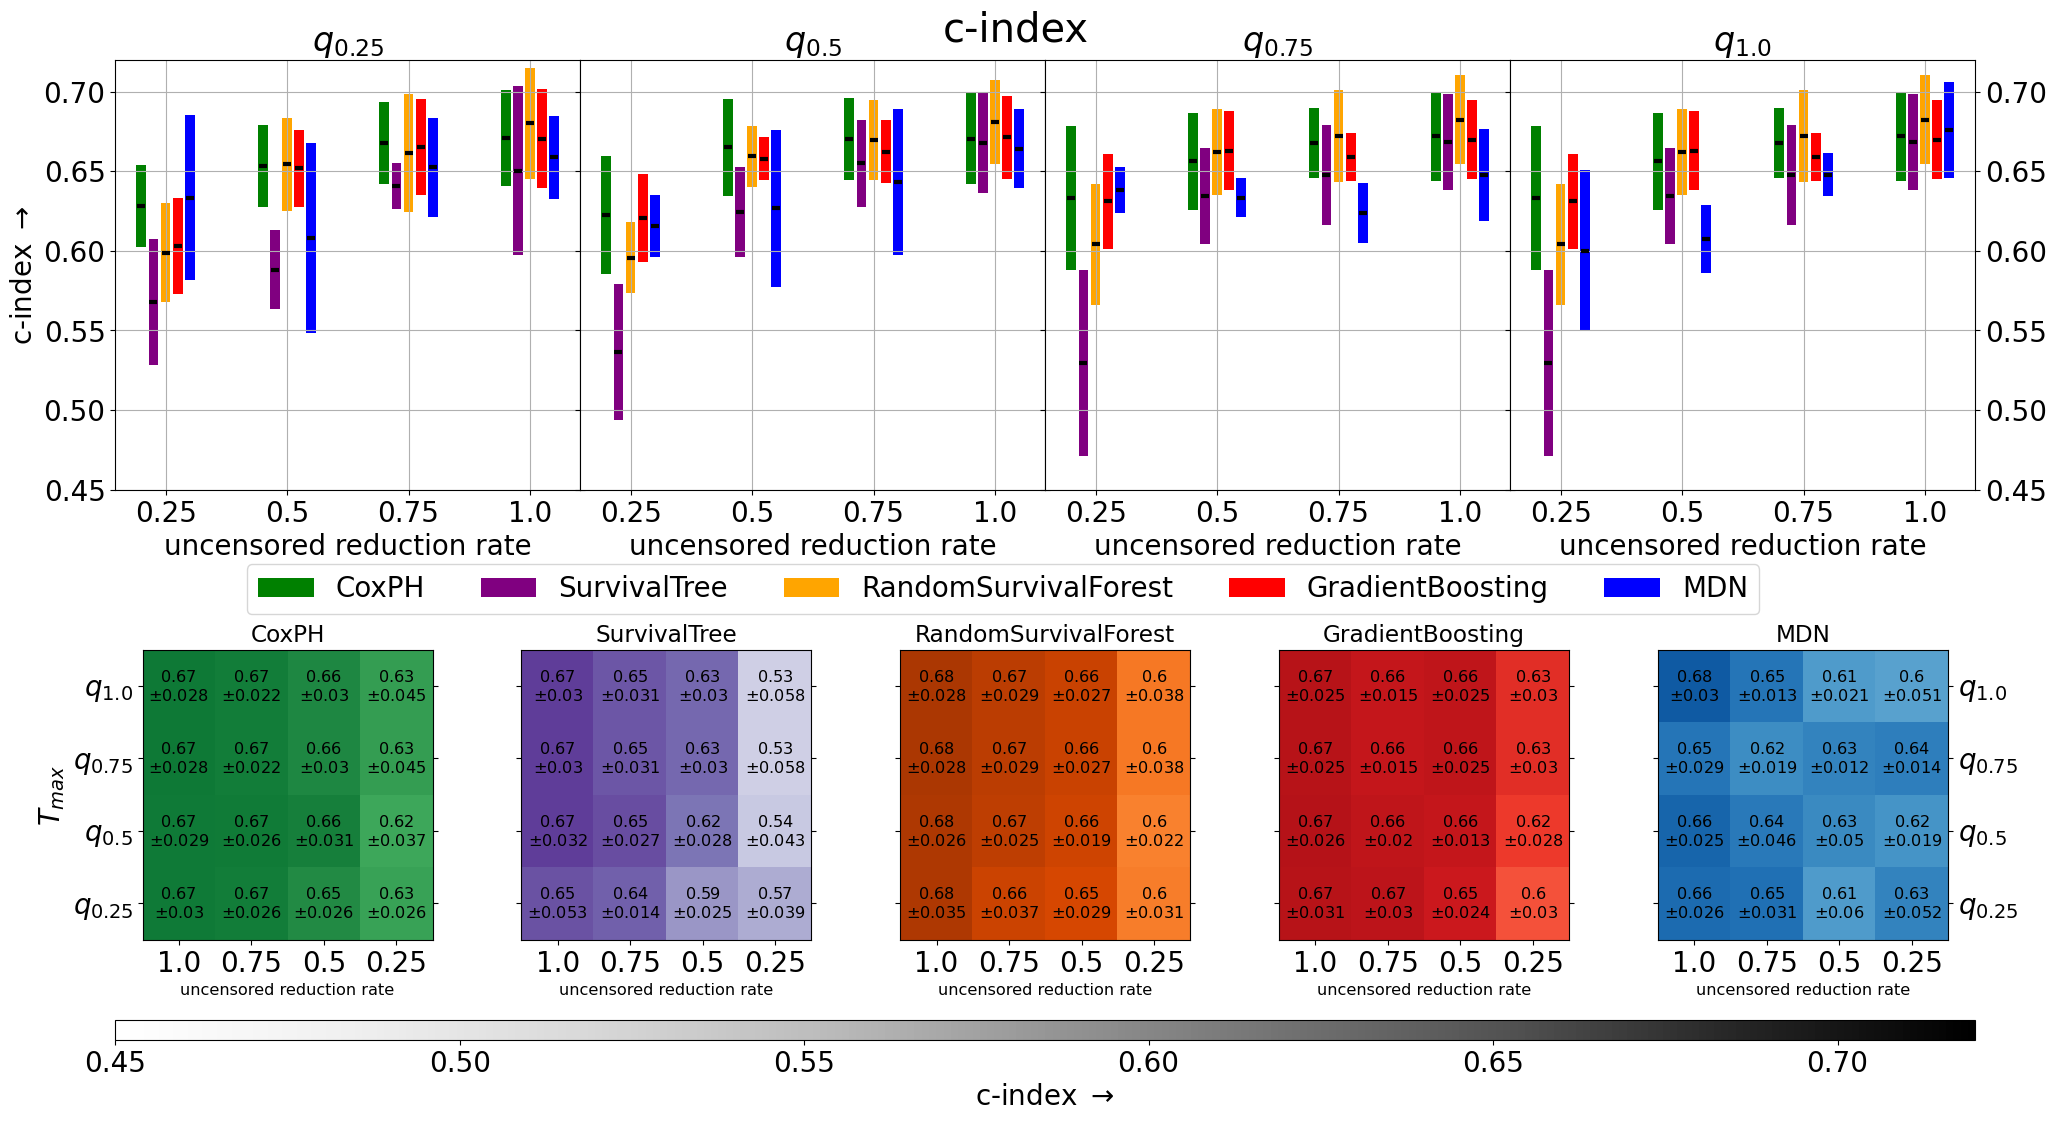

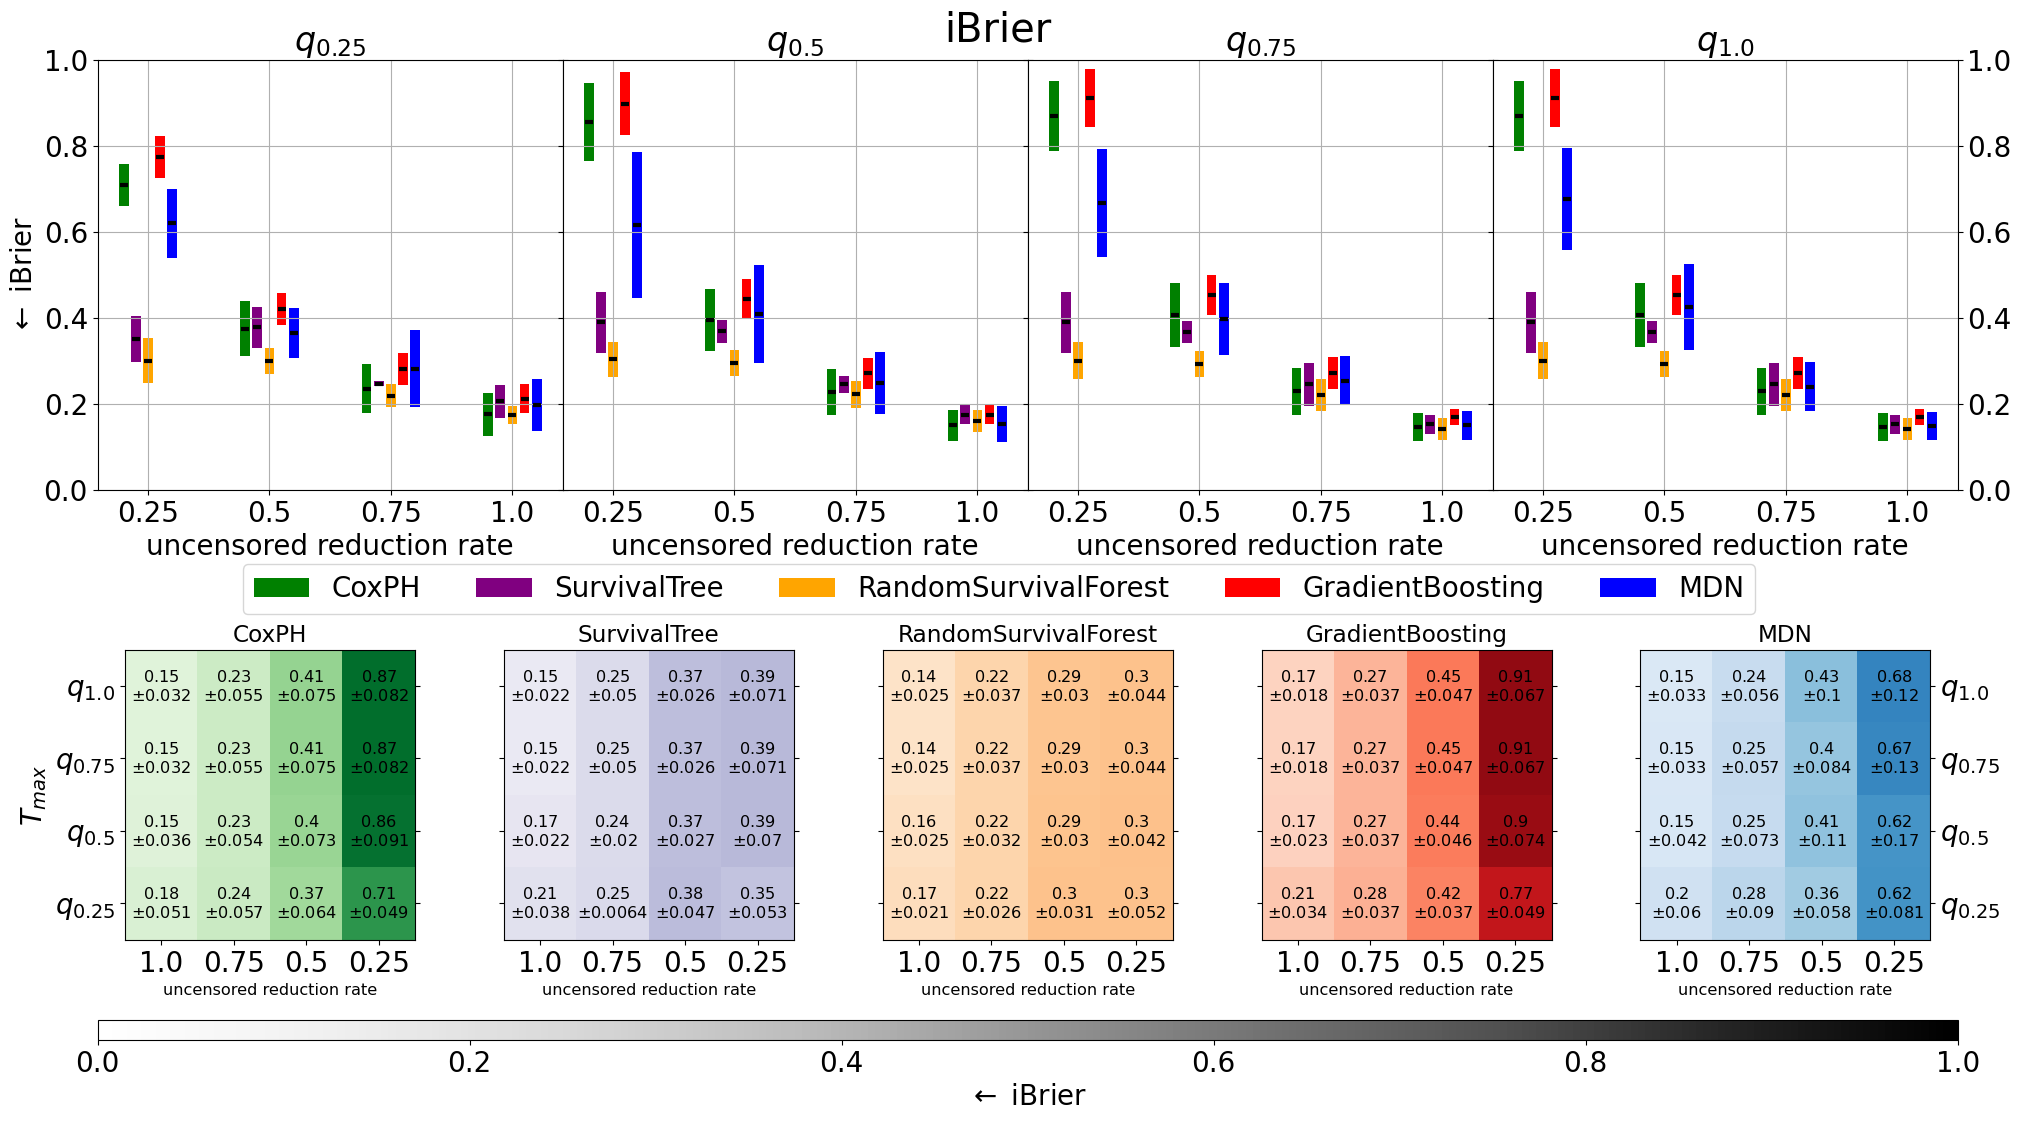

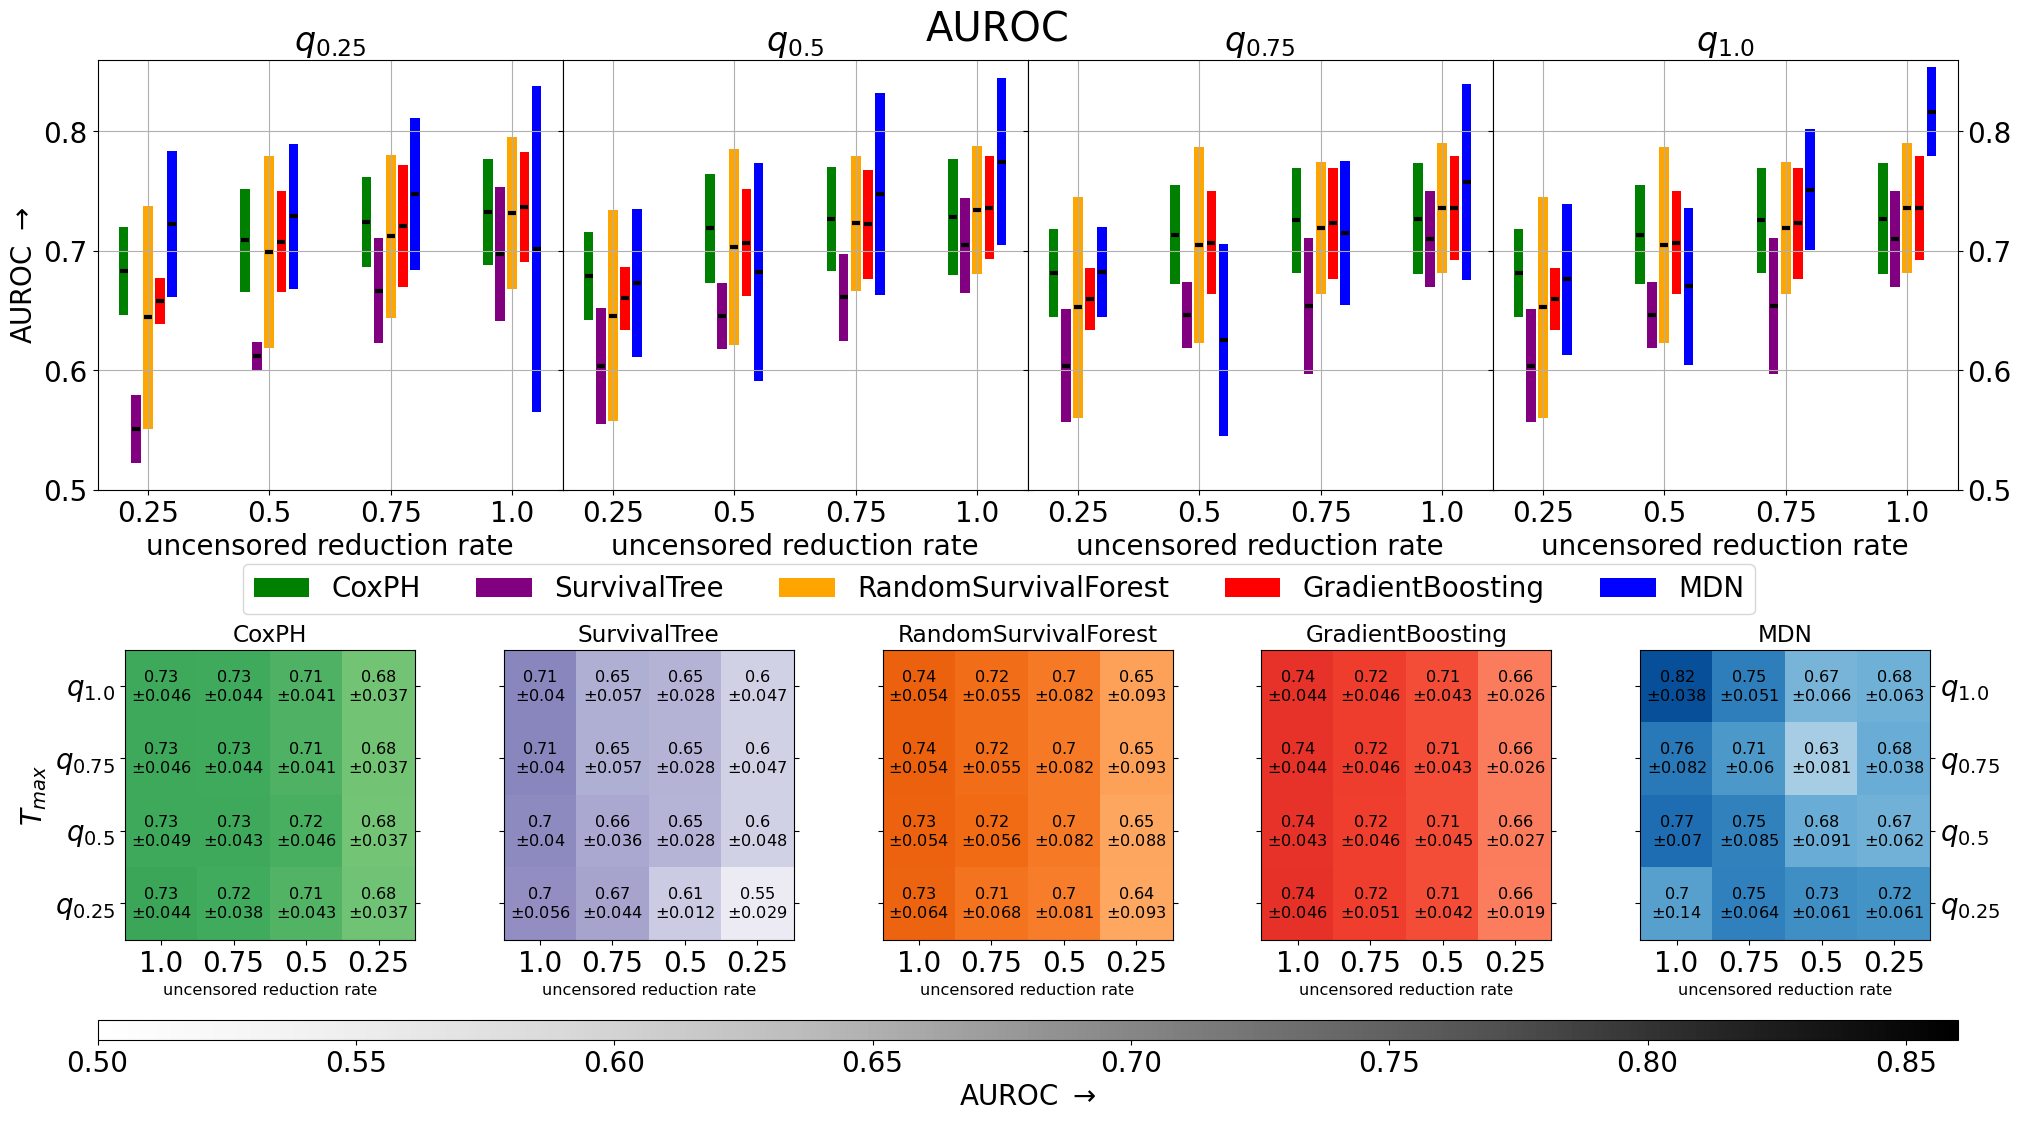

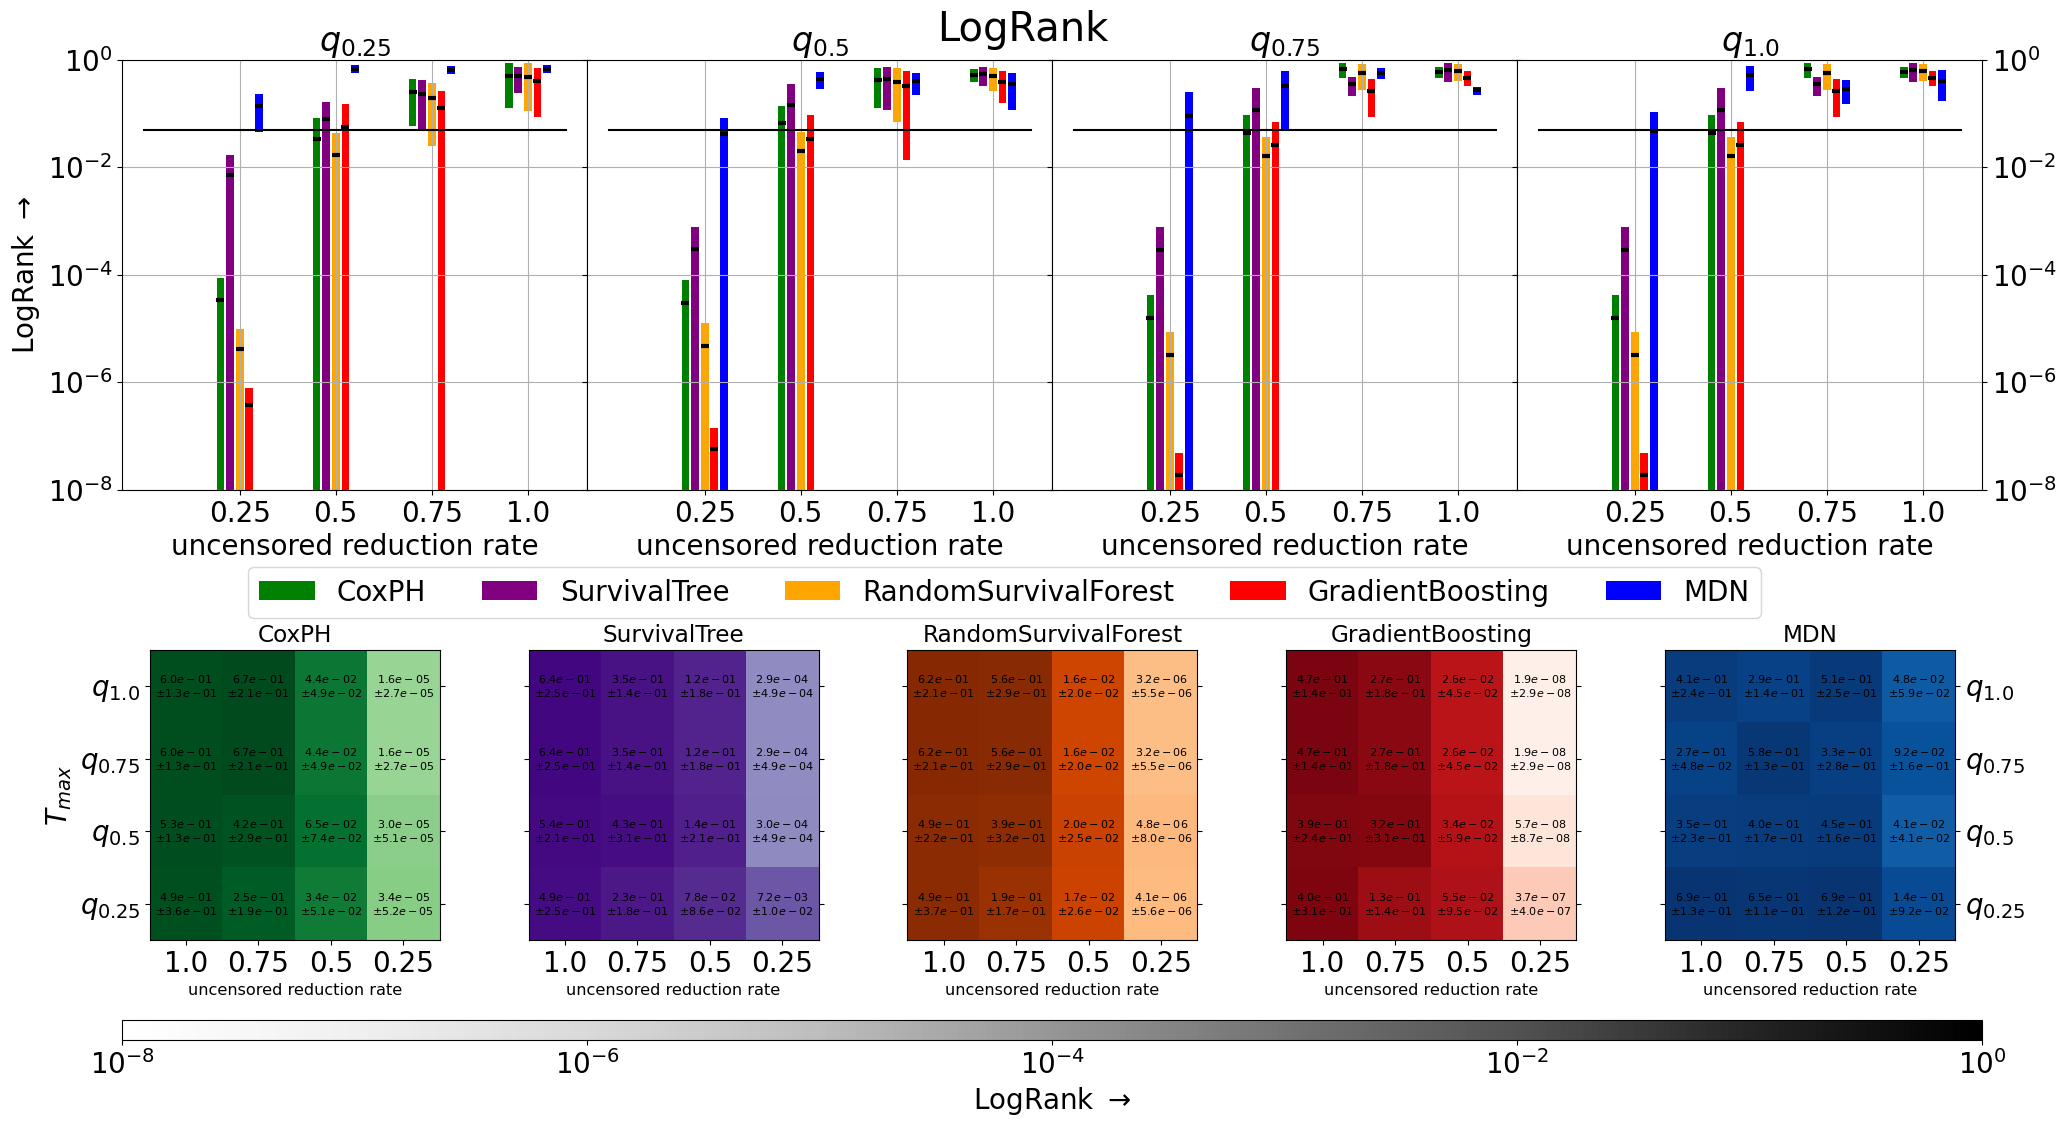

In [151]:
typ = "5Fold"
scores = ["UnoC $\\rightarrow$","$\\leftarrow$ iBrier","AUROC $\\rightarrow$","LogRank $\\rightarrow$"]
score_names = ["c-index","iBrier","AUROC","LogRank"]
ylims = [[0.45,0.72],[0.0,1.0],[0.5,0.86],[1e-8,1]]

for scr,scr_nm,ylim in zip(scores,score_names,ylims):
    #print(scr)
    fig = plt.figure(figsize=(20,10))

    # GridSpec for the barplots
    gs1 = GridSpec(1, 4, figure = fig, bottom=0.55, top=0.98, left=0.05, right=0.98, wspace = 0.0)
    bar_axs = []
    bar_locs = [0,1,2,3]
    for loc in bar_locs:
        bar_axs.append(fig.add_subplot(gs1[loc]))

    T_maxs = [0.25,0.5,0.75,1.0]
    for loc,T_max in zip(bar_locs,T_maxs):
        for _,row in sensitivity_analysis_[(sensitivity_analysis_.Type == typ) & (sensitivity_analysis_.Score == scr) & (sensitivity_analysis_.T_max == T_max)].iterrows():
            # Do the Japanese candles
            bar_axs[loc].plot(row["Ts"], row["means"], ls = "", marker = "_", markeredgewidth = 3, color = "black")
            bar_axs[loc].bar(row["Ts"], height = np.array(row["stds"])*2,width = 0.02, bottom = np.array(row["means"]) - np.array(row["stds"]), color = row.Color, label = row["Model"])

        if scr == "LogRank $\\rightarrow$":
            bar_axs[loc].set_yscale("log")
            bar_axs[loc].plot(np.linspace(0,1.1,100),0.05*np.ones(100),marker = "", color = "black")#, label = "LogRank success > 0.05")

        bar_axs[loc].set_xticks([0.25,0.5,0.75,1.0],["0.25","0.5","0.75","1.0"])
        bar_axs[loc].set_xlabel("uncensored reduction rate")
        if scr == "UnoC $\\rightarrow$":
            bar_axs[loc].set_ylabel("c-index $\\rightarrow$")
        else:
            bar_axs[loc].set_ylabel(scr)
        bar_axs[loc].yaxis.set_ticks_position('both')
        bar_axs[loc].tick_params(labelbottom=True, labeltop=False, labelleft = True, labelright = True)
        bar_axs[loc].set_ylim((ylim[0],ylim[1]))
        bar_axs[loc].grid()
        bar_axs[loc].set_title("$q_{" + f"{T_max}" +"}$")
        bar_axs[loc].label_outer()

    # GridSpec for the Heatmaps
    gs2 = GridSpec(1,5, figure = fig, bottom=0.1, top=0.39, left=0.05, right=0.98, wspace = 0.1)
    heat_axs = []
    heat_locs = [0,1,2,3,4]
    for loc in heat_locs:
        heat_axs.append(fig.add_subplot(gs2[loc]))
    # GridSpec for the Colorbar
    gs3 = GridSpec(1,1, figure = fig, bottom=0.00, top=0.02, left=0.05, right=0.98, wspace = 0.1)
    cbar_ax = fig.add_subplot(gs3[0])

    models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
    for loc,model in zip(heat_locs,models):
        for _,row in sensitivity_analysis_heatmap[(sensitivity_analysis_heatmap.Model == model) & (sensitivity_analysis_heatmap.Type == typ) & (sensitivity_analysis_heatmap.Score == scr)].iterrows():
            # Normalization
            if scr == "LogRank $\\rightarrow$":
                norm = LogNorm(vmin = ylim[0], vmax = ylim[1])
            else:
                norm = Normalize(vmin = ylim[0], vmax = ylim[1])

            # Heatmap
            im = heat_axs[loc].imshow(np.array(row.means).reshape(4,4), norm = norm, cmap = f"{row.Color}s")

            # Colorbar
            if loc == heat_locs[-1]:
                cbar = fig.colorbar(ScalarMappable(cmap = "Greys", norm = norm), cax = cbar_ax, orientation='horizontal')
                # Colorbar labels
                if scr == "UnoC $\\rightarrow$":
                    cbar.set_label("c-index $\\rightarrow$")
                else:
                    cbar.set_label(scr)

            # Ticks & Tick labels
            heat_axs[loc].set_xticks(np.arange(np.array(row.means).reshape(4,4).shape[1]), labels=[1.0,0.75,0.5,0.25])
            heat_axs[loc].set_xlabel("uncensored reduction rate", fontsize = "xx-small")
            heat_axs[loc].set_yticks(np.arange(np.array(row.means).reshape(4,4).shape[0]), labels=["$q_{1.0}$","$q_{0.75}$","$q_{0.5}$","$q_{0.25}$"])
            heat_axs[loc].yaxis.set_ticks_position('both')
            heat_axs[loc].tick_params(labelbottom=True, labeltop=False, labelleft = True, labelright = True)
            heat_axs[loc].set_ylabel("$T_{max}$")
            heat_axs[loc].label_outer()

            heat_axs[loc].set_title(model, fontsize = "small")



            # Scores as text
            for i in range(len(red_rates)):
                for j in range(len(T_maxs)):
                    clr = "black"
                    if scr == "LogRank $\\rightarrow$":
                        #if np.array(row.means).reshape(4,4)[i,j] < 0.05:
                        #    clr = "red"
                        mean = "{:.1e}".format(np.array(row.means).reshape(4,4)[i,j])
                        std = "{:.1e}".format(np.array(row.stds).reshape(4,4)[i,j])
                        text_size = 8
                    else:
                        mean = "{:.2}".format(np.array(row.means).reshape(4,4)[i,j])
                        std = "{:.2}".format(np.array(row.stds).reshape(4,4)[i,j])
                        text_size = "xx-small"
                    if typ == "5Fold":
                        scr_str = f"${mean}$\n$\pm {std}$"
                    else:
                        scr_str = f"{mean}"
                    text = heat_axs[loc].text(j, i, scr_str,ha="center", va="center", size = text_size, color = clr)

    handles, labels = bar_axs[bar_locs[-1]].get_legend_handles_labels()
    fig.legend(handles, labels, loc=(0.12,0.452),ncol = 5)
    fig.suptitle(scr_nm, y = 1.03, fontsize = "x-large")
    plt.show()

#### Hold-out

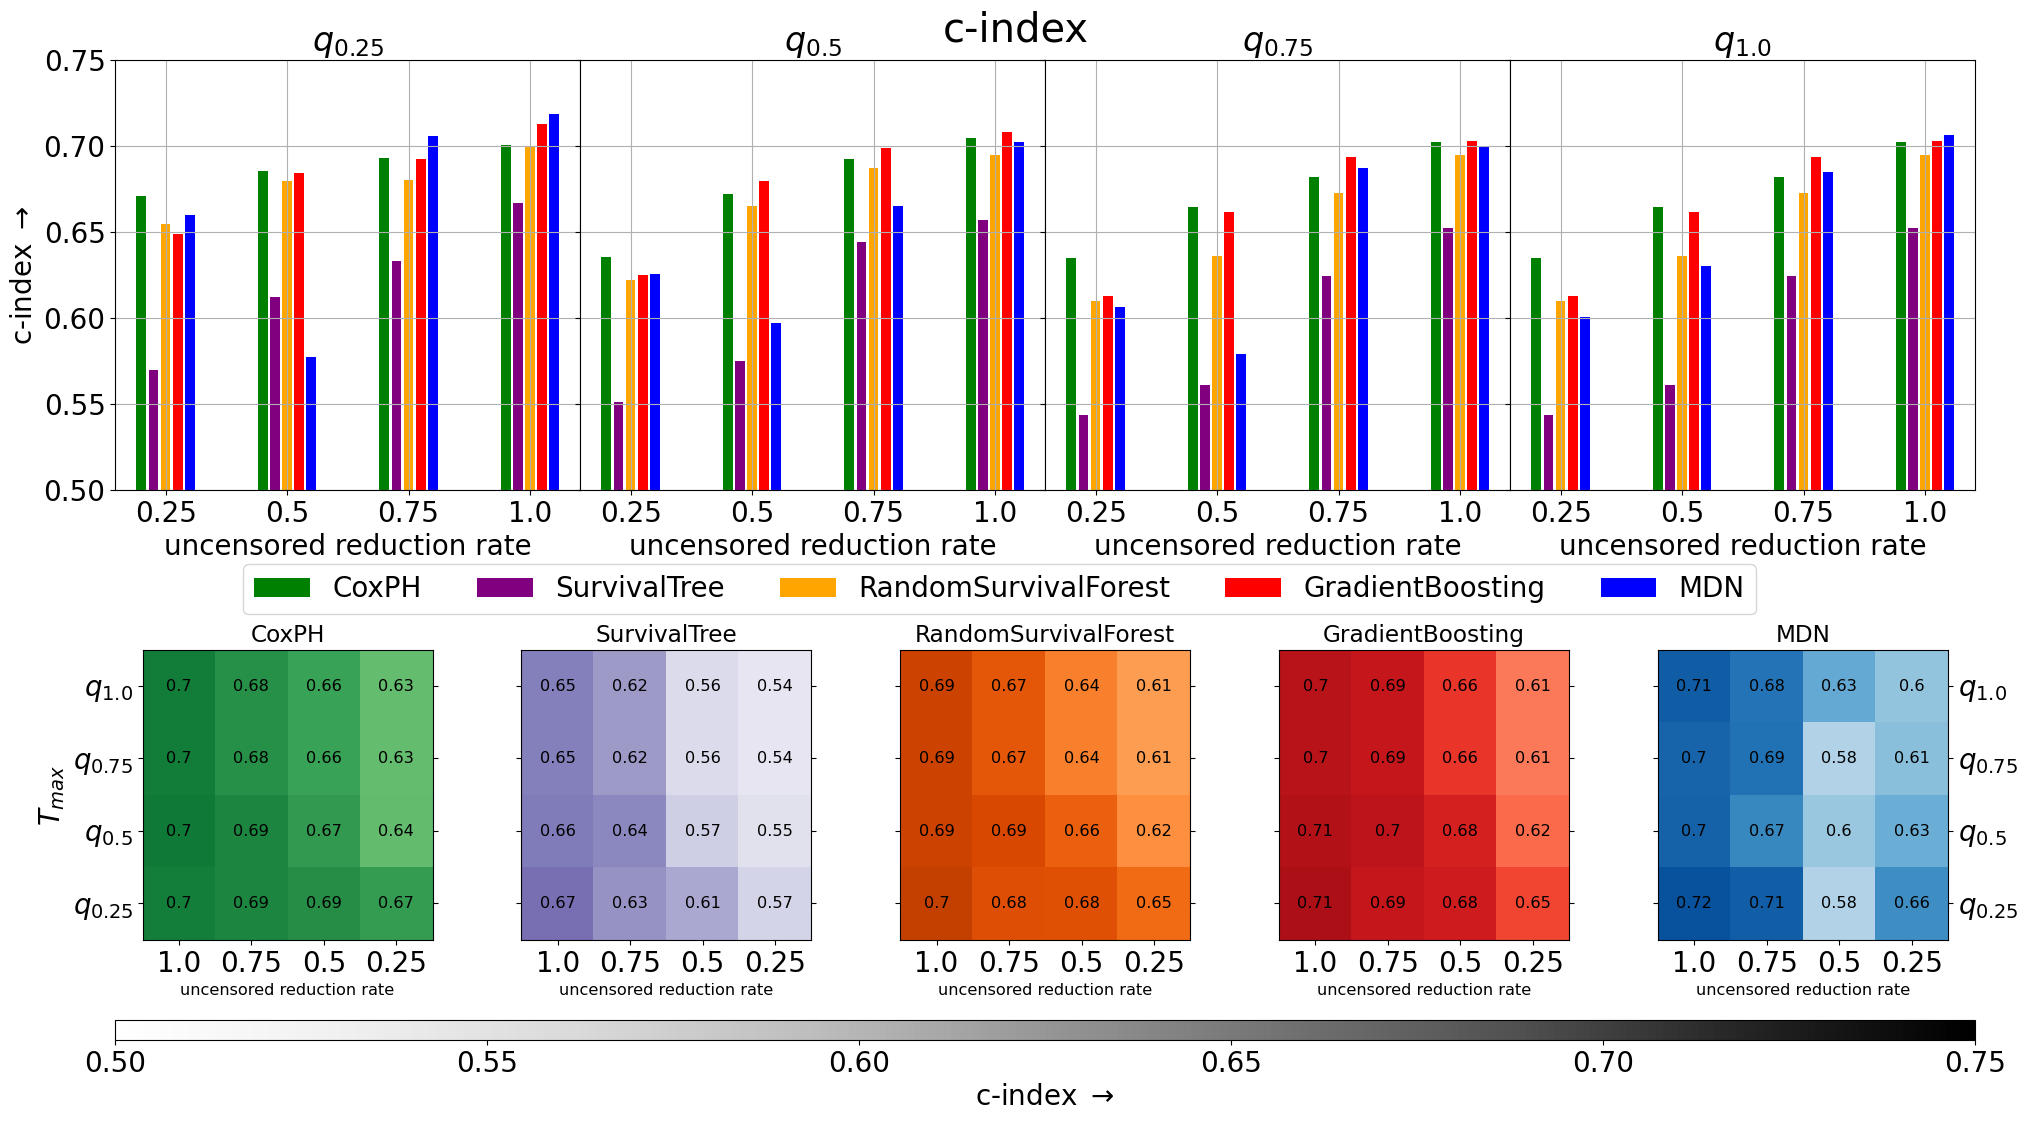

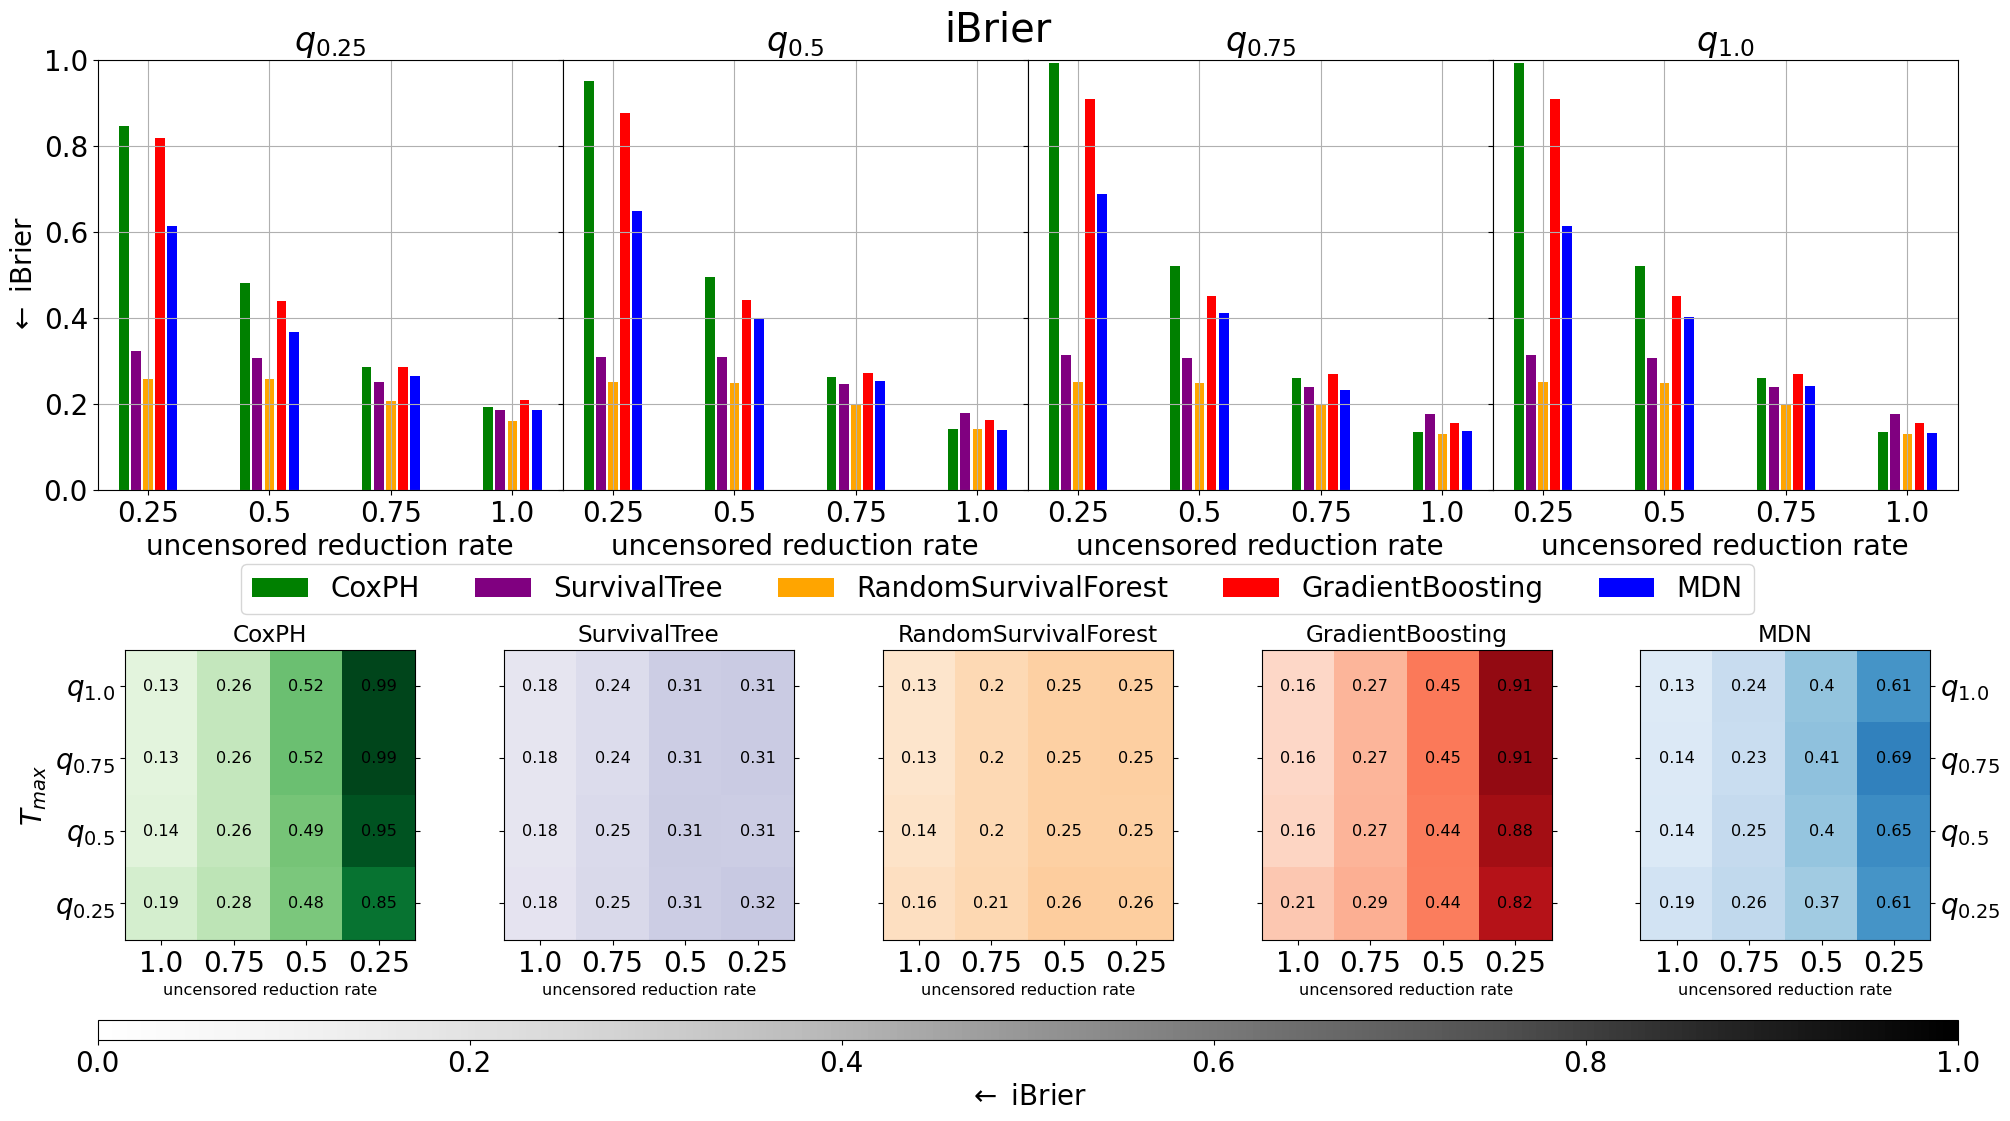

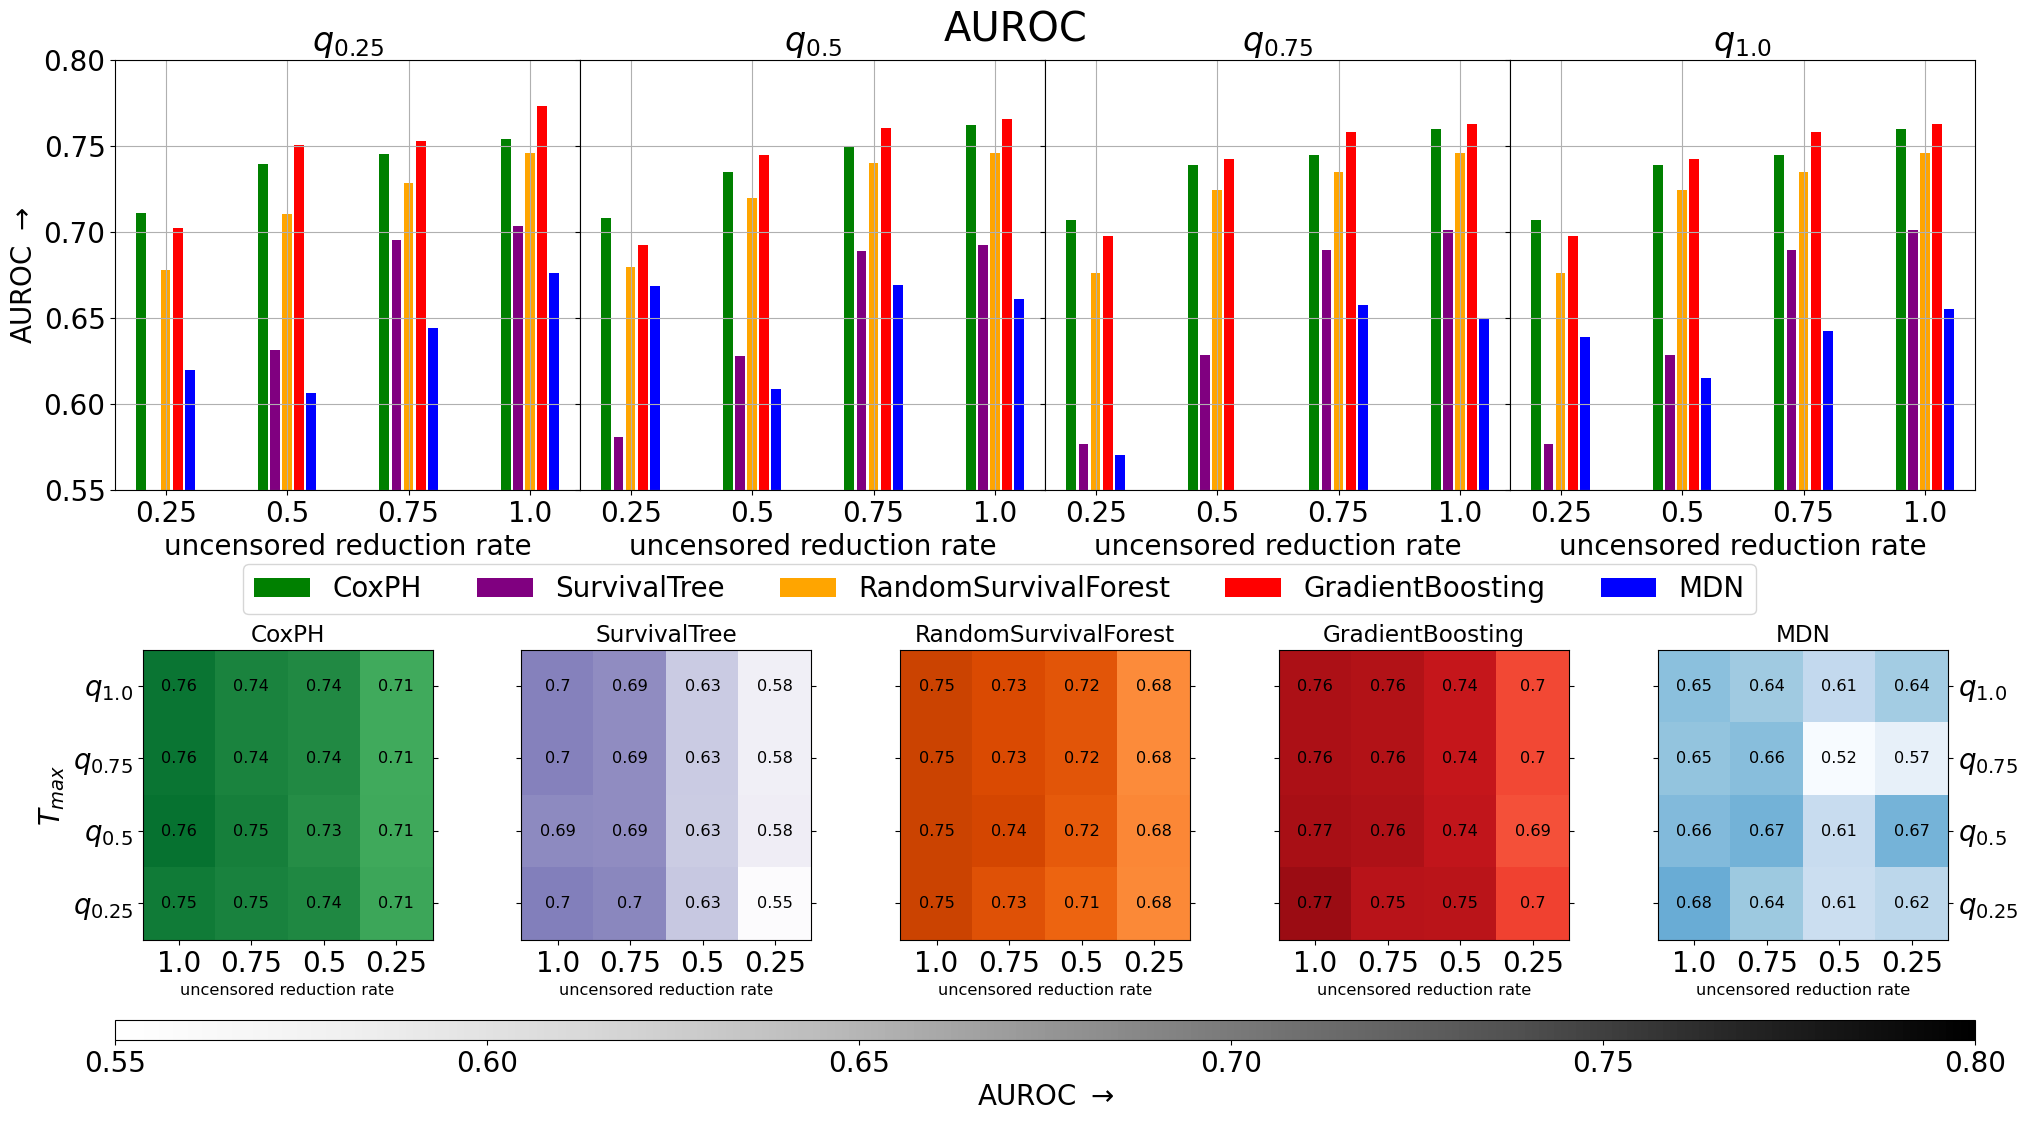

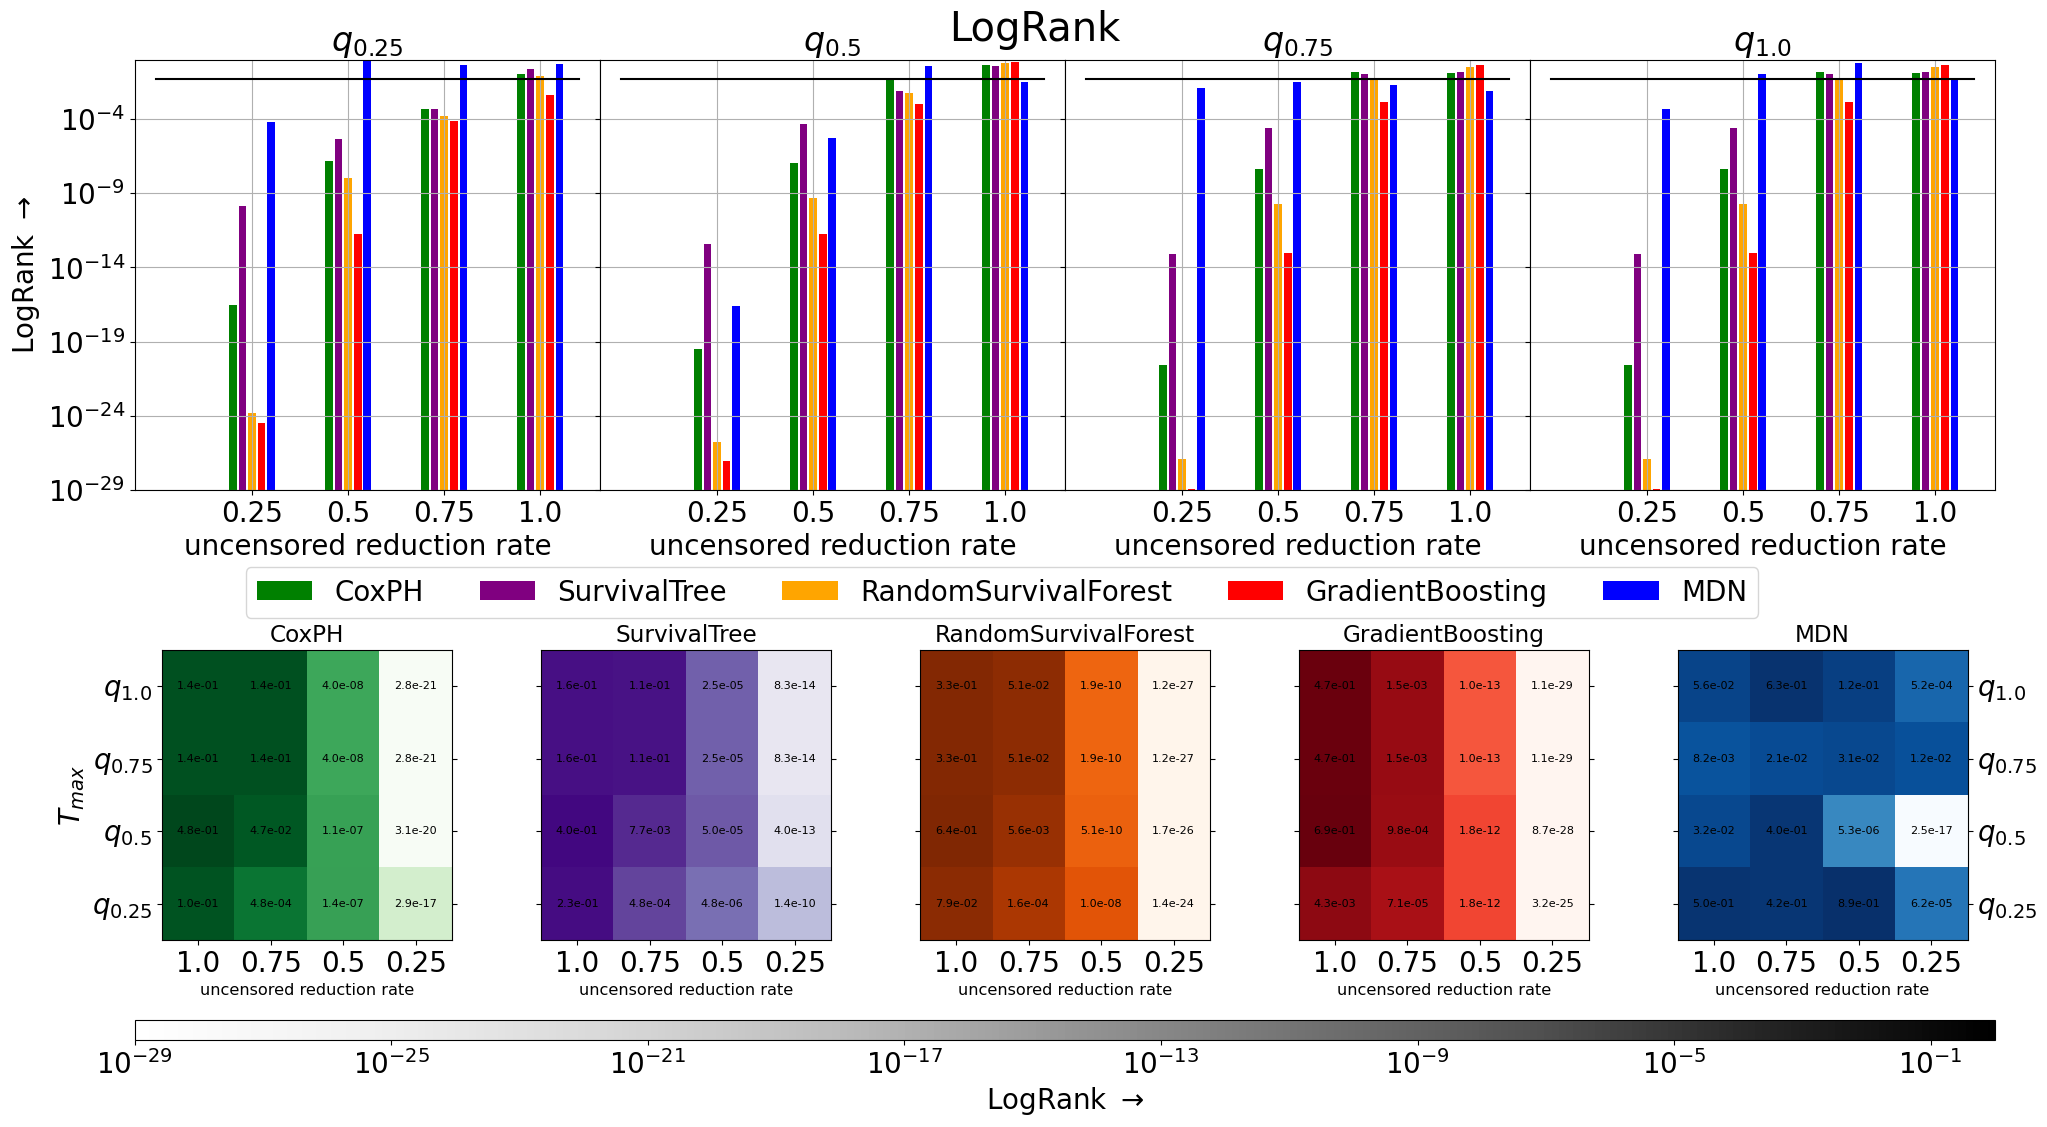

In [152]:
typ = "Hold-out"
scores = ["UnoC $\\rightarrow$","$\\leftarrow$ iBrier","AUROC $\\rightarrow$","LogRank $\\rightarrow$"]
score_names = ["c-index","iBrier","AUROC","LogRank"]
ylims = [[0.5,0.75],[0.0,1.0],[0.55,0.8],[1e-29,1]]

for scr,scr_nm,ylim in zip(scores,score_names,ylims):
    #print(scr)
    fig = plt.figure(figsize=(20,10))

    # GridSpec for the barplots
    gs1 = GridSpec(1, 4, figure = fig, bottom=0.55, top=0.98, left=0.05, right=0.98, wspace = 0.0)
    bar_axs = []
    bar_locs = [0,1,2,3]
    for loc in bar_locs:
        bar_axs.append(fig.add_subplot(gs1[loc]))

    T_maxs = [0.25,0.5,0.75,1.0]
    for loc,T_max in zip(bar_locs,T_maxs):
        for _,row in sensitivity_analysis_[(sensitivity_analysis_.Type == typ) & (sensitivity_analysis_.Score == scr) & (sensitivity_analysis_.T_max == T_max)].iterrows():
            eb = bar_axs[loc].bar(row["Ts"], height = row["means"],width = 0.02, yerr = row["stds"], color = row.Color, label = row["Model"])

        if scr == "LogRank $\\rightarrow$":
            bar_axs[loc].set_yscale("log")
            bar_axs[loc].plot(np.linspace(0,1.1,100),0.05*np.ones(100),marker = "", color = "black")#, label = "LogRank success > 0.05")

        bar_axs[loc].set_xticks([0.25,0.5,0.75,1.0],["0.25","0.5","0.75","1.0"])
        bar_axs[loc].set_xlabel("uncensored reduction rate")
        if scr == "UnoC $\\rightarrow$":
            bar_axs[loc].set_ylabel("c-index $\\rightarrow$")
        else:
            bar_axs[loc].set_ylabel(scr)
        bar_axs[loc].set_ylim((ylim[0],ylim[1]))
        bar_axs[loc].grid()
        bar_axs[loc].set_title("$q_{" + f"{T_max}" +"}$")
        bar_axs[loc].label_outer()

    # GridSpec for the Heatmaps
    gs2 = GridSpec(1,5, figure = fig, bottom=0.1, top=0.39, left=0.05, right=0.98, wspace = 0.1)
    heat_axs = []
    heat_locs = [0,1,2,3,4]
    for loc in heat_locs:
        heat_axs.append(fig.add_subplot(gs2[loc]))
    # GridSpec for the Colorbar
    gs3 = GridSpec(1,1, figure = fig, bottom=0.00, top=0.02, left=0.05, right=0.98, wspace = 0.1)
    cbar_ax = fig.add_subplot(gs3[0])

    models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
    for loc,model in zip(heat_locs,models):
        for _,row in sensitivity_analysis_heatmap[(sensitivity_analysis_heatmap.Model == model) & (sensitivity_analysis_heatmap.Type == typ) & (sensitivity_analysis_heatmap.Score == scr)].iterrows():
            # Normalization
            if scr == "LogRank $\\rightarrow$":
                norm = LogNorm(vmin = ylim[0], vmax = ylim[1])
            else:
                norm = Normalize(vmin = ylim[0], vmax = ylim[1])

            # Heatmap
            im = heat_axs[loc].imshow(np.array(row.means).reshape(4,4), norm = norm, cmap = f"{row.Color}s")

            # Colorbar
            if loc == heat_locs[-1]:
                cbar = fig.colorbar(ScalarMappable(cmap = "Greys", norm = norm), cax = cbar_ax, orientation='horizontal')
                # Colorbar labels
                if scr == "UnoC $\\rightarrow$":
                    cbar.set_label("c-index $\\rightarrow$")
                else:
                    cbar.set_label(scr)

            # Ticks & Tick labels
            heat_axs[loc].set_xticks(np.arange(np.array(row.means).reshape(4,4).shape[1]), labels=[1.0,0.75,0.5,0.25])
            heat_axs[loc].set_xlabel("uncensored reduction rate", fontsize = "xx-small")
            heat_axs[loc].set_yticks(np.arange(np.array(row.means).reshape(4,4).shape[0]), labels=["$q_{1.0}$","$q_{0.75}$","$q_{0.5}$","$q_{0.25}$"])
            heat_axs[loc].yaxis.set_ticks_position('both')
            heat_axs[loc].tick_params(labelbottom=True, labeltop=False, labelleft = True, labelright = True)
            heat_axs[loc].set_ylabel("$T_{max}$")
            heat_axs[loc].label_outer()

            heat_axs[loc].set_title(model, fontsize = "small")

            # Scores as text
            for i in range(len(red_rates)):
                for j in range(len(T_maxs)):
                    clr = "black"
                    #clr = ScalarMappable(cmap = f"Greys_r", norm = norm).to_rgba(np.array(row.means).reshape(4,4)[i,j])
                    if scr == "LogRank $\\rightarrow$":
                        #if np.array(row.means).reshape(4,4)[i,j] < 0.05:
                        #    clr = "red"
                        mean = "{:.1e}".format(np.array(row.means).reshape(4,4)[i,j])
                        std = "{:.1e}".format(np.array(row.stds).reshape(4,4)[i,j])
                        text_size = 8
                    else:
                        mean = "{:.2}".format(np.array(row.means).reshape(4,4)[i,j])
                        std = "{:.2}".format(float(np.array(row.stds).reshape(4,4)[i,j]))
                        text_size = "xx-small"
                    if typ == "5Fold":
                        scr_str = f"${mean}$\n$\pm {std}$"
                    else:
                        scr_str = f"{mean}"
                    text = heat_axs[loc].text(j, i, scr_str,ha="center", va="center", size = text_size, color = clr)

    handles, labels = bar_axs[bar_locs[-1]].get_legend_handles_labels()
    fig.legend(handles, labels, loc=(0.12,0.452),ncol = 5)
    fig.suptitle(scr_nm, y = 1.03, fontsize = "x-large")
    plt.show()

### Correlation

In [132]:
from scipy.stats import spearmanr

In [133]:
models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
colors = ["green","purple","orange","red","blue"]
markers = ["o","v","s","D","*"]
opts = [True]
typs = ["5Fold","Hold-out"]
trials = list(product(models,opts,typs))

sensitivity_analysis_corr  = {"Model":[],
                              "Type":[],
                              "corrs":[],
                              "pvals":[]}

for trial in trials:
    sensitivity_analysis_corr["Model"].append(trial[0])
    sensitivity_analysis_corr["Type"].append(trial[2])

    # Baseline
    baseline = []
    for i in range(len(results_table["Model"])):
        if (results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1]) & (results_table["T_max"][i] == 1) & (results_table["Uncensored_Reduction"][i] == 1):
            if trial[2] == "5Fold":
                baseline.append(results_table[trial[2]]["UnoC"]["mean"][i])
                baseline.append(results_table[trial[2]]["iBrier"]["mean"][i])
                baseline.append(results_table[trial[2]]["AUROC"]["mean"][i])
                baseline.append(results_table[trial[2]]["LogRank"]["mean"][i])
            else:
                baseline.append(results_table[trial[2]]["UnoC"][i])
                baseline.append(results_table[trial[2]]["iBrier"][i])
                baseline.append(results_table[trial[2]]["AUROC"][i])
                baseline.append(results_table[trial[2]]["LogRank"][i])
    baseline = np.array(baseline)

    ts = []
    corrs = []
    pvals = []
    for i in range(len(results_table["Model"])):
        if (results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1]):
            if trial[2] == "5Fold":
                current = []
                current.append(results_table[trial[2]]["UnoC"]["mean"][i])
                current.append(results_table[trial[2]]["iBrier"]["mean"][i])
                current.append(results_table[trial[2]]["AUROC"]["mean"][i])
                current.append(results_table[trial[2]]["LogRank"]["mean"][i])
                current = np.array(current)
            else:
                current = []
                current.append(results_table[trial[2]]["UnoC"][i])
                current.append(results_table[trial[2]]["iBrier"][i])
                current.append(results_table[trial[2]]["AUROC"][i])
                current.append(results_table[trial[2]]["LogRank"][i])
                current = np.array(current)
            spearman_result = spearmanr(current,baseline)
            corrs.append(spearman_result.correlation)
            pvals.append(spearman_result.pvalue)
    sensitivity_analysis_corr["corrs"].append(corrs)
    sensitivity_analysis_corr["pvals"].append(pvals)

sensitivity_analysis_corr = pd.DataFrame.from_dict(sensitivity_analysis_corr)

#### Correlation Plots

CoxPH


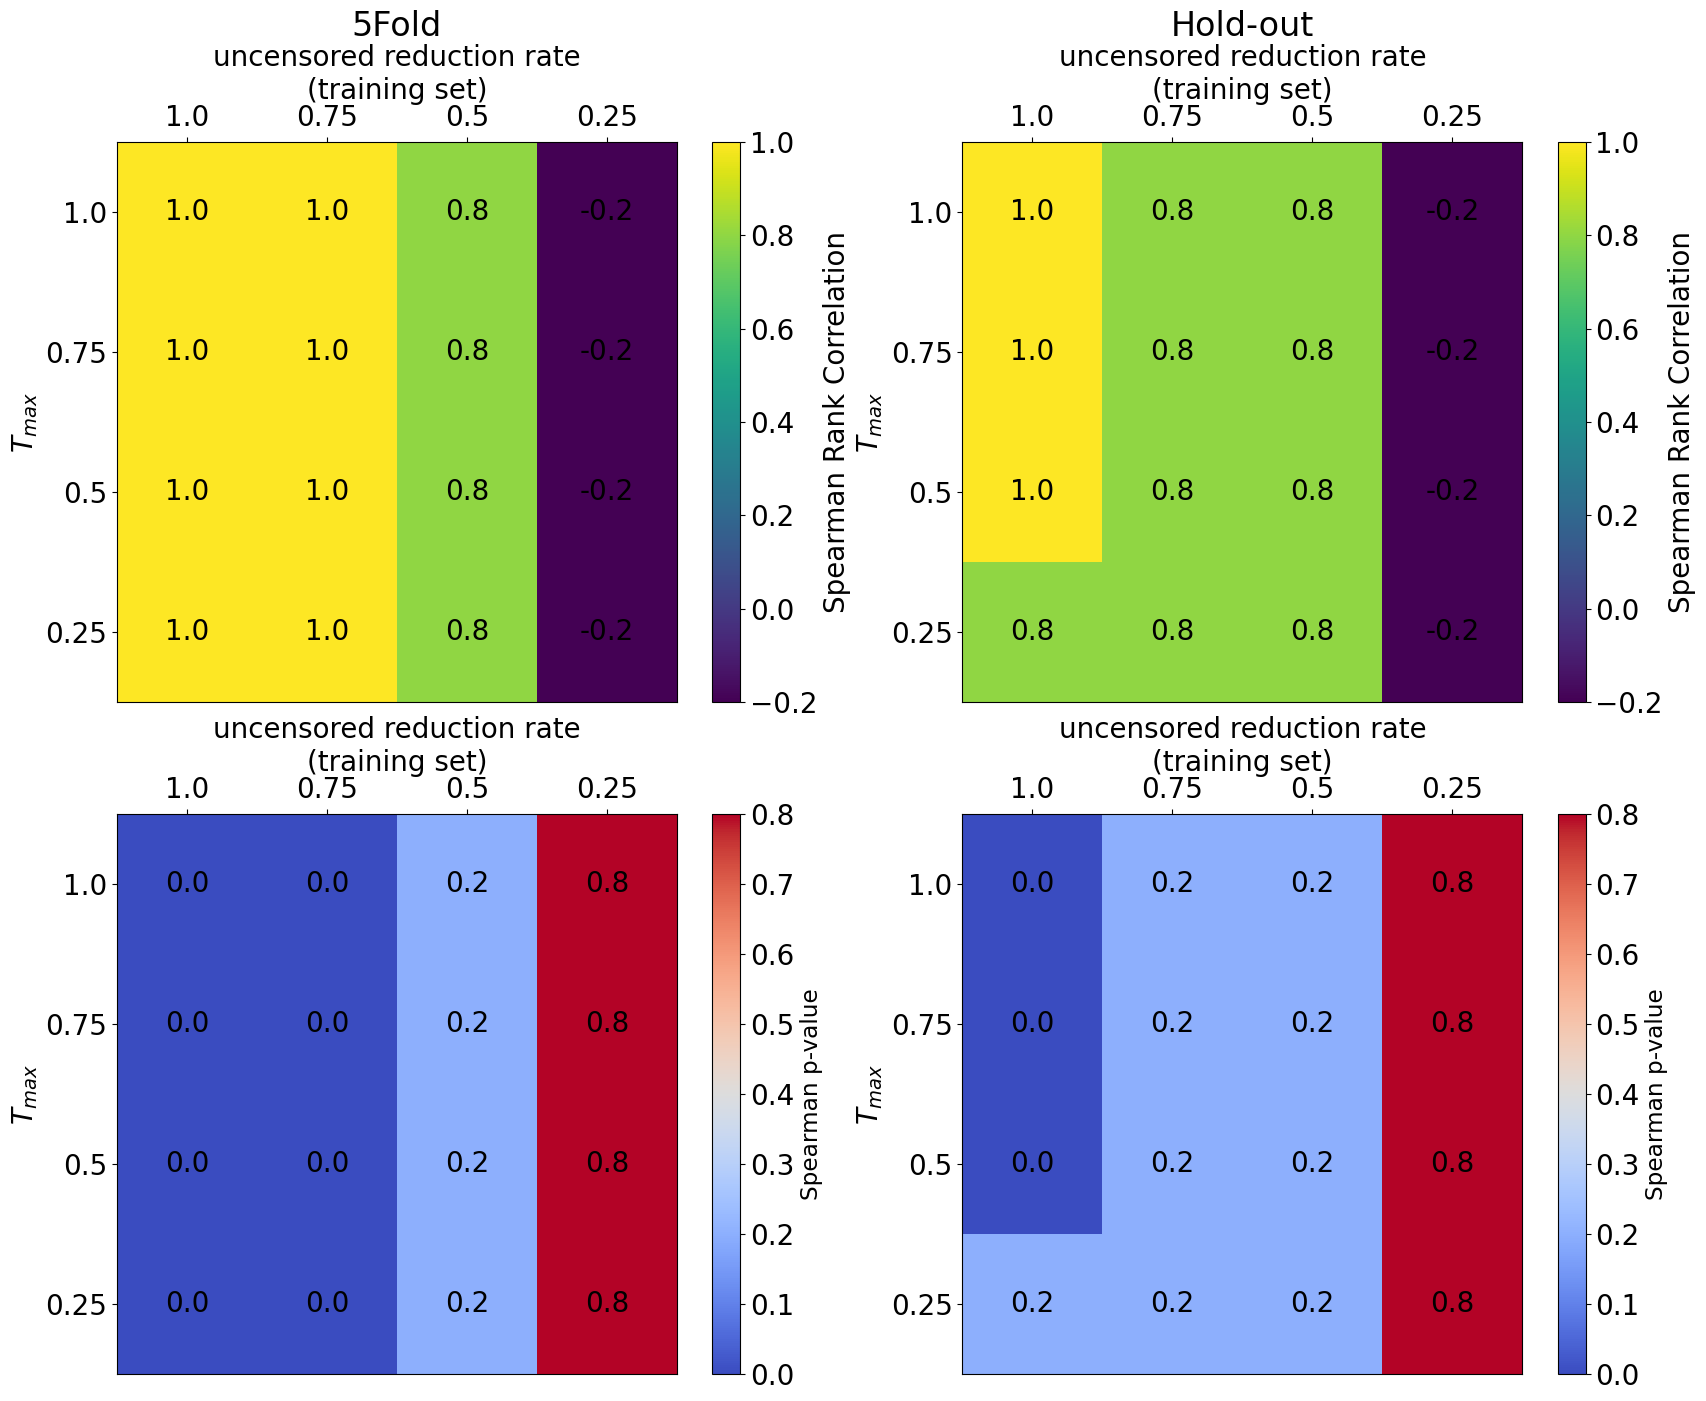

SurvivalTree


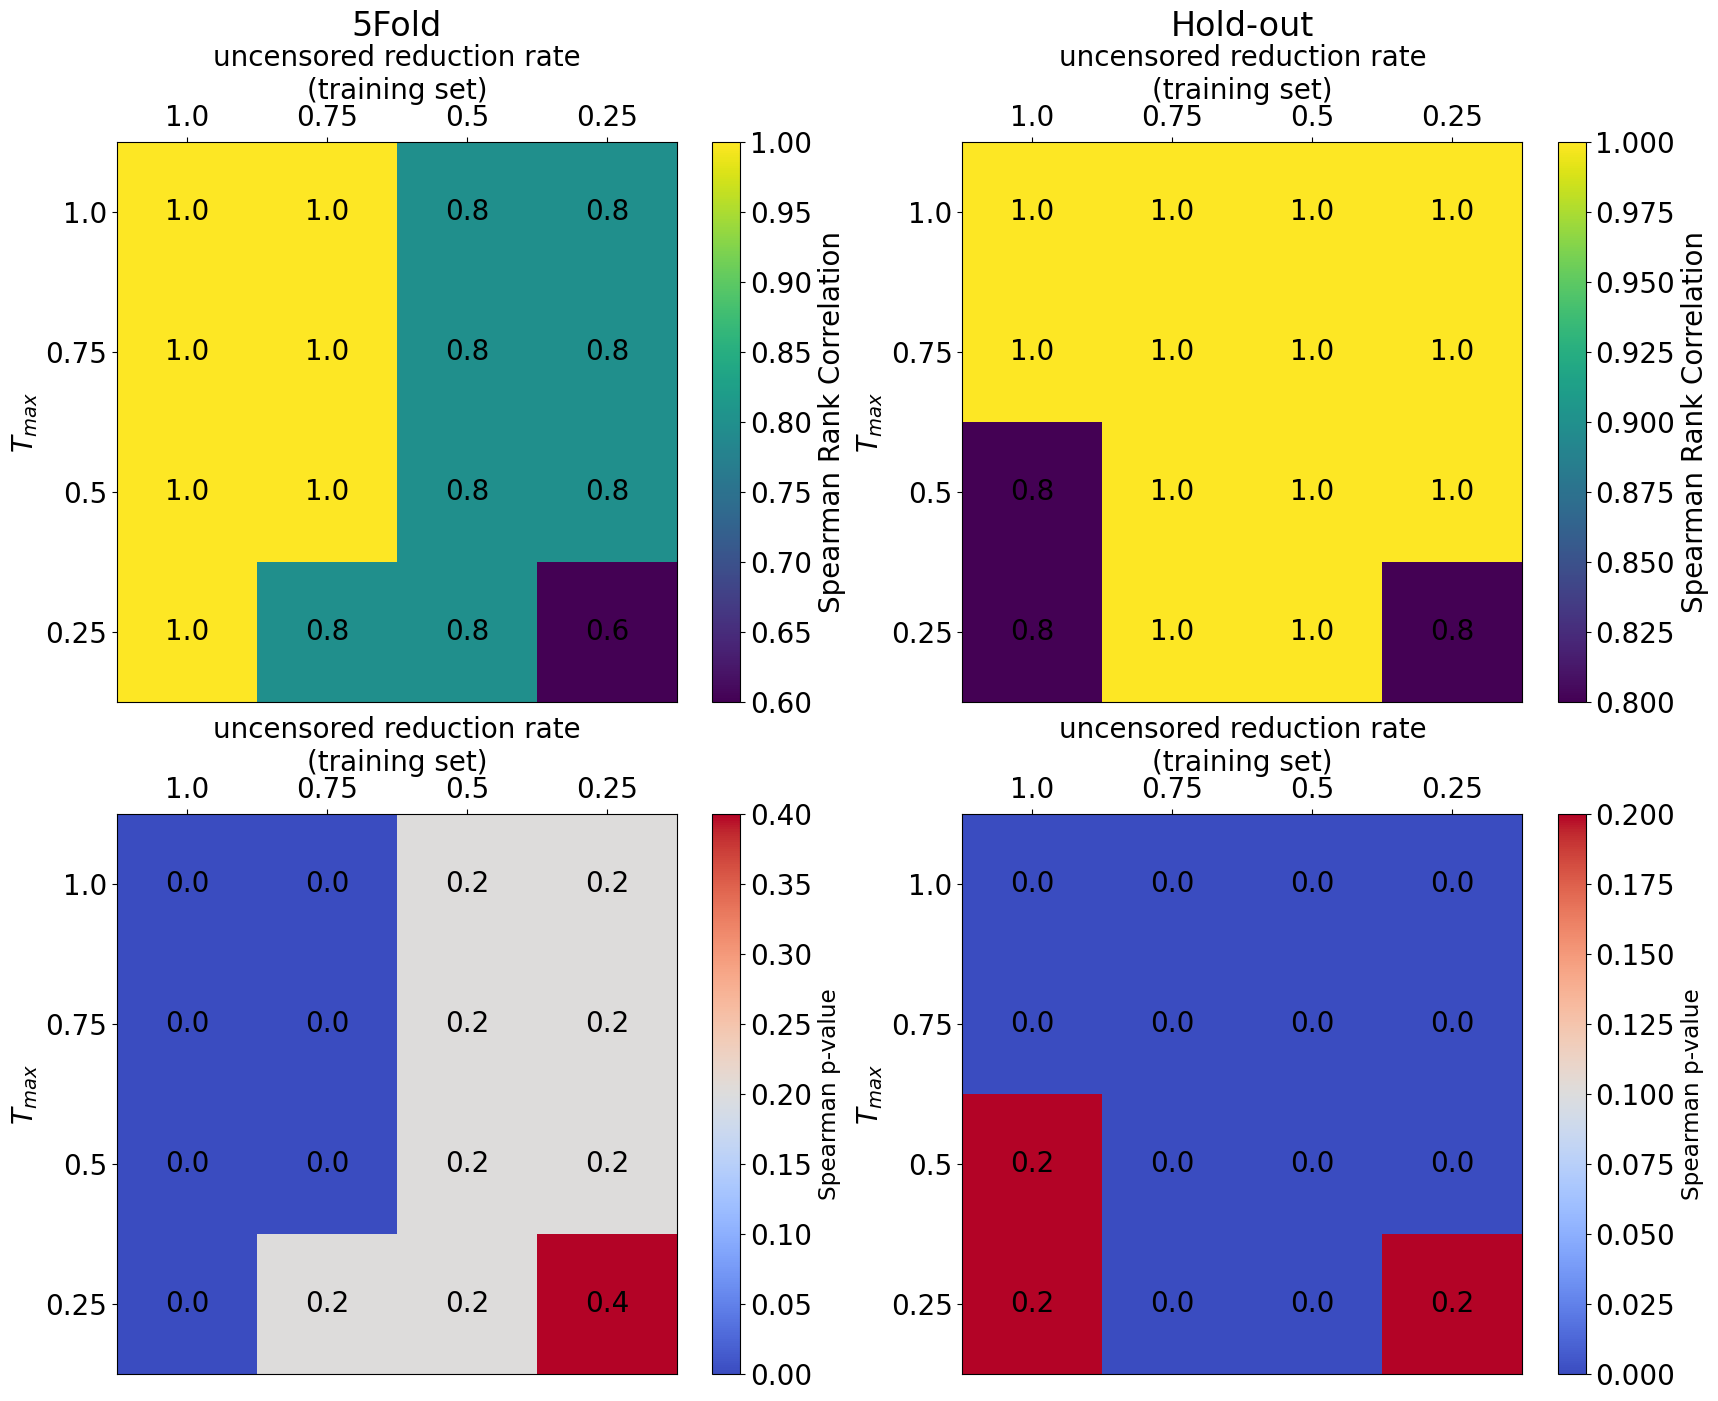

RandomSurvivalForest


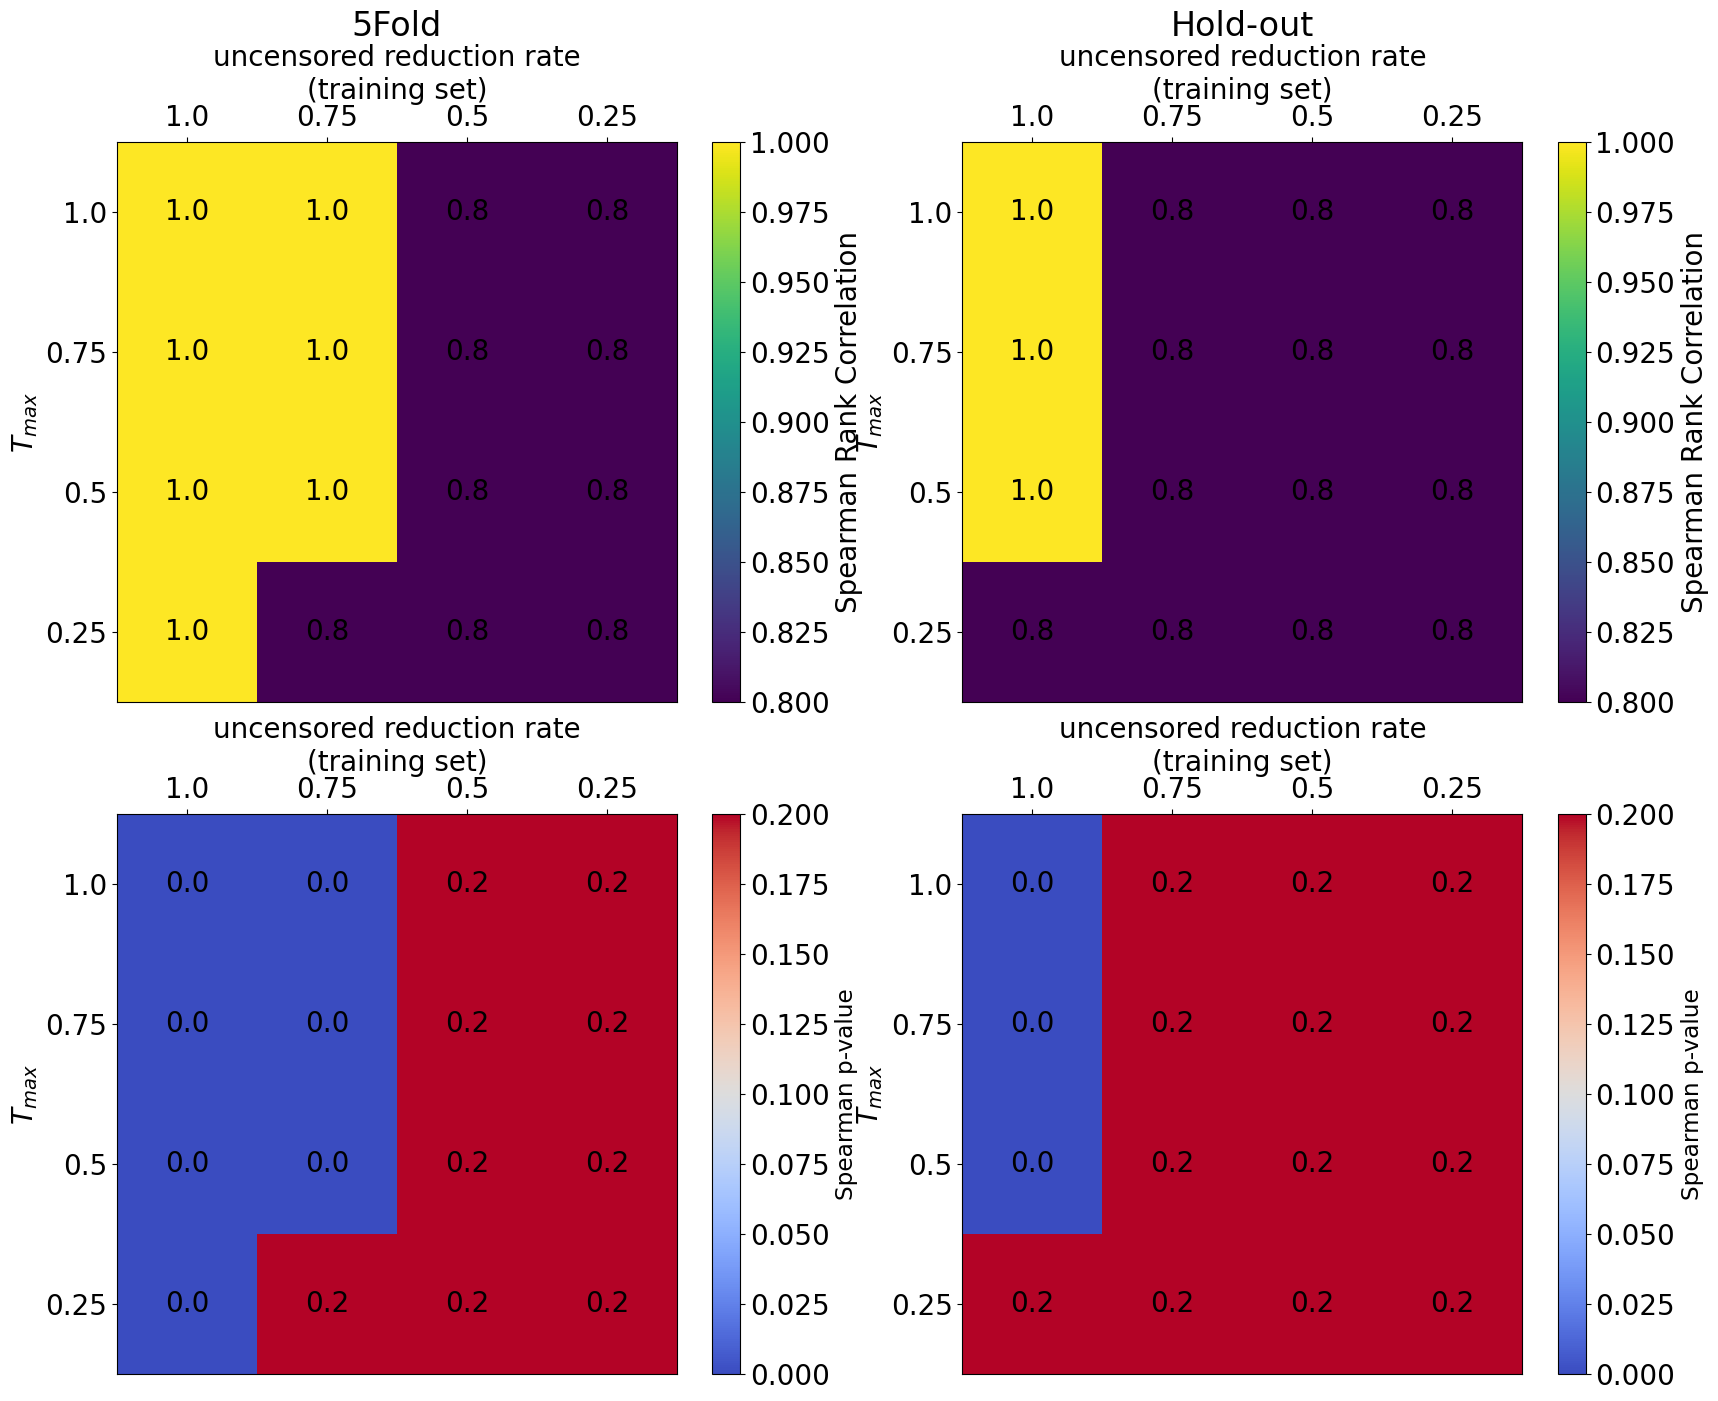

GradientBoosting


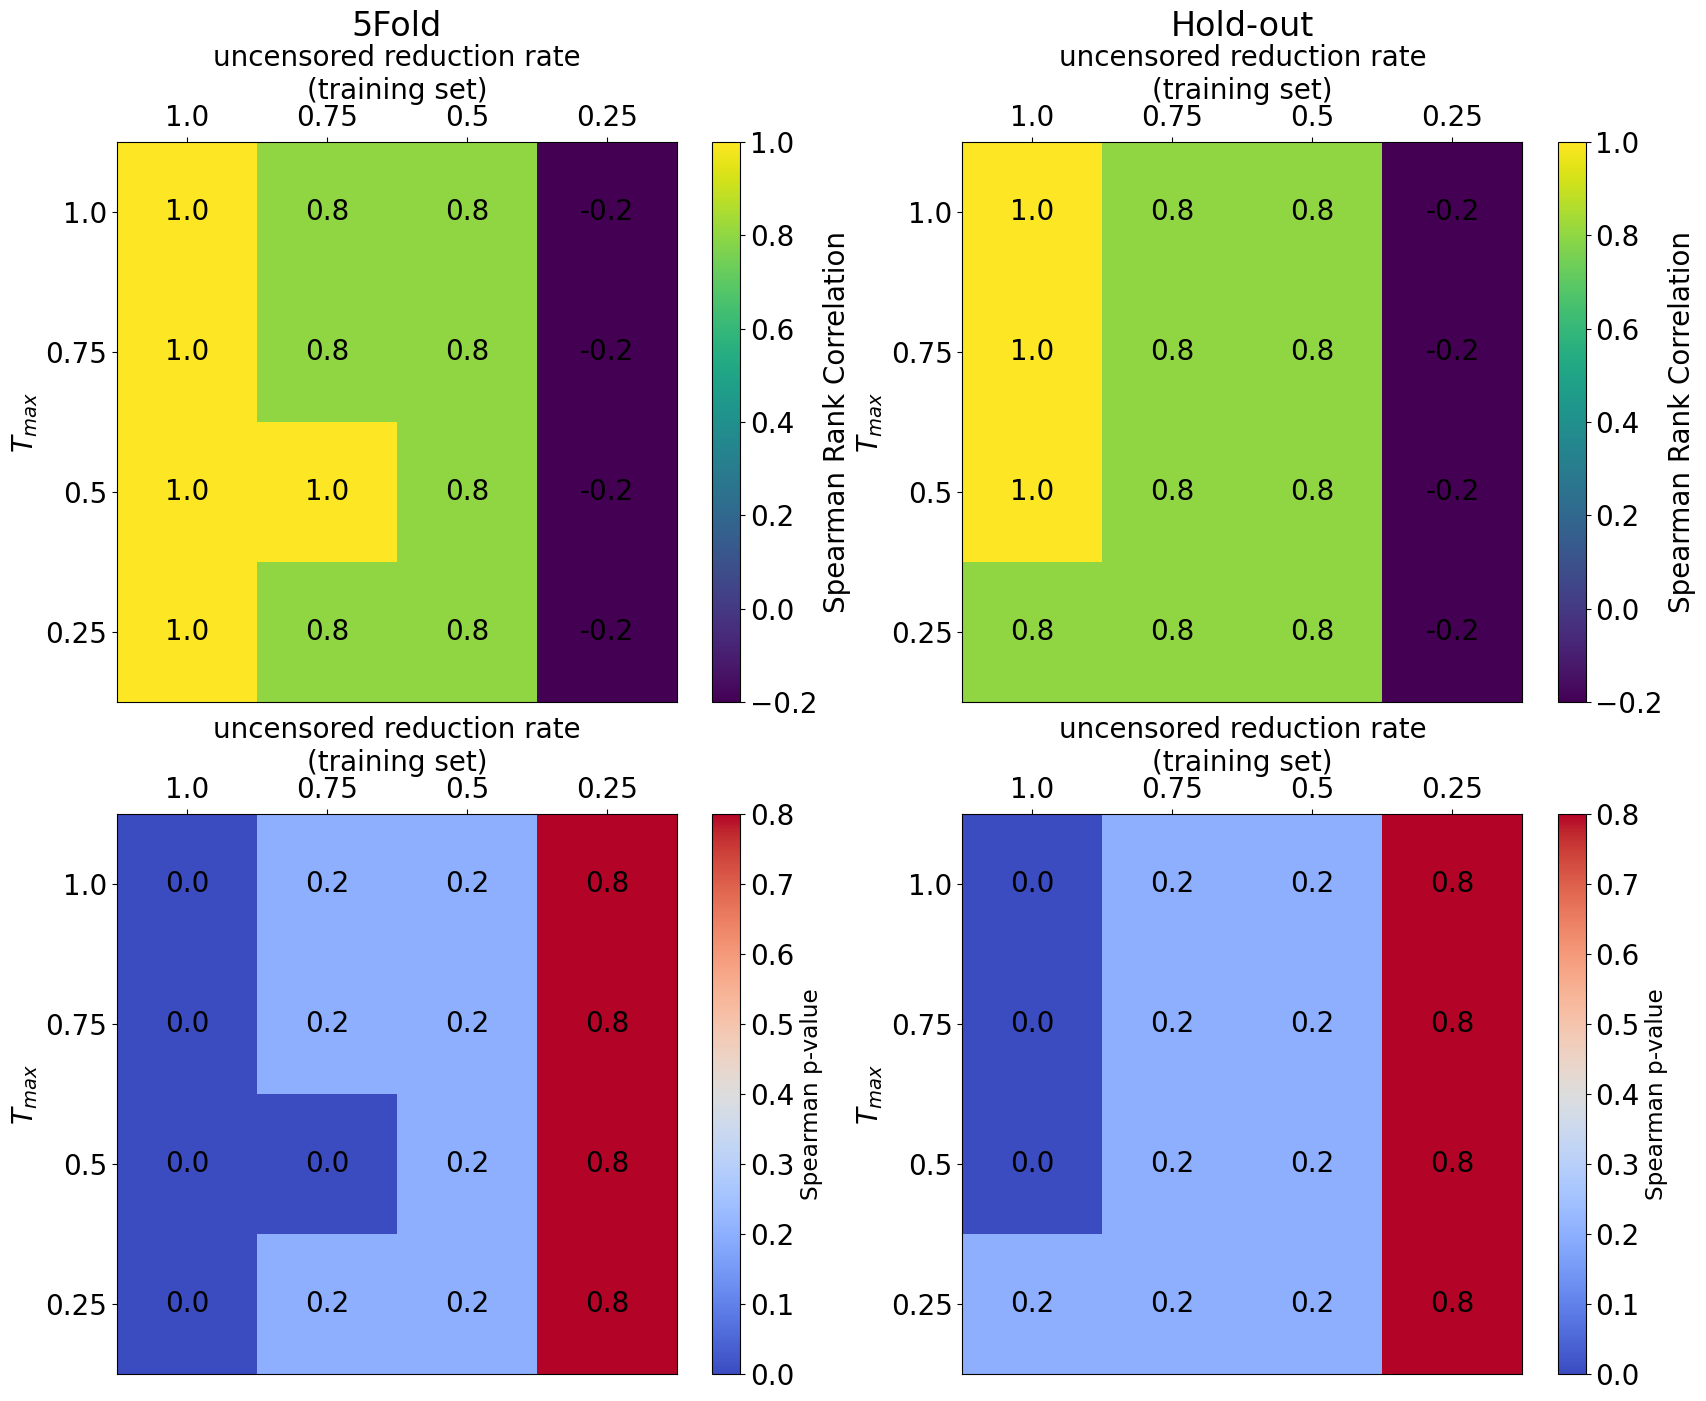

MDN


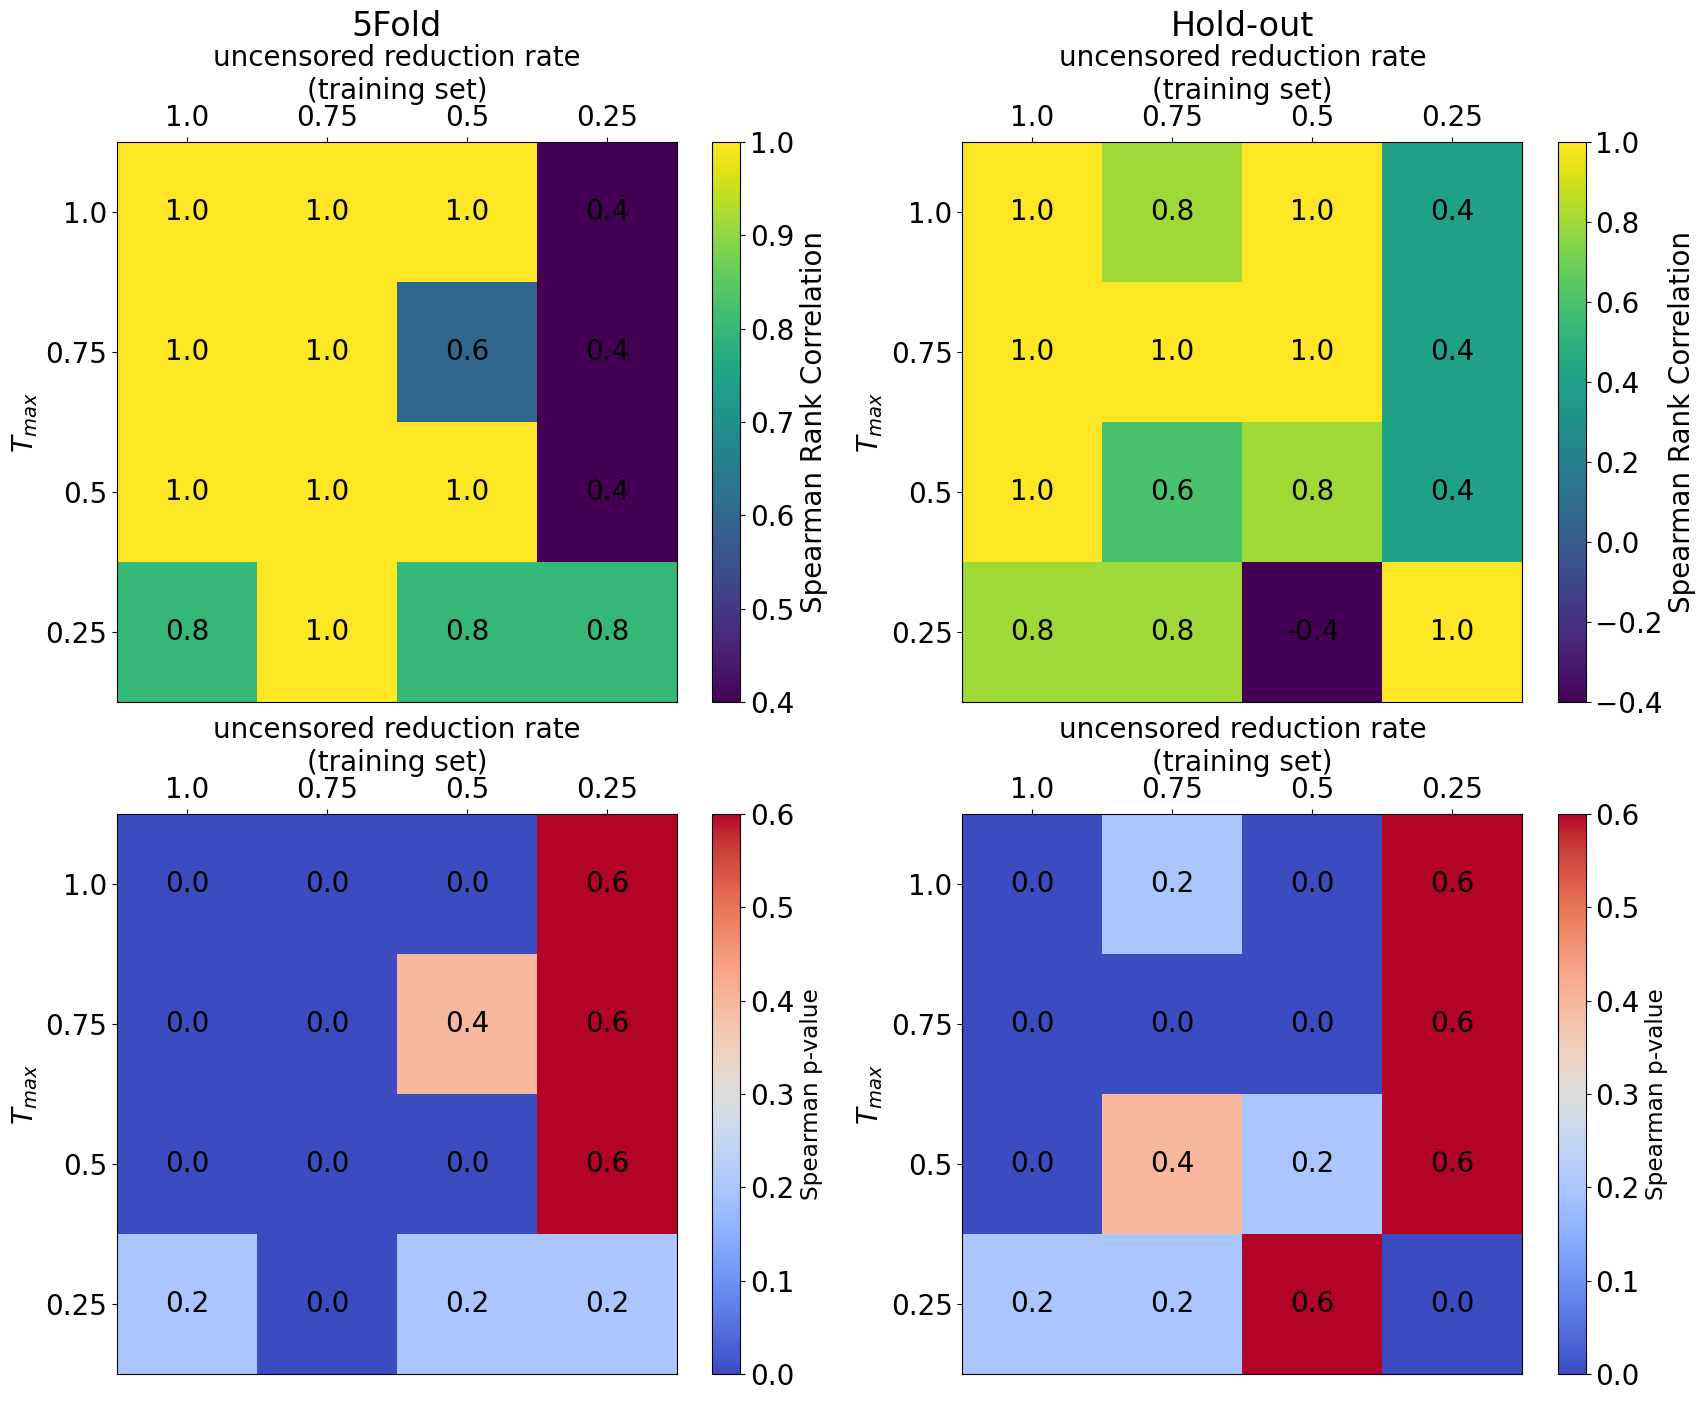

In [134]:
Models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
for model in Models:
    print(model)
    fig, axs = plt.subplots(2,2,figsize=(20,16))
    typs = ["5Fold","Hold-out"]
    locs = [[0,0],[0,1]]
    #ylims = [[0.28,0.85],[-0.7,2.1],[0.5,1.0],[1e-3,1]]

    for typ,loc in zip(typs,locs):
        for _,row in sensitivity_analysis_corr[(sensitivity_analysis_corr.Model == model) & (sensitivity_analysis_corr.Type == typ)].iterrows():
            # Correlation
            # Normalization
            norm = Normalize(vmin = np.array(row.corrs).min(), vmax = np.array(row.corrs).max())
            # Heatmap & Colorbar
            im = axs[loc[0]][loc[1]].imshow(np.array(row.corrs).reshape(4,4), norm = norm)
            cbar = axs[loc[0]][loc[1]].figure.colorbar(im)

            # Ticks & Tick labels
            axs[loc[0]][loc[1]].set_xticks(np.arange(np.array(row.corrs).reshape(4,4).shape[1]), labels=red_rates)
            axs[loc[0]][loc[1]].set_xlabel("uncensored reduction rate\n(training set)")
            axs[loc[0]][loc[1]].xaxis.set_ticks_position('top')
            #axs[loc[0]][loc[1]].tick_params(labelbottom=True, labeltop=True)
            axs[loc[0]][loc[1]].xaxis.set_label_position('top')
            axs[loc[0]][loc[1]].set_yticks(np.arange(np.array(row.corrs).reshape(4,4).shape[0]), labels=[1.0,0.75,0.5,0.25])
            axs[loc[0]][loc[1]].set_ylabel("$T_{max}$")

            # Colorbar labels
            cbar.set_label("Spearman Rank Correlation")

            # Scores as text
            for i in range(len(red_rates)):
                for j in range(len(T_maxs)):
                    corr = "{:.5}".format(np.array(row.corrs).reshape(4,4)[i,j])
                    scr_str = f"{corr}"
                    text = axs[loc[0]][loc[1]].text(j, i, scr_str,ha="center", va="center", size = "medium")

            # Title
            axs[loc[0]][loc[1]].set_title(typ)

            # p-value
            # Normalization
            norm = Normalize(vmin = np.array(row.pvals).min(), vmax = np.array(row.pvals).max())
            # Heatmap & Colorbar
            im = axs[loc[0]+1][loc[1]].imshow(np.array(row.pvals).reshape(4,4), norm = norm,  cmap = "coolwarm")
            cbar = axs[loc[0]+1][loc[1]].figure.colorbar(im, cmap = "coolwarm")

            # Ticks & Tick labels
            axs[loc[0]+1][loc[1]].set_xticks(np.arange(np.array(row.pvals).reshape(4,4).shape[1]), labels=[1.0,0.75,0.5,0.25])
            axs[loc[0]+1][loc[1]].set_xlabel("uncensored reduction rate\n(training set)")
            axs[loc[0]+1][loc[1]].xaxis.set_ticks_position('top')
            axs[loc[0]+1][loc[1]].xaxis.set_label_position('top')
            axs[loc[0]+1][loc[1]].set_yticks(np.arange(np.array(row.pvals).reshape(4,4).shape[0]), labels=[1.0,0.75,0.5,0.25])
            axs[loc[0]+1][loc[1]].set_ylabel("$T_{max}$")

            # Colorbar labels
            cbar.set_label("Spearman p-value", fontsize = "small")

            # Scores as text
            for i in range(len(red_rates)):
                for j in range(len(T_maxs)):
                    pval = "{:.5}".format(np.array(row.pvals).reshape(4,4)[i,j])
                    scr_str = f"{pval}"
                    text = axs[loc[0]+1][loc[1]].text(j, i, scr_str,ha="center", va="center", size = "medium")

    #fig.tight_layout()
    plt.show()

#### Visualizing the change in dataset quality

In [135]:
from utils import reduce_T_max,reduce_uncensored
from lifelines.fitters.coxph_fitter import CoxPHFitter

y_baseline = y_train.copy()

five_fold_mean = np.zeros((len(T_maxs),len(red_rates))).flatten()
five_fold_std = np.zeros((len(T_maxs),len(red_rates))).flatten()
hold_out_res = np.zeros((len(T_maxs),len(red_rates))).flatten()

i = 0
for T_max,red_rate in sensitivity_grid:
    y_red = np.copy(y_baseline)
    y_red = reduce_T_max(y_red,T_max)

    # 5Fold
    kf = KFold(n_splits=5,random_state=42,shuffle=True)
    p_vals = []
    for train_index, test_index in kf.split(y_red):
        y_trn, y_tst = y_red[train_index], y_red[test_index]
        y_trn_baseline, y_tst_baseline = y_baseline[train_index], y_baseline[test_index]
        y_trn = reduce_uncensored(y_trn, red_rate)

        cox_test_df = pd.DataFrame(np.append(np.vstack([y_trn,y_trn_baseline]),np.hstack([np.zeros(len(y_trn)).T,np.ones(len(y_trn_baseline))]).reshape(-1,1),axis=1))

        cph = CoxPHFitter()
        cph.fit(df = cox_test_df,
                duration_col = 0,
                event_col = 1)
        pval = cph.log_likelihood_ratio_test().p_value
        if pval == 0.0:
            pval = 1e-300 #Replacing 0 with a very small float, so we can plot it on a logarithmic scale
        p_vals.append(pval)

    # Hold-out
    y_red = reduce_uncensored(y_red, red_rate)

    cox_test_df = pd.DataFrame(np.append(np.vstack([y_red,y_baseline]),np.hstack([np.zeros(len(y_red)).T,np.ones(len(y_baseline))]).reshape(-1,1),axis=1))

    cph = CoxPHFitter()
    cph.fit(df = cox_test_df,
            duration_col = 0,
            event_col = 1)

    p_val = cph.log_likelihood_ratio_test().p_value
    if p_val == 0.0:
        p_val = 1e-300 #Replacing 0 with a very small float, so we can plot it on a logarithmic scale

    # Adding results to the matrices
    hold_out_res[i] = p_val
    five_fold_mean[i] = np.mean(np.array(p_vals))
    five_fold_std[i] = 1.96*np.std(np.array(p_vals))/np.sqrt(5)

    i += 1

hold_out_res = hold_out_res.reshape((4,4))
five_fold_mean = five_fold_mean.reshape((4,4))
five_fold_std = five_fold_std.reshape((4,4))

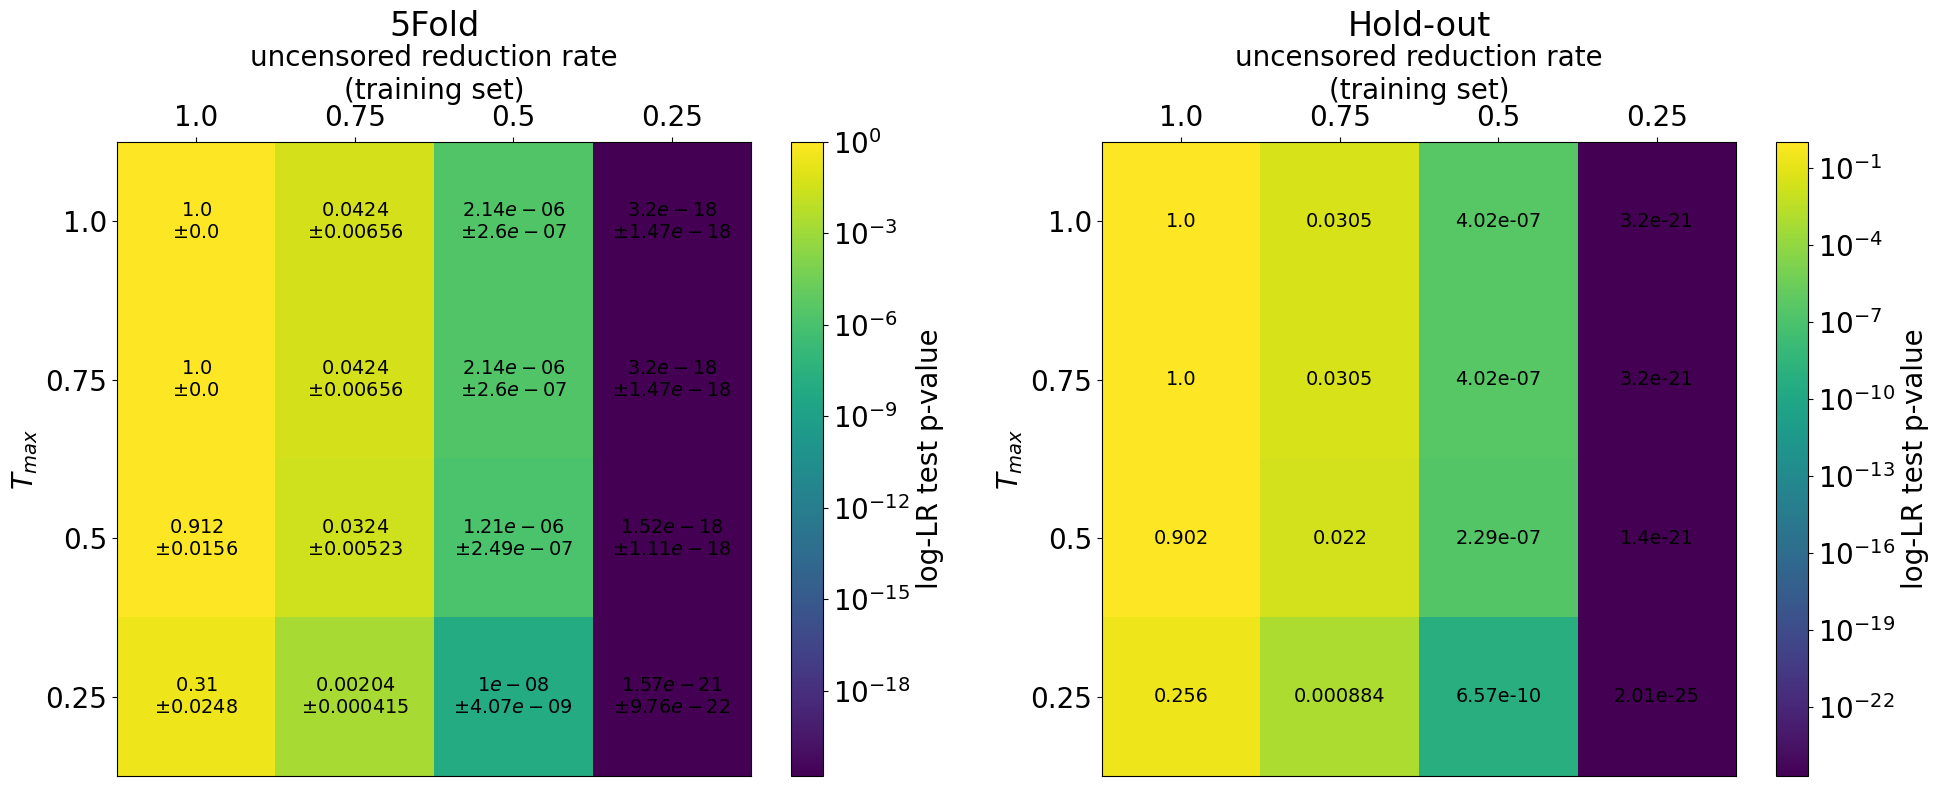

In [136]:
fig, axs = plt.subplots(1,2,figsize=(20,8))
typs = ["5Fold","Hold-out"]
locs = [[0,0],[0,1]]
datas = [five_fold_mean,hold_out_res]

for typ,loc,data in zip(typs,locs,datas):
    # Normalization
    norm = LogNorm(vmin = data.min(), vmax = data.max())

    # Heatmap & Colorbar
    im = axs[loc[1]].imshow(data, norm = norm)
    cbar = axs[loc[1]].figure.colorbar(im)

    # Ticks & Tick labels
    axs[loc[1]].set_xticks(np.arange(data.shape[1]), labels=[1.0,0.75,0.5,0.25])
    axs[loc[1]].set_xlabel("uncensored reduction rate\n(training set)")
    axs[loc[1]].xaxis.set_ticks_position('top')
    #axs[loc[0]][loc[1]].tick_params(labelbottom=True, labeltop=True)
    axs[loc[1]].xaxis.set_label_position('top')
    axs[loc[1]].set_yticks(np.arange(data.shape[0]), labels=[1.0,0.75,0.5,0.25])
    axs[loc[1]].set_ylabel("$T_{max}$")

    # Colorbar labels
    cbar.set_label("log-LR test p-value")

    # Scores as text
    for i in range(len(red_rates)):
        for j in range(len(T_maxs)):
            mean = "{:.3}".format(data[i,j])
            std = "{:.3}".format(five_fold_std[i,j])
            if typ == "5Fold":
                scr_str = f"${mean}$\n$\pm {std}$"
            else:
                scr_str = f"{mean}"
            text = axs[loc[1]].text(j, i, scr_str,ha="center", va="center", size = "x-small")

    # Title
    axs[loc[1]].set_title(typ)

fig.tight_layout()
plt.show()

In [137]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

for _,row in sensitivity_analysis_corr.iterrows():
    print(f"{row.Model}, {row.Type}")
    y_pred = MinMaxScaler().fit_transform(np.array(row.corrs).reshape(-1, 1))
    if row.Type == "5Fold":
        y_true = five_fold_mean.flatten()
        y_true_low = five_fold_mean.flatten() - five_fold_std.flatten()
        y_true_high = five_fold_mean.flatten() + five_fold_std.flatten()
        score = mean_squared_error(y_true, y_pred, squared=False)
        score_low = mean_squared_error(y_true_low, y_pred, squared=False)
        score_high = mean_squared_error(y_true_high, y_pred, squared=False)
        print(f"{score} +/- {score_low-score_high}")
    else:
        y_true = hold_out_res.flatten()
        score = mean_squared_error(y_true, y_pred, squared=False)
        print(score)

CoxPH, 5Fold
0.6627197634182442 +/- 0.0068819535804022225
CoxPH, Hold-out
0.6000580557699525
SurvivalTree, 5Fold
0.5728997796900995 +/- 0.00791545436627894
SurvivalTree, Hold-out
0.8556026852801307
RandomSurvivalForest, 5Fold
0.4509346468533293 +/- 0.009998509011111156
RandomSurvivalForest, Hold-out
0.06960422514809232
GradientBoosting, 5Fold
0.6194486167967209 +/- 0.006907593116981081
GradientBoosting, Hold-out
0.6000580557699525
MDN, 5Fold
0.6567297534006051 +/- 0.005373771394941218
MDN, Hold-out
0.7036093285172312


## Degradation

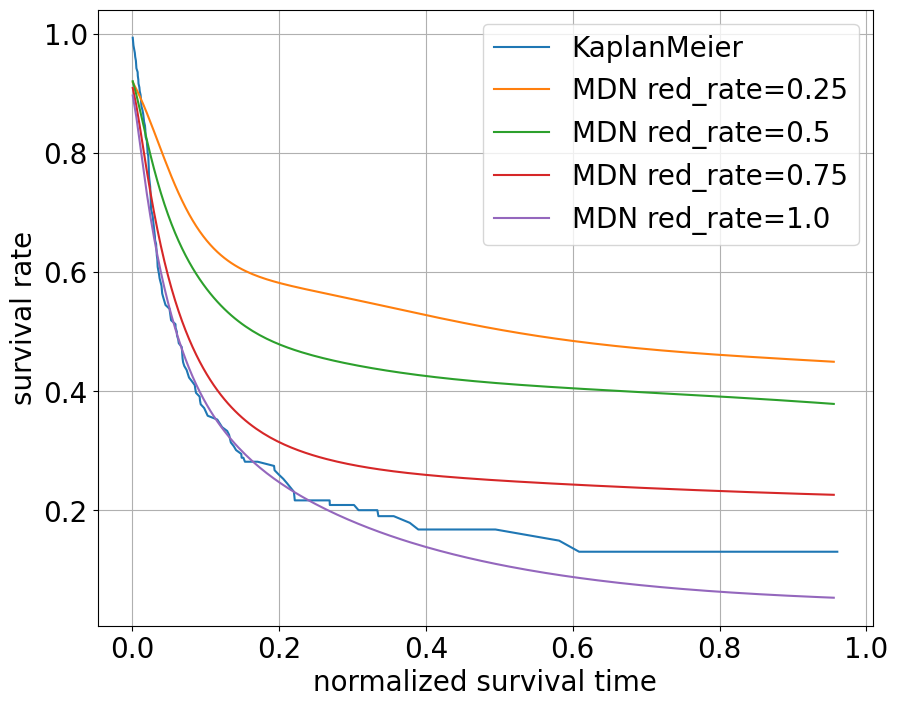

In [138]:
models = ["MDN"]
opts = [True]
red_rates = [0.25,0.5,0.75,1.0]
trials = list(product(models,opts,red_rates))

compare_survival  = {"Model":[],
                     "Timeline":[],
                     "Survival_Function":[]}

for trial in trials:
    for i in range(len(results_table["Model"])):
        if (results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1]) & (results_table["T_max"][i] == 1.0) & (results_table["Uncensored_Reduction"][i] == trial[2]):
            compare_survival["Model"].append(f"{trial[0]} red_rate={trial[2]}")
            compare_survival["Timeline"].append(results_table["Timeline"][i])
            compare_survival["Survival_Function"].append(results_table["Overall_Survival_Function"][i])
            

plt.figure(figsize=(10,8))
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
# Filter the test set for t > max(t_train), as these can cause problems for the scores (...)
t_max = min([max(y_train[:,0]),max(y_test[:,0])])
t_min = max([min(y_train[:,0]),min(y_test[:,0])])
mask = (t_min <= y_test[:,0]) & (y_test[:,0] <= t_max)
X_test = X_test[mask]
y_test = y_test[mask]
km_timeline, km_prob_survival = kaplan_meier_estimator(y_test[:,1].astype(bool),y_test[:,0])
plt.plot(km_timeline,km_prob_survival, label = "KaplanMeier")

for i in range(len(compare_survival["Model"])):
    plt.plot(compare_survival["Timeline"][i], compare_survival["Survival_Function"][i], label = compare_survival["Model"][i])
plt.legend()
plt.grid()
#plt.title(f"Worsening of survival rate estimate for the population of the {NAME_PLOT} hold-out set\nwith the reduction of uncensored patients in the training set")
plt.xlabel("normalized survival time")
plt.ylabel("survival rate")
#plt.xscale("log")
#plt.yscale("log")
plt.show()

## All results

In [139]:
models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
opts = [True,False]
T_maxs = [1.0,0.75,0.5,0.25]
red_rates = [1.0,0.75,0.5,0.25]
trials = list(product(models,opts,T_maxs,red_rates))

master_results  = {"Model":[],
                   "T_max":[],
                   "Uncensored Reduction":[],
                   "5Fold - c-index":[],
                   "5Fold - iBrier":[],
                   "5Fold - AUROC":[],
                   "5Fold - LogRank":[],
                   "Hold-out - c-index":[],
                   "Hold-out - iBrier":[],
                   "Hold-out - AUROC":[],
                   "Hold-out - LogRank":[]}

for trial in trials:
    for i in range(len(results_table["Model"])):
        if (results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1]) & (results_table["T_max"][i] == trial[2]) & (results_table["Uncensored_Reduction"][i] == trial[3]):
            master_results["Model"].append(f"{trial[0]} " + ["_LogRank" if trial[1] == True else ""][0])
            master_results["T_max"].append(results_table["T_max"][i])
            master_results["Uncensored Reduction"].append(results_table["Uncensored_Reduction"][i])
            master_results["5Fold - c-index"].append( str(round(results_table["5Fold"]["UnoC"]["mean"][i],4)).ljust(6,"0") +" ± " + str(round(1.96*results_table["5Fold"]["UnoC"]["std"][i]/np.sqrt(5),4)).ljust(6,"0") )
            master_results["5Fold - iBrier"].append( str(round(results_table["5Fold"]["iBrier"]["mean"][i],4)).ljust(6,"0") +" ± " + str(round(1.96*results_table["5Fold"]["iBrier"]["std"][i]/np.sqrt(5),4)).ljust(6,"0") )
            master_results["5Fold - AUROC"].append( str(round(results_table["5Fold"]["AUROC"]["mean"][i],4)).ljust(6,"0") +" ± " + str(round(1.96*results_table["5Fold"]["AUROC"]["std"][i]/np.sqrt(5),4)).ljust(6,"0") )
            master_results["5Fold - LogRank"].append( str(round(results_table["5Fold"]["LogRank"]["mean"][i],4)).ljust(6,"0") +" ± " + str(round(1.96*results_table["5Fold"]["LogRank"]["std"][i]/np.sqrt(5),4)).ljust(6,"0") )
            master_results["Hold-out - c-index"].append( str(round(results_table["Hold-out"]["UnoC"][i],4)).ljust(6,"0") )
            master_results["Hold-out - iBrier"].append( str(round(results_table["Hold-out"]["iBrier"][i],4)).ljust(6,"0") )
            master_results["Hold-out - AUROC"].append( str(round(results_table["Hold-out"]["AUROC"][i],4)).ljust(6,"0") )
            master_results["Hold-out - LogRank"].append( str(round(results_table["Hold-out"]["LogRank"][i],4)).ljust(6,"0") )
            
master_results = pd.DataFrame.from_dict(master_results)

In [140]:
master_results

Model  T_max  Uncensored Reduction  5Fold - c-index  \
0    CoxPH _LogRank   1.00                  1.00  0.6718 ± 0.0278   
1    CoxPH _LogRank   1.00                  0.75  0.6679 ± 0.0219   
2    CoxPH _LogRank   1.00                  0.50  0.6562 ± 0.0302   
3    CoxPH _LogRank   1.00                  0.25  0.6331 ± 0.0455   
4    CoxPH _LogRank   0.75                  1.00  0.6718 ± 0.0278   
..              ...    ...                   ...              ...   
155            MDN    0.50                  0.25  0.5580 ± 0.0421   
156            MDN    0.25                  1.00  0.6810 ± 0.0320   
157            MDN    0.25                  0.75  0.6757 ± 0.0352   
158            MDN    0.25                  0.50  0.6363 ± 0.0520   
159            MDN    0.25                  0.25  0.6002 ± 0.0402   

      5Fold - iBrier    5Fold - AUROC  5Fold - LogRank Hold-out - c-index  \
0    0.1461 ± 0.0321  0.7271 ± 0.0465  0.6022 ± 0.1338             0.7021   
1    0.2290 ± 0.0552  0.7254 ± 0.0440  0.6653 ± 0.2143             0.6817   
2    0.4065 ± 0.0749  0.7136 ± 0.0412  0.0444 ± 0.0493             0.6644   
3    0.8693 ± 0.0822  0.6812 ± 0.0370  0.0000 ± 0.0000             0.6347   
4    0.1461 ± 0.0321  0.7271 ± 0.0465  0.6022 ± 0.1338             0.7021   
..               ...              ...              ...                ...   
155  0.7560 ± 0.1254  0.5690 ± 0.0956  0.3068 ± 0.2791             0.5772   
156  0.1734 ± 0.0630  0.8113 ± 0.0771  0.5114 ± 0.2070             0.7247   
157  0.2517 ± 0.0637  0.7975 ± 0.0631  0.4344 ± 0.1481             0.6901   
158  0.3594 ± 0.0587  0.6783 ± 0.1087  0.4768 ± 0.2885             0.6923   
159  0.5890 ± 0.1079  0.6748 ± 0.0760  0.3247 ± 0.1854             0.6097   

    Hold-out - iBrier Hold-out - AUROC Hold-out - LogRank  
0              0.1341           0.7599             0.1379  
1              0.2609           0.7443             0.1406  
2              0.5210           0.7387             0.0000  
3              0.9931           0.7069             0.0000  
4              0.1341           0.7599             0.1379  
..                ...              ...                ...  
155            0.7832           0.4835             0.0000  
156            0.1894           0.6610             0.8750  
157            0.2793           0.6629             0.8581  
158            0.3797           0.6514             0.5113  
159            0.6898           0.5887             0.2751  

[160 rows x 11 columns]

In [141]:
# CSV version for the Paper
master_results.to_csv(f"Logs/{NAME}_results.csv",index=False)